<a href="https://colab.research.google.com/github/rodrigosilvacio/data-repository/blob/main/Tech_Challenge_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge - Exportação de Vinhos**

##**Importação de bibliotecas**##

In [ ]:
# Importação de bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import numpy as np
import warnings
from io import StringIO
import requests
import matplotlib.ticker as ticker

# Ignorar todos os warnings
warnings.filterwarnings('ignore')



## **Exportações**

###Exportações - Leitura e Tramento de Dados##

In [ ]:
# Leitura da fonte de dados
try:
    dados_brutos_exp = pd.read_csv('http://vitibrasil.cnpuv.embrapa.br/download/ExpVinho.csv', encoding='UTF-8', sep=';')
except FileNotFoundError:
    print("Arquivo de dados não encontrado. Verifique o caminho do arquivo.")
    exit()

In [ ]:
# Caso o site esteja fora, teremos que subir os arquivos manualmente
#dados_brutos_exp = pd.read_csv('ExpVinho.csv', encoding='UTF-8', sep=';')

In [ ]:
# Exibir as primeiras linhas para inspeção
print("Primeiras linhas do dataset:")
print(dados_brutos_exp.head())

Primeiras linhas do dataset:
   Id                             País  1970  1970.1  1971  1971.1  1972  \
0   1                      Afeganistão     0       0     0       0     0   
1   2                    África do Sul     0       0     0       0     0   
2   3  Alemanha, República Democrática     0       0     0       0  4168   
3   4                           Angola     0       0     0       0     0   
4   5                         Anguilla     0       0     0       0     0   

   1972.1   1973  1973.1  ...  2019  2019.1  2020  2020.1  2021  2021.1  2022  \
0       0      0       0  ...     0       0     0       0    11      46     0   
1       0      0       0  ...    26      95     4      21     0       0     0   
2    2630  12000    8250  ...  3660   25467  6261   32605  2698    6741  7630   
3       0      0       0  ...   345    1065     0       0     0       0  4068   
4       0      0       0  ...     0       0     0       0     0       0     0   

   2022.1  2023  2023.1  
0

In [ ]:
# Exibir as colunas do DataFrame
print("Colunas do arquivo:")
print(dados_brutos_exp.columns)

Colunas do arquivo:
Index(['Id', 'País', '1970', '1970.1', '1971', '1971.1', '1972', '1972.1',
       '1973', '1973.1',
       ...
       '2019', '2019.1', '2020', '2020.1', '2021', '2021.1', '2022', '2022.1',
       '2023', '2023.1'],
      dtype='object', length=110)


In [ ]:
# Filtrar apenas as colunas relevantes: País, anos de quantidade e anos de valor
quantidade_cols = [col for col in dados_brutos_exp.columns if not '.1' in col and col.isdigit()]
valor_cols = [col for col in dados_brutos_exp.columns if '.1' in col and col.split('.')[0].isdigit()]

# Converter os dados de formato wide para long (melt)
# Quantidade
dados_quantidade_exp = dados_brutos_exp.melt(id_vars=['Id', 'País'], value_vars=quantidade_cols,
                              var_name='Ano', value_name='Quantidade_Litros')

# Valor em USD
dados_valor_exp = dados_brutos_exp.melt(id_vars=['Id', 'País'], value_vars=valor_cols,
                         var_name='Ano', value_name='Valor_USD')

# Ajustar os anos (remover ".1" das colunas de valor)
dados_valor_exp['Ano'] = dados_valor_exp['Ano'].str.replace('.1', '')

# Unir os DataFrames de quantidade e valor
dados_final_exp = pd.merge(dados_quantidade_exp, dados_valor_exp,
                       on=['Id', 'País', 'Ano'], how='inner')

# Converter as colunas de Ano e valores para os tipos adequados
dados_final_exp['Ano'] = dados_final_exp['Ano'].astype(int)
dados_final_exp['Quantidade_Litros'] = pd.to_numeric(dados_final_exp['Quantidade_Litros'], errors='coerce')
dados_final_exp['Valor_USD'] = pd.to_numeric(dados_final_exp['Valor_USD'], errors='coerce')

# Remover valores nulos
dados_final_exp = dados_final_exp.dropna()

# Filtrar os últimos 15 anos
anos_recortes = sorted(dados_final_exp['Ano'].unique())[-15:]
dados_final_exp = dados_final_exp[dados_final_exp['Ano'].isin(anos_recortes)]




In [ ]:
# Exibir os dados tratados
print("Dados tratados:")
print(dados_final_exp.head())

Dados tratados:
      Id                             País   Ano  Quantidade_Litros  Valor_USD
5343   1                      Afeganistão  2009                  0          0
5344   2                    África do Sul  2009                  0          0
5345   3  Alemanha, República Democrática  2009             225086     393482
5346   4                           Angola  2009              54786      84235
5347   5                         Anguilla  2009                  0          0


###Exportações - Análise e Visualização dos Dados##

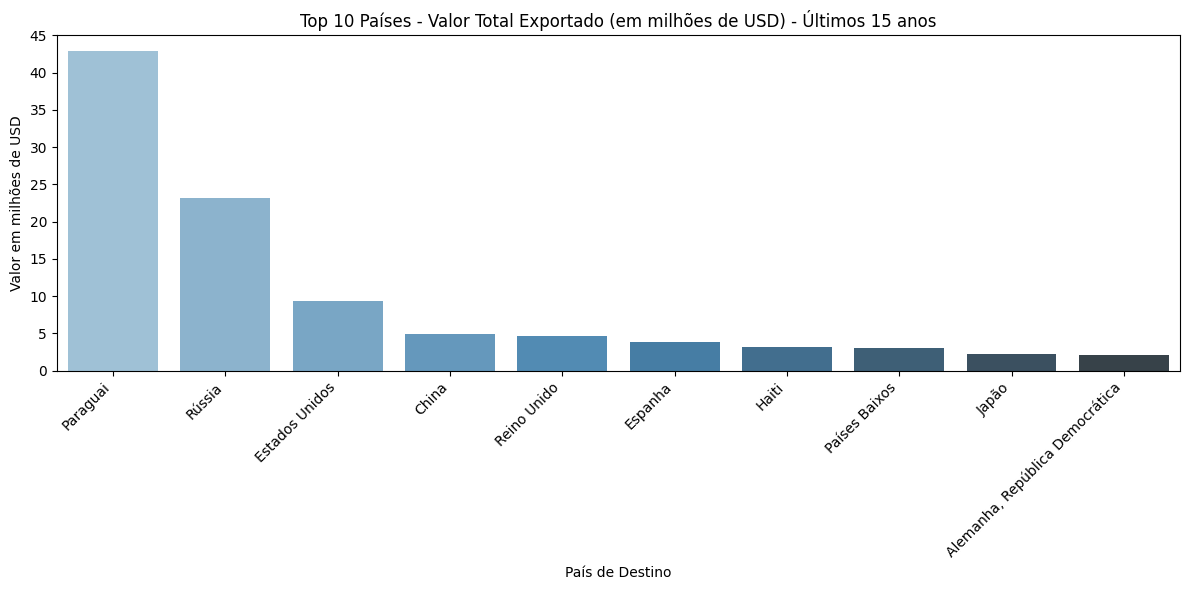

In [ ]:
# Etapa 3: Análise descritiva
# Dentro de uma empresa que exporta vinhos, as informações a respeito de exportações do Brasil são essenciais
# Agrupar os dados por País e somar a quantidade e o valor
agrupamento_paises_exp = dados_final_exp.groupby('País').agg({
    'Quantidade_Litros': 'sum',
    'Valor_USD': 'sum'
}).reset_index()

# Remover países com valores de exportação zerados
agrupamento_paises_exp = agrupamento_paises_exp[(agrupamento_paises_exp['Quantidade_Litros'] > 0) & (agrupamento_paises_exp['Valor_USD'] > 0)]

# Ordenar pelos maiores valores exportados
# Ordenar os dados pelos maiores valores exportados
agrupamento_paises_exp = agrupamento_paises_exp.sort_values(by='Valor_USD', ascending=False)

# Filtrar os Top 10 países com maior valor exportado
top_paises_exp = agrupamento_paises_exp.head(10)



#Convertendo o valor_usd em milhões
top_paises_exp['Valor_USD']=top_paises_exp['Valor_USD']/1_000_000

# Gráfico de barras: Valor exportado por país (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x='País', y='Valor_USD', data=top_paises_exp, palette='Blues_d')


# Configurações do gráfico
plt.title('Top 10 Países - Valor Total Exportado (em milhões de USD) - Últimos 15 anos')
plt.ylabel('Valor em milhões de USD')
plt.xlabel('País de Destino')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos no eixo X
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

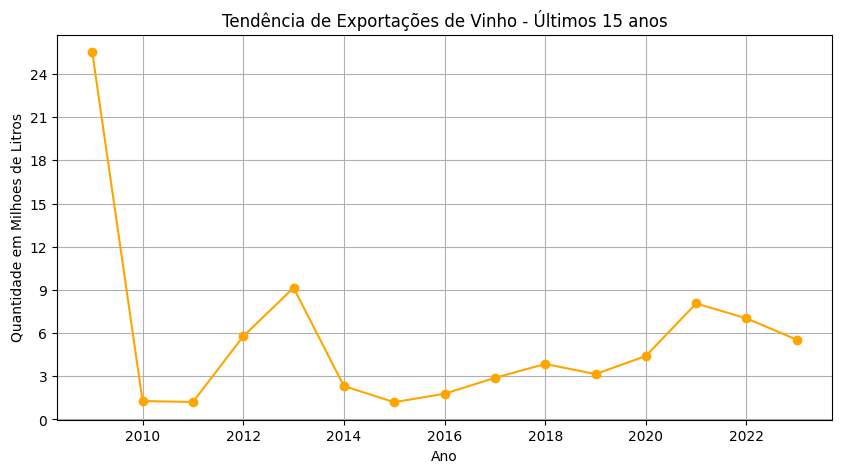

In [ ]:
# Gráfico de linha: Tendência temporal de exportações
# Adotamos a escala de milhões de litros, por isso fizemos a divisão das quantidades por 1_000_000
plt.figure(figsize=(10, 5))
dados_ano_exp = dados_final_exp.groupby('Ano').agg({'Quantidade_Litros': 'sum'}).reset_index()



plt.plot(dados_ano_exp['Ano'], dados_ano_exp['Quantidade_Litros']/1_000_000, marker='o', linestyle='-', color='orange')
plt.title('Tendência de Exportações de Vinho - Últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Milhoes de Litros')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(True)
plt.show()

In [ ]:
# Agrupar os dados por país e somar os valores exportados
agrupamento_paises_exp = dados_final_exp.groupby('País').agg({
    'Quantidade_Litros': 'sum',
    'Valor_USD': 'sum'
}).reset_index()

# Filtrar apenas os países com valores positivos
agrupamento_paises_exp = agrupamento_paises_exp[agrupamento_paises_exp['Valor_USD'] > 0]

# Criar o mapa de calor geoespacial com Plotly
fig = px.choropleth(
    agrupamento_paises_exp,
    locations='País',              # Nome dos países
    locationmode='country names',  # Modo baseado nos nomes dos países
    color='Valor_USD',             # Coluna usada para a escala de cores
    title='Exportação de Vinhos do Brasil por País (em USD)',
    color_continuous_scale='Blues', # Paleta de cores
    labels={'Valor_USD': 'Valor (USD)'}
)

# Ajustar layout do gráfico
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

# Mostrar o gráfico
fig.show()

###Projetação para próximos 5 anos##

Projeção para os próximos 5 anos:
Ano 2024: 2978394.06 Litros
Ano 2025: 2657568.34 Litros
Ano 2026: 2336742.62 Litros
Ano 2027: 2015916.90 Litros
Ano 2028: 1695091.19 Litros


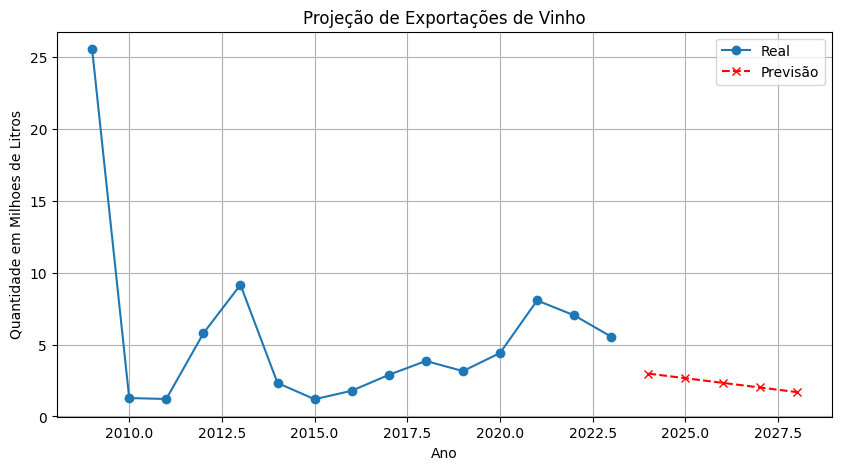

In [ ]:
# Etapa 5: Projeção futura (modelo linear simples)
# Preparar os dados para o modelo
X = dados_ano_exp['Ano'].values.reshape(-1, 1)
y = dados_ano_exp['Quantidade_Litros'].values

# Aplicar regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Prever valores futuros (próximos 5 anos)
anos_futuros = np.array([max(dados_ano_exp['Ano']) + i for i in range(1, 6)]).reshape(-1, 1)
previsoes = modelo.predict(anos_futuros)

# Exibir resultados de previsão
print("Projeção para os próximos 5 anos:")
for ano, previsao in zip(anos_futuros.flatten(), previsoes):
    print(f"Ano {ano}: {previsao:.2f} Litros")

# Gráfico com projeções futuras
# Adotamos a escala de milhões de litros, por isso fizemos a divisão das quantidades por 1_000_000
plt.figure(figsize=(10, 5))
plt.plot(dados_ano_exp['Ano'], dados_ano_exp['Quantidade_Litros']/1_000_000, label='Real', marker='o')
plt.plot(anos_futuros, previsoes/1_000_000, label='Previsão', linestyle='--', marker='x', color='red')
plt.title('Projeção de Exportações de Vinho')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Milhoes de Litros')
plt.legend()
plt.grid(True)
plt.show()

##**Importações**##

###Importações - Leitura e Tramento de Dados##

In [ ]:
# Leitura dos dados
try:
  dados_brutos_imp = pd.read_csv('http://vitibrasil.cnpuv.embrapa.br/download/ImpVinhos.csv', encoding='UTF-8', sep=';')
except FileNotFoundError:
    print("Arquivo de dados não encontrado. Verifique o caminho do arquivo.")
    exit()

In [ ]:
# Caso o site esteja fora, teremos que subir os arquivos manualmente
#dados_brutos_imp = pd.read_csv('ImpVinhos.csv', encoding='UTF-8', sep=';')

In [ ]:
# Colunas do Df
dados_brutos_imp.columns

Index(['Id', 'País', '1970', '1970.1', '1971', '1971.1', '1972', '1972.1',
       '1973', '1973.1',
       ...
       '2019', '2019.1', '2020', '2020.1', '2021', '2021.1', '2022', '2022.1',
       '2023', '2023.1'],
      dtype='object', length=110)

In [ ]:
# Infos do Df
dados_brutos_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 110 entries, Id to 2023.1
dtypes: float64(1), int64(108), object(1)
memory usage: 58.6+ KB


In [ ]:
# Filtrar Colunas Relevantes: País, Ano, Quantidade em Litros e Valor em USD
quantidade_cols = [col for col in dados_brutos_imp.columns if not '.1' in col and col.isdigit()]
valor_cols = [col for col in dados_brutos_imp.columns if '.1' in col and col.split('.')[0].isdigit()]

# Converter os dados de formato wide para long (melt)
# Quantidade
dados_quantidade_imp = dados_brutos_imp.melt(id_vars=['Id', 'País'], value_vars=quantidade_cols,
                              var_name='Ano', value_name='Quantidade_Litros')

# Valor em USD
dados_valor_imp = dados_brutos_imp.melt(id_vars=['Id', 'País'], value_vars=valor_cols,
                         var_name='Ano', value_name='Valor_USD')

# Ajustar os anos (remover ".1" das colunas de valor)
dados_valor_imp['Ano'] = dados_valor_imp['Ano'].str.replace('.1', '')

# Unir os DataFrames de quantidade e valor
dados_final_imp = pd.merge(dados_quantidade_imp, dados_valor_imp,
                       on=['Id', 'País', 'Ano'], how='inner')

# Converter as colunas de Ano e valores para os tipos adequados
dados_final_imp['Ano'] = dados_final_imp['Ano'].astype(int)
dados_final_imp['Quantidade_Litros'] = pd.to_numeric(dados_final_imp['Quantidade_Litros'], errors='coerce')
dados_final_imp['Valor_USD'] = pd.to_numeric(dados_final_imp['Valor_USD'], errors='coerce')

# Remover valores nulos
dados_final_imp = dados_final_imp.dropna()

# Filtrar os últimos 15 anos
anos_recortes = sorted(dados_final_imp['Ano'].unique())[-15:]
dados_final_imp = dados_final_imp[dados_final_imp['Ano'].isin(anos_recortes)]

In [ ]:
dados_final_imp

,Id,País,Ano,Quantidade_Litros,Valor_USD
2652,1,Africa do Sul,2009,493093,1931449.0
2653,2,Alemanha,2009,56075,291876.0
2654,3,Argélia,2009,0,0.0
2655,4,Arábia Saudita,2009,0,0.0
2656,5,Argentina,2009,13902750,38521731.0
...,...,...,...,...,...
3667,64,Ucrânia,2023,0,0.0
3668,65,Uruguai,2023,2905567,9276001.0
3669,66,Não consta na tabela,2023,0,0.0
3670,67,Não declarados,2023,0,0.0


###Importações - Análise e Visualização dos Dados##

In [ ]:
# Agrupar os dados por País e somar a quantidade e o valor
agrupamento_paises_imp = dados_final_imp.groupby('País').agg({
    'Quantidade_Litros': 'sum',
    'Valor_USD': 'sum'
}).reset_index()

# Remover países com valores de importação zerados
agrupamento_paises_imp = agrupamento_paises_imp[(agrupamento_paises_imp['Quantidade_Litros'] > 0) & (agrupamento_paises_imp['Valor_USD'] > 0)]

# Ordenar os dados pelos maiores valores importados
agrupamento_paises_imp = agrupamento_paises_imp.sort_values(by='Valor_USD', ascending=False)

# Filtrar os Top 10 países com maior valor de importação
top_paises_imp = agrupamento_paises_imp.head(10)

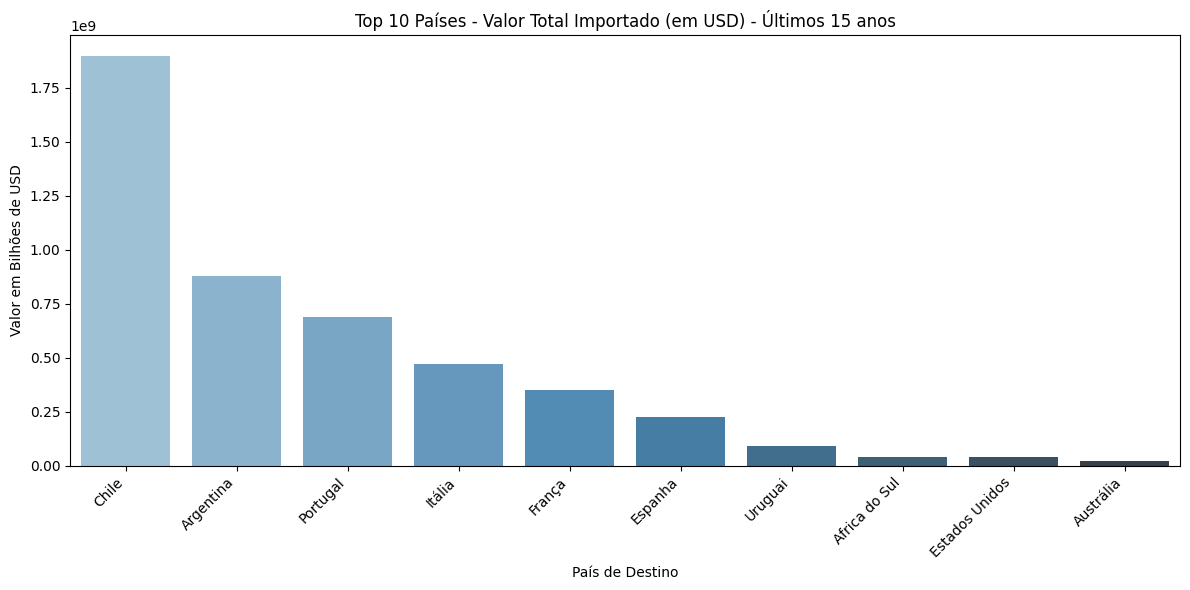

In [ ]:
# Gráfico de barras: Valor importado por país (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(x='País', y='Valor_USD', data=top_paises_imp, palette='Blues_d')


# Configurações do gráfico
plt.title('Top 10 Países - Valor Total Importado (em USD) - Últimos 15 anos')
plt.ylabel('Valor em Bilhões de USD')
plt.xlabel('País de Destino')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos no eixo X
plt.tight_layout()
plt.show()


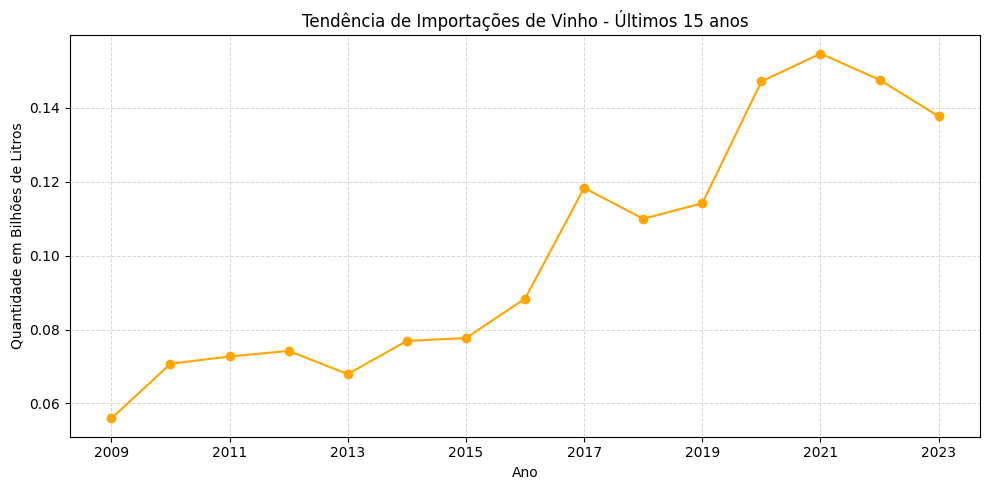

In [ ]:
# Gráfico de linha: Tendência temporal de importações
plt.figure(figsize=(10, 5))
dados_ano_imp = dados_final_imp.groupby('Ano').agg({'Quantidade_Litros': 'sum'}).reset_index()

# Ajustar os valores para bilhões de litros
dados_ano_imp['Quantidade_Litros_Bilhoes'] = dados_ano_imp['Quantidade_Litros'] / 1_000_000_000

# Plotar os dados
plt.plot(dados_ano_imp['Ano'], dados_ano_imp['Quantidade_Litros_Bilhoes'], marker='o', linestyle='-', color='orange')

# Título e rótulos
plt.title('Tendência de Importações de Vinho - Últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Bilhões de Litros')

# Ajustar os ticks do eixo X para começar em 2009 e pular de 2 em 2 anos
anos_ticks = np.arange(2009, 2024, 2)  # Gera os anos: 2009, 2011, ..., 2023
plt.xticks(anos_ticks)

# Ajustar a grade para ser mais leve
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


###Projetação para próximos 5 anos##

Projeção para os próximos 5 anos:
Ano 2024: 157531937.41 Litros
Ano 2025: 164605996.20 Litros
Ano 2026: 171680055.00 Litros
Ano 2027: 178754113.79 Litros
Ano 2028: 185828172.58 Litros


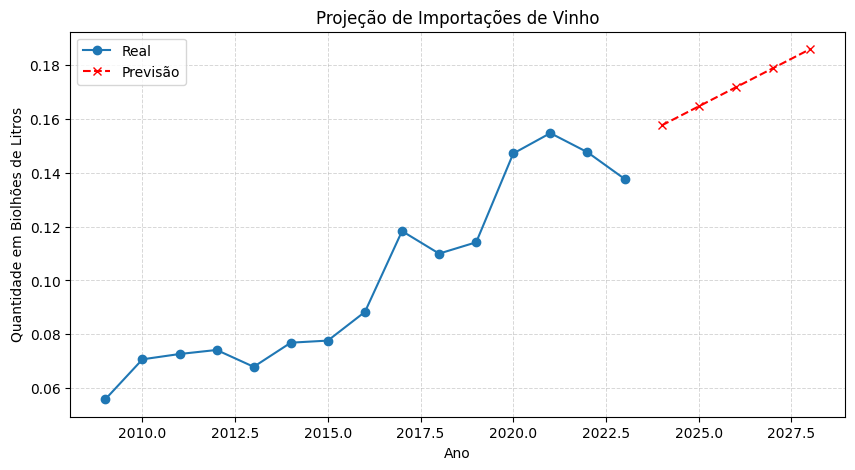

In [ ]:
# Etapa 5: Projeção futura (modelo linear simples)
# Preparar os dados para o modelo
X = dados_ano_imp['Ano'].values.reshape(-1, 1)
y = dados_ano_imp['Quantidade_Litros'].values

# Aplicar regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Prever valores futuros (próximos 5 anos)
anos_futuros = np.array([max(dados_ano_imp['Ano']) + i for i in range(1, 6)]).reshape(-1, 1)
previsoes = modelo.predict(anos_futuros)

# Exibir resultados de previsão
print("Projeção para os próximos 5 anos:")
for ano, previsao in zip(anos_futuros.flatten(), previsoes):
    print(f"Ano {ano}: {previsao:.2f} Litros")

# Gráfico com projeções futuras
plt.figure(figsize=(10, 5))
plt.plot(dados_ano_imp['Ano'], dados_ano_imp['Quantidade_Litros']/1_000_000_000, label='Real', marker='o')
plt.plot(anos_futuros, previsoes/1_000_000_000, label='Previsão', linestyle='--', marker='x', color='red')
plt.title('Projeção de Importações de Vinho')
plt.xlabel('Ano')
plt.ylabel('Quantidade em Biolhões de Litros')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
plt.show()

## **PIB**

###PIB - Leitura e Tratamento de Dados (WorldBank)##

####Código dos Países

In [ ]:
# Lista com de-para do código dos países
cod_paises_pib = {
'ZAF':'África do Sul',
'DEU':'Alemanha República Democrática',
'AGO':'Angola',
'ATG':'Antígua e Barbuda',
'BES':'Antilhas Holandesas',
'ARG':'Argentina',
'AUS':'Austrália',
'AUT':'Áustria',
'BRB':'Barbados',
'BHR':'Barein',
'BEL':'Bélgica',
'BLZ':'Belice',
'BEN':'Benin',
'BOL':'Bolívia',
'BGR':'Bulgária',
'CPV':'Cabo Verde',
'CMR':'Camarões',
'CAN':'Canadá',
'CHL':'Chile',
'CHN':'China',
'CYP':'Chipre',
'SGP':'Cingapura',
'COL':'Colômbia',
'COG':'Congo',
'KOR':'Coreia do Sul',
'CIV':'Costa do Marfim',
'CRI':'Costa Rica',
'CUB':'Cuba',
'DNK':'Dinamarca',
'SLV':'El Salvador',
'ECU':'Equador',
'SVK':'Eslováquia',
'ESP':'Espanha',
'USA':'Estados Unidos',
'EST':'Estônia',
'PHL':'Filipinas',
'FIN':'Finlândia',
'FRA':'França',
'GHA':'Gana',
'GRC':'Grécia',
'GTM':'Guatemala',
'GNB':'Guiné-Bissau',
'HTI':'Haiti',
'HND':'Honduras',
'HUN':'Hungria',
'IND':'Índia',
'IRQ':'Iraque',
'IRL':'Irlanda',
'ITA':'Itália',
'JAM':'Jamaica',
'JPN':'Japão',
'JOR':'Jordânia',
'LVA':'Letônia',
'LBN':'Líbano',
'LBR':'Libéria',
'LUX':'Luxemburgo',
'MYS':'Malásia',
'MLT':'Malta',
'MEX':'México',
'MNE':'Montenegro',
'NAM':'Namíbia',
'NIC':'Nicarágua',
'NGA':'Nigéria',
'NOR':'Noruega',
'NZL':'Nova Zelândia',
'NLD':'Países Baixos',
'PAN':'Panamá',
'PRY':'Paraguai',
'PER':'Peru',
'POL':'Polônia',
'PRT':'Portugal',
'GBR':'Reino Unido',
'DOM':'República Dominicana',
'RUS':'Rússia',
'STP':'São Tomé e Príncipe',
'SEN':'Senegal',
'SLE':'Serra Leoa',
'SWE':'Suécia',
'CHE':'Suíça',
'SUR':'Suriname',
'THA':'Tailândia',
'TZA':'Tanzânia',
'CZE':'Tcheca República',
'TGO':'Togo',
'TTO':'Trinidad e Tobago',
'TUN':'Tunísia',
'TUR':'Turquia',
'URY':'Uruguai',
'VEN':'Venezuela',
'VNM':'Vietnã'



 }




####Tratamento de Dados

In [ ]:
# Criando o dataframe para receber os dados do PIB
dados_pib=pd.DataFrame()

In [ ]:
# Extração dos dados do PIB do site do worldbank, utilizando a lista de código dos países
for i in cod_paises_pib.keys():
  country_code=i
  indicator = 'NY.GDP.MKTP.CD'  # PIB em valores correntes (US$)
  url = f'http://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?format=json'
  response = requests.get(url)
  pib = response.json()
  try:
    df_pib=pd.DataFrame(pib[1:][0])
    df_pib=df_pib[['countryiso3code','date','value']]
    dados_pib=pd.concat([dados_pib,df_pib])
  except:
    pass


In [ ]:
# Renomeando as colunas para nomes em português
dados_pib.rename({'countryiso3code':'País','date':'Ano','value':'Pib'},axis=1,inplace=True)

In [ ]:
# Trazendo o nome dos países para o dataframe
dados_pib['País']=dados_pib['País'].map(cod_paises_pib)

In [ ]:
# Definindo quais anos serão analisados (lista em formato de string)
ultimos_anos=['2023','2022','2021','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009']

In [ ]:
# Filtrando o dataframe com os anos que serão analisados
dados_pib_ult_anos=dados_pib[dados_pib['Ano'].isin(ultimos_anos)]

In [ ]:
# Verificando quais os países que temos no nosso dataframe final
dados_pib_ult_anos['País'].unique()

array(['África do Sul', 'Alemanha República Democrática', 'Angola',
       'Antígua e Barbuda', 'Argentina', 'Austrália', 'Áustria',
       'Barbados', 'Barein', 'Bélgica', 'Belice', 'Benin', 'Bolívia',
       'Bulgária', 'Cabo Verde', 'Camarões', 'Canadá', 'Chile', 'China',
       'Chipre', 'Cingapura', 'Colômbia', 'Congo', 'Coreia do Sul',
       'Costa do Marfim', 'Costa Rica', 'Cuba', 'Dinamarca',
       'El Salvador', 'Equador', 'Eslováquia', 'Espanha',
       'Estados Unidos', 'Estônia', 'Filipinas', 'Finlândia', 'França',
       'Gana', 'Grécia', 'Guatemala', 'Guiné-Bissau', 'Haiti', 'Honduras',
       'Hungria', 'Índia', 'Iraque', 'Irlanda', 'Itália', 'Jamaica',
       'Japão', 'Jordânia', 'Letônia', 'Líbano', 'Libéria', 'Luxemburgo',
       'Malásia', 'Malta', 'México', 'Montenegro', 'Namíbia', 'Nicarágua',
       'Nigéria', 'Noruega', 'Nova Zelândia', 'Países Baixos', 'Panamá',
       'Paraguai', 'Peru', 'Polônia', 'Portugal', 'Reino Unido',
       'República Dominicana', 'Rú

In [ ]:
# Transformando os dados da coluna ano em numero inteiro.
dados_pib_ult_anos['Ano']=dados_pib_ult_anos['Ano'].astype(int)

In [ ]:
# Juntando os dados extraídos da emprapa de exportação com os dados do worldbank (PIB)
dados_agrupados_1 = pd.merge(dados_pib_ult_anos, dados_final_exp, on=['País', 'Ano'], how='left')
dados_agrupados_1.rename(columns={'Valor_USD': 'Valor_USD_Exp',
                                  'Quantidade_Litros': 'Quantidade_Litros_Exp',
                                  'Pais': 'País',
                                  'Id': 'ID'}, inplace=True)


In [ ]:
dados_agrupados_1

,País,Ano,Pib,ID,Quantidade_Litros_Exp,Valor_USD_Exp
0,África do Sul,2023,3.806993e+11,2.0,117.0,698.0
1,África do Sul,2022,4.069200e+11,2.0,0.0,0.0
2,África do Sul,2021,4.208869e+11,2.0,0.0,0.0
3,África do Sul,2020,3.379747e+11,2.0,4.0,21.0
4,África do Sul,2019,3.893300e+11,2.0,26.0,95.0
...,...,...,...,...,...,...
1330,Vietnã,2013,2.137088e+11,137.0,0.0,0.0
1331,Vietnã,2012,1.955907e+11,137.0,0.0,0.0
1332,Vietnã,2011,1.725950e+11,137.0,0.0,0.0
1333,Vietnã,2010,1.472012e+11,137.0,8820.0,9977.0


In [ ]:
# Juntando os dados extraídos da emprapa de importação com os dados do worldbank (PIB)
dados_agrupados_1 = pd.merge(dados_agrupados_1, dados_final_imp, on=['País', 'Ano'], how='left')
dados_agrupados_1.rename(columns={'Valor_USD': 'Valor_USD_Imp',
                                  'Quantidade_Litros': 'Quantidade_Litros_Imp',
                                  'Pais': 'País',
                                  'Id': 'ID'}, inplace=True)

In [ ]:
# Visualizando o novo dataframe
dados_agrupados_1

,País,Ano,Pib,ID,Quantidade_Litros_Exp,Valor_USD_Exp,ID,Quantidade_Litros_Imp,Valor_USD_Imp
0,África do Sul,2023,3.806993e+11,2.0,117.0,698.0,NaN,NaN,NaN
1,África do Sul,2022,4.069200e+11,2.0,0.0,0.0,NaN,NaN,NaN
2,África do Sul,2021,4.208869e+11,2.0,0.0,0.0,NaN,NaN,NaN
3,África do Sul,2020,3.379747e+11,2.0,4.0,21.0,NaN,NaN,NaN
4,África do Sul,2019,3.893300e+11,2.0,26.0,95.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1330,Vietnã,2013,2.137088e+11,137.0,0.0,0.0,NaN,NaN,NaN
1331,Vietnã,2012,1.955907e+11,137.0,0.0,0.0,NaN,NaN,NaN
1332,Vietnã,2011,1.725950e+11,137.0,0.0,0.0,NaN,NaN,NaN
1333,Vietnã,2010,1.472012e+11,137.0,8820.0,9977.0,NaN,NaN,NaN


## **Análises Exportações, Importações e PIB**

### Percentual de Exportações no PIB ##

In [ ]:
# Iremos criar um indicador que representará  a participação da exportação (USD) sobre o valor do PIB dos países
# Criamos uma coluna nova em nosso dataframe para receber este novo indicador
dados_agrupados_1['%_part_exportacao']=dados_agrupados_1['Valor_USD_Exp']/dados_agrupados_1['Pib']

In [ ]:
# Excluindo as colunas Id do nosso dataframe pois não será utilizada em nossas análises
dados_agrupados_1.drop(columns='ID',inplace=True)

In [ ]:
#
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10
...,...,...,...,...,...,...,...,...
1330,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00
1331,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00
1332,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00
1333,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08


### Percentual de Importações no PIB ##

In [ ]:
# Iremos criar um indicador que representará  a participação da importacao (USD) sobre o valor do PIB dos países
# Criamos uma coluna nova em nosso dataframe para receber este novo indicador
dados_agrupados_1['%_part_importacao']=dados_agrupados_1['Valor_USD_Imp']/dados_agrupados_1['Pib']

In [ ]:
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao,%_part_importacao
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09,NaN
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11,NaN
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10,NaN
...,...,...,...,...,...,...,...,...,...
1330,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN
1331,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN
1332,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN
1333,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08,NaN


##**Taxas de Câmbio**

In [ ]:
# Iremos usar como referencia a taxa de cambio média do ano, vamos calcular a média com a taxa de cambio do ultimo dia de cada mes ao longo dos anos
# Porém neste site temos dados a partir de 2015
datas_pesquisa={
'2015-01-31':'2015',
'2015-02-28':'2015',
'2015-03-31':'2015',
'2015-04-30':'2015',
'2015-05-31':'2015',
'2015-06-30':'2015',
'2015-07-31':'2015',
'2015-08-31':'2015',
'2015-09-30':'2015',
'2015-10-31':'2015',
'2015-11-30':'2015',
'2015-12-31':'2015',
'2016-01-31':'2016',
'2016-02-29':'2016',
'2016-03-31':'2016',
'2016-04-30':'2016',
'2016-05-31':'2016',
'2016-06-30':'2016',
'2016-07-31':'2016',
'2016-08-31':'2016',
'2016-09-30':'2016',
'2016-10-31':'2016',
'2016-11-30':'2016',
'2016-12-31':'2016',
'2017-01-31':'2017',
'2017-02-28':'2017',
'2017-03-31':'2017',
'2017-04-30':'2017',
'2017-05-31':'2017',
'2017-06-30':'2017',
'2017-07-31':'2017',
'2017-08-31':'2017',
'2017-09-30':'2017',
'2017-10-31':'2017',
'2017-11-30':'2017',
'2017-12-31':'2017',
'2018-01-31':'2018',
'2018-02-28':'2018',
'2018-03-31':'2018',
'2018-04-30':'2018',
'2018-05-31':'2018',
'2018-06-30':'2018',
'2018-07-31':'2018',
'2018-08-31':'2018',
'2018-09-30':'2018',
'2018-10-31':'2018',
'2018-11-30':'2018',
'2018-12-31':'2018',
'2019-01-31':'2019',
'2019-02-28':'2019',
'2019-03-31':'2019',
'2019-04-30':'2019',
'2019-05-31':'2019',
'2019-06-30':'2019',
'2019-07-31':'2019',
'2019-08-31':'2019',
'2019-09-30':'2019',
'2019-10-31':'2019',
'2019-11-30':'2019',
'2019-12-31':'2019',
'2020-01-31':'2020',
'2020-02-29':'2020',
'2020-03-31':'2020',
'2020-04-30':'2020',
'2020-05-31':'2020',
'2020-06-30':'2020',
'2020-07-31':'2020',
'2020-08-31':'2020',
'2020-09-30':'2020',
'2020-10-31':'2020',
'2020-11-30':'2020',
'2020-12-31':'2020',
'2021-01-31':'2021',
'2021-02-28':'2021',
'2021-03-31':'2021',
'2021-04-30':'2021',
'2021-05-31':'2021',
'2021-06-30':'2021',
'2021-07-31':'2021',
'2021-08-31':'2021',
'2021-09-30':'2021',
'2021-10-31':'2021',
'2021-11-30':'2021',
'2021-12-31':'2021',
'2022-01-31':'2022',
'2022-02-28':'2022',
'2022-03-31':'2022',
'2022-04-30':'2022',
'2022-05-31':'2022',
'2022-06-30':'2022',
'2022-07-31':'2022',
'2022-08-31':'2022',
'2022-09-30':'2022',
'2022-10-31':'2022',
'2022-11-30':'2022',
'2022-12-31':'2022',
'2023-01-31':'2023',
'2023-02-28':'2023',
'2023-03-31':'2023',
'2023-04-30':'2023',
'2023-05-31':'2023',
'2023-06-30':'2023',
'2023-07-31':'2023',
'2023-08-31':'2023',
'2023-09-30':'2023',
'2023-10-31':'2023',
'2023-11-30':'2023',
'2023-12-31':'2023'


}

In [ ]:
# Criando o dataframe para receber os dados de câmbio
dados_cambio=pd.DataFrame()

In [ ]:
# URL da página com a tabela de taxas de câmbio
url = 'https://www.x-rates.com/historical/?from=USD&amount=1&date='

for i in datas_pesquisa.keys():
  url_data=url+i
  # Ler todas as tabelas da página
  tables = pd.read_html(url_data)
  #Salvando a tabela com a taxa de cambio
  df_cambio = tables[1]
  df_cambio['Data']=i
  dados_cambio=pd.concat([dados_cambio,df_cambio])


In [ ]:
# Renomear as colunas
dados_cambio.columns = ['Moeda', 'Taxa', 'Taxa_de_Cambio','Data']

In [ ]:
# Incluindo a coluna com o ano
dados_cambio['Ano']=dados_cambio['Data'].map(datas_pesquisa)

In [ ]:
# Dicionário para fazer de-para de moeda para país
moedas_paises = {

'Argentine Peso':'Argentina',
'Australian Dollar':'Austrália',
'Bahraini Dinar':'Barein',
'Botswana Pula':'Botsuana',
'Brazilian Real':'Brasil',
'British Pound':'Gibraltar',
'Bruneian Dollar':'Brunei',
'Bulgarian Lev':'Bulgária',
'Canadian Dollar':'Canadá',
'Chilean Peso':'Chile',
'Chinese Yuan Renminbi':'China',
'Colombian Peso':'Colômbia',
'Czech Koruna':'Tcheca República',
'Danish Krone':'Dinamarca',
'Emirati Dirham':'Emirados Árabes Unidos',
'Euro':'Alemanha',
'Hong Kong Dollar':'Hong Kong',
'Hungarian Forint':'Hungria',
'Icelandic Krona':'Islândia',
'Indian Rupee':'Índia',
'Indonesian Rupiah':'Indonésia',
'Iranian Rial':'Irã',
'Israeli Shekel':'Israel',
'Japanese Yen':'Japão',
'Kazakhstani Tenge':'Cazaquistão',
'Kuwaiti Dinar':'Kuwait',
'Libyan Dinar':'Líbia',
'Malaysian Ringgit':'Malásia',
'Mauritian Rupee':'Maurício',
'Mexican Peso':'México',
'Nepalese Rupee':'Nepal',
'New Zealand Dollar':'Nova Zelândia',
'Norwegian Krone':'Noruega',
'Omani Rial':'Omã',
'Pakistani Rupee':'Paquistão',
'Philippine Peso':'Filipinas',
'Polish Zloty':'Polônia',
'Qatari Riyal':'Catar',
'Romanian New Leu':'Romênia',
'Russian Ruble':'Rússia',
'Saudi Arabian Riyal':'Arábia Saudita',
'Singapore Dollar':'Cingapura',
'South African Rand':'África do Sul',
'South Korean Won':'Coreia do Sul',
'Sri Lankan Rupee':'Sri Lanka',
'Swedish Krona':'Suécia',
'Swiss Franc':'Suíça',
'Taiwan New Dollar':'Taiwan (Formosa)',
'Thai Baht':'Tailândia',
'Trinidadian Dollar':'Trinidad e Tobago',
'Turkish Lira':'Turquia',
'Venezuelan Bolivar':'Venezuela'

}

In [ ]:
# Convertendo a moeda para o país correspondente
dados_cambio['País']=dados_cambio['Moeda'].map(moedas_paises)

In [ ]:
# Excluindo a coluna Taxa, para manter apenas a taxa de cambio
dados_cambio.drop(['Taxa'], axis=1)

,Moeda,Taxa_de_Cambio,Data,Ano,País
0,Argentine Peso,0.115794,2015-01-31,2015,Argentina
1,Australian Dollar,0.777000,2015-01-31,2015,Austrália
2,Bahraini Dinar,2.652520,2015-01-31,2015,Barein
3,Botswana Pula,0.101700,2015-01-31,2015,Botsuana
4,Brazilian Real,0.372807,2015-01-31,2015,Brasil
...,...,...,...,...,...
47,Trinidadian Dollar,0.147769,2023-12-31,2023,Trinidad e Tobago
48,Turkish Lira,0.033870,2023-12-31,2023,Turquia
49,Emirati Dirham,0.272294,2023-12-31,2023,Emirados Árabes Unidos
50,British Pound,1.273249,2023-12-31,2023,Gibraltar


In [ ]:
# Calculando a média anual de cambio dos países
dados_cambio=dados_cambio[['Taxa_de_Cambio','Ano','País']].groupby(by=['País','Ano'],as_index=False).mean()

In [ ]:
# Renomeando a coluna taxa de cambio
dados_cambio.rename({'Taxa_de_Cambio':'Taxa_de_Cambio_Média_Anual'},axis='columns', inplace=True)

In [ ]:
# Função para converter a coluna Ano para int
def converter_int(valor):
  valor=int(valor)

  return valor

In [ ]:
# Convertendo o ano para int
dados_cambio['Ano']=dados_cambio['Ano'].apply(converter_int)

In [ ]:
# Juntando os dados de cambio com o dataframe de dados agrupados
dados_agrupados_1 = pd.merge(dados_agrupados_1, dados_cambio, on=['País', 'Ano'], how='left')

In [ ]:
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao,%_part_importacao,Taxa_de_Cambio_Média_Anual
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09,NaN,0.054117
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.061102
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.067185
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11,NaN,0.060689
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10,NaN,0.069422
...,...,...,...,...,...,...,...,...,...,...
1330,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN
1331,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN
1332,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN
1333,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08,NaN,NaN


## **Dados de Consumo de Vinhos**

### Dados do international organisation of vine and wine (https://www.oiv.int/) ###



#### Conjunto de Dados

In [ ]:
# Como o site não oferece nenhuma API para extração dos dados de consumo de vinho mundial, copiamos os dados e carregamos como string
dados_consumo='''
Continent	Region/Country	Product	Variable	Year	Unit	Quantity
Africa	Angola	Wine	Consumption	1995	1000 hl	  255
Africa	Angola	Wine	Consumption	1996	1000 hl	  270
Africa	Angola	Wine	Consumption	1997	1000 hl	  460
Africa	Angola	Wine	Consumption	1998	1000 hl	  530
Africa	Angola	Wine	Consumption	1999	1000 hl	  236
Africa	Angola	Wine	Consumption	2000	1000 hl	  248
Africa	Angola	Wine	Consumption	2001	1000 hl	  378
Africa	Angola	Wine	Consumption	2002	1000 hl	  398
Africa	Angola	Wine	Consumption	2003	1000 hl	  497
Africa	Angola	Wine	Consumption	2004	1000 hl	  579
Africa	Angola	Wine	Consumption	2005	1000 hl	  782
Africa	Angola	Wine	Consumption	2006	1000 hl	  964
Africa	Angola	Wine	Consumption	2007	1000 hl	 1 027
Africa	Angola	Wine	Consumption	2008	1000 hl	 1 160
Africa	Angola	Wine	Consumption	2009	1000 hl	  798
Africa	Angola	Wine	Consumption	2010	1000 hl	  868
Africa	Angola	Wine	Consumption	2011	1000 hl	  908
Africa	Angola	Wine	Consumption	2012	1000 hl	  990
Africa	Angola	Wine	Consumption	2013	1000 hl	 1 017
Africa	Angola	Wine	Consumption	2014	1000 hl	 1 344
Africa	Angola	Wine	Consumption	2015	1000 hl	 1 350
Africa	Angola	Wine	Consumption	2016	1000 hl	  916
Africa	Angola	Wine	Consumption	2017	1000 hl	  759
Africa	Angola	Wine	Consumption	2018	1000 hl	  549
Africa	Angola	Wine	Consumption	2019	1000 hl	  362
Africa	Angola	Wine	Consumption	2020	1000 hl	  317
Africa	Angola	Wine	Consumption	2021	1000 hl	  232
Africa	Angola	Wine	Consumption	2022	1000 hl	  304
America	Antigua and Barbuda	Wine	Consumption	1995	1000 hl	  1
America	Antigua and Barbuda	Wine	Consumption	1996	1000 hl	  2
America	Antigua and Barbuda	Wine	Consumption	1997	1000 hl	  2
America	Antigua and Barbuda	Wine	Consumption	1998	1000 hl	  3
America	Antigua and Barbuda	Wine	Consumption	1999	1000 hl	  3
America	Antigua and Barbuda	Wine	Consumption	2000	1000 hl	  4
America	Antigua and Barbuda	Wine	Consumption	2001	1000 hl	  5
America	Antigua and Barbuda	Wine	Consumption	2002	1000 hl	  5
America	Antigua and Barbuda	Wine	Consumption	2003	1000 hl	  4
America	Antigua and Barbuda	Wine	Consumption	2004	1000 hl	  3
America	Antigua and Barbuda	Wine	Consumption	2005	1000 hl	  8
America	Antigua and Barbuda	Wine	Consumption	2006	1000 hl	  11
America	Antigua and Barbuda	Wine	Consumption	2007	1000 hl	  9
America	Antigua and Barbuda	Wine	Consumption	2008	1000 hl	  8
America	Antigua and Barbuda	Wine	Consumption	2009	1000 hl	  7
America	Antigua and Barbuda	Wine	Consumption	2010	1000 hl	  6
America	Antigua and Barbuda	Wine	Consumption	2011	1000 hl	  6
America	Antigua and Barbuda	Wine	Consumption	2012	1000 hl	  11
America	Antigua and Barbuda	Wine	Consumption	2013	1000 hl	  17
America	Antigua and Barbuda	Wine	Consumption	2014	1000 hl	  19
America	Antigua and Barbuda	Wine	Consumption	2015	1000 hl	  16
America	Antigua and Barbuda	Wine	Consumption	2016	1000 hl	  21
America	Antigua and Barbuda	Wine	Consumption	2017	1000 hl	  25
America	Antigua and Barbuda	Wine	Consumption	2018	1000 hl	  24
America	Antigua and Barbuda	Wine	Consumption	2019	1000 hl	  20
America	Antigua and Barbuda	Wine	Consumption	2020	1000 hl	  15
America	Antigua and Barbuda	Wine	Consumption	2021	1000 hl	  15
America	Antigua and Barbuda	Wine	Consumption	2022	1000 hl	  17
America	Argentina	Wine	Consumption	1995	1000 hl	 13 888
America	Argentina	Wine	Consumption	1996	1000 hl	 13 365
America	Argentina	Wine	Consumption	1997	1000 hl	 13 390
America	Argentina	Wine	Consumption	1998	1000 hl	 12 683
America	Argentina	Wine	Consumption	1999	1000 hl	 12 567
America	Argentina	Wine	Consumption	2000	1000 hl	 12 491
America	Argentina	Wine	Consumption	2001	1000 hl	 12 036
America	Argentina	Wine	Consumption	2002	1000 hl	 11 988
America	Argentina	Wine	Consumption	2003	1000 hl	 12 338
America	Argentina	Wine	Consumption	2004	1000 hl	 11 113
America	Argentina	Wine	Consumption	2005	1000 hl	 10 972
America	Argentina	Wine	Consumption	2006	1000 hl	 11 103
America	Argentina	Wine	Consumption	2007	1000 hl	 11 166
America	Argentina	Wine	Consumption	2008	1000 hl	 10 677
America	Argentina	Wine	Consumption	2009	1000 hl	 10 342
America	Argentina	Wine	Consumption	2010	1000 hl	 9 753
America	Argentina	Wine	Consumption	2011	1000 hl	 9 809
America	Argentina	Wine	Consumption	2012	1000 hl	 10 051
America	Argentina	Wine	Consumption	2013	1000 hl	 10 352
America	Argentina	Wine	Consumption	2014	1000 hl	 9 938
America	Argentina	Wine	Consumption	2015	1000 hl	 10 269
America	Argentina	Wine	Consumption	2016	1000 hl	 9 416
America	Argentina	Wine	Consumption	2017	1000 hl	 8 925
America	Argentina	Wine	Consumption	2018	1000 hl	 8 396
America	Argentina	Wine	Consumption	2019	1000 hl	 8 532
America	Argentina	Wine	Consumption	2020	1000 hl	 9 430
America	Argentina	Wine	Consumption	2021	1000 hl	 8 381
America	Argentina	Wine	Consumption	2022	1000 hl	 8 276
America	Argentina	Wine	Consumption	2023	1000 hl	 7 759
Oceania	Australia	Wine	Consumption	1995	1000 hl	 3 275
Oceania	Australia	Wine	Consumption	1996	1000 hl	 3 287
Oceania	Australia	Wine	Consumption	1997	1000 hl	 3 472
Oceania	Australia	Wine	Consumption	1998	1000 hl	 3 644
Oceania	Australia	Wine	Consumption	1999	1000 hl	 3 726
Oceania	Australia	Wine	Consumption	2000	1000 hl	 3 899
Oceania	Australia	Wine	Consumption	2001	1000 hl	 3 976
Oceania	Australia	Wine	Consumption	2002	1000 hl	 4 007
Oceania	Australia	Wine	Consumption	2003	1000 hl	 4 196
Oceania	Australia	Wine	Consumption	2004	1000 hl	 4 361
Oceania	Australia	Wine	Consumption	2005	1000 hl	 4 523
Oceania	Australia	Wine	Consumption	2006	1000 hl	 4 769
Oceania	Australia	Wine	Consumption	2007	1000 hl	 4 869
Oceania	Australia	Wine	Consumption	2008	1000 hl	 5 043
Oceania	Australia	Wine	Consumption	2009	1000 hl	 5 122
Oceania	Australia	Wine	Consumption	2010	1000 hl	 5 389
Oceania	Australia	Wine	Consumption	2011	1000 hl	 5 406
Oceania	Australia	Wine	Consumption	2012	1000 hl	 5 420
Oceania	Australia	Wine	Consumption	2013	1000 hl	 5 379
Oceania	Australia	Wine	Consumption	2014	1000 hl	 5 418
Oceania	Australia	Wine	Consumption	2015	1000 hl	 5 476
Oceania	Australia	Wine	Consumption	2016	1000 hl	 5 380
Oceania	Australia	Wine	Consumption	2017	1000 hl	 5 360
Oceania	Australia	Wine	Consumption	2018	1000 hl	 5 272
Oceania	Australia	Wine	Consumption	2019	1000 hl	 5 803
Oceania	Australia	Wine	Consumption	2020	1000 hl	 5 950
Oceania	Australia	Wine	Consumption	2021	1000 hl	 5 604
Oceania	Australia	Wine	Consumption	2022	1000 hl	 5 404
Oceania	Australia	Wine	Consumption	2023	1000 hl	 5 400
Europe	Austria	Wine	Consumption	1995	1000 hl	 2 545
Europe	Austria	Wine	Consumption	1996	1000 hl	 2 420
Europe	Austria	Wine	Consumption	1997	1000 hl	 2 498
Europe	Austria	Wine	Consumption	1998	1000 hl	 2 478
Europe	Austria	Wine	Consumption	1999	1000 hl	 2 505
Europe	Austria	Wine	Consumption	2000	1000 hl	 2 477
Europe	Austria	Wine	Consumption	2001	1000 hl	 2 291
Europe	Austria	Wine	Consumption	2002	1000 hl	 2 403
Europe	Austria	Wine	Consumption	2003	1000 hl	 2 383
Europe	Austria	Wine	Consumption	2004	1000 hl	 2 400
Europe	Austria	Wine	Consumption	2005	1000 hl	 2 400
Europe	Austria	Wine	Consumption	2006	1000 hl	 2 450
Europe	Austria	Wine	Consumption	2007	1000 hl	 2 450
Europe	Austria	Wine	Consumption	2008	1000 hl	 2 400
Europe	Austria	Wine	Consumption	2009	1000 hl	 2 400
Europe	Austria	Wine	Consumption	2010	1000 hl	 2 400
Europe	Austria	Wine	Consumption	2011	1000 hl	 2 542
Europe	Austria	Wine	Consumption	2012	1000 hl	 2 652
Europe	Austria	Wine	Consumption	2013	1000 hl	 2 803
Europe	Austria	Wine	Consumption	2014	1000 hl	 3 001
Europe	Austria	Wine	Consumption	2015	1000 hl	 2 375
Europe	Austria	Wine	Consumption	2016	1000 hl	 2 423
Europe	Austria	Wine	Consumption	2017	1000 hl	 2 415
Europe	Austria	Wine	Consumption	2018	1000 hl	 2 353
Europe	Austria	Wine	Consumption	2019	1000 hl	 2 256
Europe	Austria	Wine	Consumption	2020	1000 hl	 2 306
Europe	Austria	Wine	Consumption	2021	1000 hl	 2 360
Europe	Austria	Wine	Consumption	2022	1000 hl	 2 350
Europe	Austria	Wine	Consumption	2023	1000 hl	 2 300
Asia	Bahrain	Wine	Consumption	1995	1000 hl	  4
Asia	Bahrain	Wine	Consumption	1996	1000 hl	  4
Asia	Bahrain	Wine	Consumption	1997	1000 hl	  9
Asia	Bahrain	Wine	Consumption	1998	1000 hl	  4
Asia	Bahrain	Wine	Consumption	1999	1000 hl	  6
Asia	Bahrain	Wine	Consumption	2000	1000 hl	  12
Asia	Bahrain	Wine	Consumption	2001	1000 hl	  12
Asia	Bahrain	Wine	Consumption	2002	1000 hl	  14
Asia	Bahrain	Wine	Consumption	2003	1000 hl	  11
Asia	Bahrain	Wine	Consumption	2004	1000 hl	  14
Asia	Bahrain	Wine	Consumption	2005	1000 hl	  23
Asia	Bahrain	Wine	Consumption	2006	1000 hl	  18
Asia	Bahrain	Wine	Consumption	2007	1000 hl	  21
Asia	Bahrain	Wine	Consumption	2008	1000 hl	  10
Asia	Bahrain	Wine	Consumption	2009	1000 hl	  26
Asia	Bahrain	Wine	Consumption	2010	1000 hl	  25
Asia	Bahrain	Wine	Consumption	2011	1000 hl	  27
Asia	Bahrain	Wine	Consumption	2012	1000 hl	  17
Asia	Bahrain	Wine	Consumption	2013	1000 hl	  16
Asia	Bahrain	Wine	Consumption	2014	1000 hl	  19
Asia	Bahrain	Wine	Consumption	2015	1000 hl	  14
Asia	Bahrain	Wine	Consumption	2016	1000 hl	  13
Asia	Bahrain	Wine	Consumption	2017	1000 hl	  21
Asia	Bahrain	Wine	Consumption	2018	1000 hl	  21
Asia	Bahrain	Wine	Consumption	2019	1000 hl	  13
Asia	Bahrain	Wine	Consumption	2020	1000 hl	  15
Asia	Bahrain	Wine	Consumption	2021	1000 hl	  14
Asia	Bahrain	Wine	Consumption	2022	1000 hl	  16
America	Barbados	Wine	Consumption	1995	1000 hl	  7
America	Barbados	Wine	Consumption	1996	1000 hl	  7
America	Barbados	Wine	Consumption	1997	1000 hl	  8
America	Barbados	Wine	Consumption	1998	1000 hl	  4
America	Barbados	Wine	Consumption	1999	1000 hl	  9
America	Barbados	Wine	Consumption	2000	1000 hl	  11
America	Barbados	Wine	Consumption	2001	1000 hl	  9
America	Barbados	Wine	Consumption	2002	1000 hl	  10
America	Barbados	Wine	Consumption	2003	1000 hl	  10
America	Barbados	Wine	Consumption	2004	1000 hl	  13
America	Barbados	Wine	Consumption	2005	1000 hl	  19
America	Barbados	Wine	Consumption	2006	1000 hl	  21
America	Barbados	Wine	Consumption	2007	1000 hl	  20
America	Barbados	Wine	Consumption	2008	1000 hl	  25
America	Barbados	Wine	Consumption	2009	1000 hl	  21
America	Barbados	Wine	Consumption	2010	1000 hl	  22
America	Barbados	Wine	Consumption	2011	1000 hl	  21
America	Barbados	Wine	Consumption	2012	1000 hl	  21
America	Barbados	Wine	Consumption	2013	1000 hl	  23
America	Barbados	Wine	Consumption	2014	1000 hl	  23
America	Barbados	Wine	Consumption	2015	1000 hl	  29
America	Barbados	Wine	Consumption	2016	1000 hl	  34
America	Barbados	Wine	Consumption	2017	1000 hl	  29
America	Barbados	Wine	Consumption	2018	1000 hl	  27
America	Barbados	Wine	Consumption	2019	1000 hl	  27
America	Barbados	Wine	Consumption	2020	1000 hl	  26
America	Barbados	Wine	Consumption	2021	1000 hl	  20
America	Barbados	Wine	Consumption	2022	1000 hl	  26
Europe	Belgium	Wine	Consumption	2000	1000 hl	 2 486
Europe	Belgium	Wine	Consumption	2001	1000 hl	 2 400
Europe	Belgium	Wine	Consumption	2002	1000 hl	 2 724
Europe	Belgium	Wine	Consumption	2003	1000 hl	 2 614
Europe	Belgium	Wine	Consumption	2004	1000 hl	 2 741
Europe	Belgium	Wine	Consumption	2005	1000 hl	 2 791
Europe	Belgium	Wine	Consumption	2006	1000 hl	 2 903
Europe	Belgium	Wine	Consumption	2007	1000 hl	 2 900
Europe	Belgium	Wine	Consumption	2008	1000 hl	 2 990
Europe	Belgium	Wine	Consumption	2009	1000 hl	 2 850
Europe	Belgium	Wine	Consumption	2010	1000 hl	 2 760
Europe	Belgium	Wine	Consumption	2011	1000 hl	 2 917
Europe	Belgium	Wine	Consumption	2012	1000 hl	 2 872
Europe	Belgium	Wine	Consumption	2013	1000 hl	 2 886
Europe	Belgium	Wine	Consumption	2014	1000 hl	 2 666
Europe	Belgium	Wine	Consumption	2015	1000 hl	 2 966
Europe	Belgium	Wine	Consumption	2016	1000 hl	 2 802
Europe	Belgium	Wine	Consumption	2017	1000 hl	 2 818
Europe	Belgium	Wine	Consumption	2018	1000 hl	 2 735
Europe	Belgium	Wine	Consumption	2019	1000 hl	 2 659
Europe	Belgium	Wine	Consumption	2020	1000 hl	 2 655
Europe	Belgium	Wine	Consumption	2021	1000 hl	 2 382
Europe	Belgium	Wine	Consumption	2022	1000 hl	 2 066
Europe	Belgium	Wine	Consumption	2023	1000 hl	 1 831
America	Belize	Wine	Consumption	1995	1000 hl	  1
America	Belize	Wine	Consumption	1996	1000 hl	  1
America	Belize	Wine	Consumption	1997	1000 hl	  1
America	Belize	Wine	Consumption	1998	1000 hl	  1
America	Belize	Wine	Consumption	1999	1000 hl	  1
America	Belize	Wine	Consumption	2000	1000 hl	  2
America	Belize	Wine	Consumption	2001	1000 hl	  2
America	Belize	Wine	Consumption	2002	1000 hl	  1
America	Belize	Wine	Consumption	2003	1000 hl	  9
America	Belize	Wine	Consumption	2004	1000 hl	  2
America	Belize	Wine	Consumption	2005	1000 hl	  4
America	Belize	Wine	Consumption	2006	1000 hl	  3
America	Belize	Wine	Consumption	2007	1000 hl	  4
America	Belize	Wine	Consumption	2008	1000 hl	  4
America	Belize	Wine	Consumption	2009	1000 hl	  3
America	Belize	Wine	Consumption	2010	1000 hl	  4
America	Belize	Wine	Consumption	2011	1000 hl	  4
America	Belize	Wine	Consumption	2012	1000 hl	  6
America	Belize	Wine	Consumption	2013	1000 hl	  12
America	Belize	Wine	Consumption	2014	1000 hl	  15
America	Belize	Wine	Consumption	2015	1000 hl	  14
America	Belize	Wine	Consumption	2016	1000 hl	  13
America	Belize	Wine	Consumption	2017	1000 hl	  14
America	Belize	Wine	Consumption	2018	1000 hl	  15
America	Belize	Wine	Consumption	2019	1000 hl	  15
America	Belize	Wine	Consumption	2020	1000 hl	  13
America	Belize	Wine	Consumption	2021	1000 hl	  9
America	Belize	Wine	Consumption	2022	1000 hl	  14
Africa	Benin	Wine	Consumption	1995	1000 hl	  15
Africa	Benin	Wine	Consumption	1996	1000 hl	  24
Africa	Benin	Wine	Consumption	1997	1000 hl	  30
Africa	Benin	Wine	Consumption	1998	1000 hl	  36
Africa	Benin	Wine	Consumption	1999	1000 hl	  37
Africa	Benin	Wine	Consumption	2000	1000 hl	  29
Africa	Benin	Wine	Consumption	2001	1000 hl	  25
Africa	Benin	Wine	Consumption	2002	1000 hl	  24
Africa	Benin	Wine	Consumption	2003	1000 hl	  41
Africa	Benin	Wine	Consumption	2004	1000 hl	  38
Africa	Benin	Wine	Consumption	2005	1000 hl	  45
Africa	Benin	Wine	Consumption	2006	1000 hl	  57
Africa	Benin	Wine	Consumption	2007	1000 hl	  17
Africa	Benin	Wine	Consumption	2008	1000 hl	  33
Africa	Benin	Wine	Consumption	2009	1000 hl	  30
Africa	Benin	Wine	Consumption	2010	1000 hl	  56
Africa	Benin	Wine	Consumption	2011	1000 hl	  83
Africa	Benin	Wine	Consumption	2012	1000 hl	  65
Africa	Benin	Wine	Consumption	2013	1000 hl	  42
Africa	Benin	Wine	Consumption	2014	1000 hl	  34
Africa	Benin	Wine	Consumption	2015	1000 hl	  38
Africa	Benin	Wine	Consumption	2016	1000 hl	  39
Africa	Benin	Wine	Consumption	2017	1000 hl	  32
Africa	Benin	Wine	Consumption	2018	1000 hl	  23
Africa	Benin	Wine	Consumption	2019	1000 hl	  19
Africa	Benin	Wine	Consumption	2020	1000 hl	  23
Africa	Benin	Wine	Consumption	2021	1000 hl	  23
Africa	Benin	Wine	Consumption	2022	1000 hl	  23
America	Bolivia	Wine	Consumption	1995	1000 hl	  23
America	Bolivia	Wine	Consumption	1996	1000 hl	  24
America	Bolivia	Wine	Consumption	1997	1000 hl	  24
America	Bolivia	Wine	Consumption	1998	1000 hl	  24
America	Bolivia	Wine	Consumption	1999	1000 hl	  25
America	Bolivia	Wine	Consumption	2000	1000 hl	  28
America	Bolivia	Wine	Consumption	2001	1000 hl	  26
America	Bolivia	Wine	Consumption	2002	1000 hl	  24
America	Bolivia	Wine	Consumption	2003	1000 hl	  26
America	Bolivia	Wine	Consumption	2004	1000 hl	  26
America	Bolivia	Wine	Consumption	2005	1000 hl	  40
America	Bolivia	Wine	Consumption	2006	1000 hl	  78
America	Bolivia	Wine	Consumption	2007	1000 hl	  78
America	Bolivia	Wine	Consumption	2008	1000 hl	  86
America	Bolivia	Wine	Consumption	2009	1000 hl	  78
America	Bolivia	Wine	Consumption	2010	1000 hl	  81
America	Bolivia	Wine	Consumption	2011	1000 hl	  83
America	Bolivia	Wine	Consumption	2012	1000 hl	  83
America	Bolivia	Wine	Consumption	2013	1000 hl	  92
America	Bolivia	Wine	Consumption	2014	1000 hl	  79
America	Bolivia	Wine	Consumption	2015	1000 hl	  79
America	Bolivia	Wine	Consumption	2016	1000 hl	  93
America	Bolivia	Wine	Consumption	2017	1000 hl	  95
America	Bolivia	Wine	Consumption	2018	1000 hl	  87
America	Bolivia	Wine	Consumption	2019	1000 hl	  83
America	Bolivia	Wine	Consumption	2020	1000 hl	  91
America	Bolivia	Wine	Consumption	2021	1000 hl	  90
America	Bolivia	Wine	Consumption	2022	1000 hl	  88
Europe	Bulgaria	Wine	Consumption	1995	1000 hl	  841
Europe	Bulgaria	Wine	Consumption	1996	1000 hl	  860
Europe	Bulgaria	Wine	Consumption	1997	1000 hl	  608
Europe	Bulgaria	Wine	Consumption	1998	1000 hl	  650
Europe	Bulgaria	Wine	Consumption	1999	1000 hl	  986
Europe	Bulgaria	Wine	Consumption	2000	1000 hl	 1 151
Europe	Bulgaria	Wine	Consumption	2001	1000 hl	 1 533
Europe	Bulgaria	Wine	Consumption	2002	1000 hl	 1 309
Europe	Bulgaria	Wine	Consumption	2003	1000 hl	 1 400
Europe	Bulgaria	Wine	Consumption	2004	1000 hl	 1 000
Europe	Bulgaria	Wine	Consumption	2005	1000 hl	  930
Europe	Bulgaria	Wine	Consumption	2006	1000 hl	  754
Europe	Bulgaria	Wine	Consumption	2007	1000 hl	  805
Europe	Bulgaria	Wine	Consumption	2008	1000 hl	  808
Europe	Bulgaria	Wine	Consumption	2009	1000 hl	  878
Europe	Bulgaria	Wine	Consumption	2010	1000 hl	  595
Europe	Bulgaria	Wine	Consumption	2011	1000 hl	  502
Europe	Bulgaria	Wine	Consumption	2012	1000 hl	  618
Europe	Bulgaria	Wine	Consumption	2013	1000 hl	  973
Europe	Bulgaria	Wine	Consumption	2014	1000 hl	  793
Europe	Bulgaria	Wine	Consumption	2015	1000 hl	  665
Europe	Bulgaria	Wine	Consumption	2016	1000 hl	  908
Europe	Bulgaria	Wine	Consumption	2017	1000 hl	  829
Europe	Bulgaria	Wine	Consumption	2018	1000 hl	  756
Europe	Bulgaria	Wine	Consumption	2019	1000 hl	  633
Europe	Bulgaria	Wine	Consumption	2020	1000 hl	  497
Europe	Bulgaria	Wine	Consumption	2021	1000 hl	  550
Europe	Bulgaria	Wine	Consumption	2022	1000 hl	  607
Africa	Cabo Verde	Wine	Consumption	1995	1000 hl	  40
Africa	Cabo Verde	Wine	Consumption	1996	1000 hl	  40
Africa	Cabo Verde	Wine	Consumption	1997	1000 hl	  34
Africa	Cabo Verde	Wine	Consumption	1998	1000 hl	  31
Africa	Cabo Verde	Wine	Consumption	1999	1000 hl	  28
Africa	Cabo Verde	Wine	Consumption	2000	1000 hl	  18
Africa	Cabo Verde	Wine	Consumption	2001	1000 hl	  23
Africa	Cabo Verde	Wine	Consumption	2002	1000 hl	  30
Africa	Cabo Verde	Wine	Consumption	2003	1000 hl	  29
Africa	Cabo Verde	Wine	Consumption	2004	1000 hl	  39
Africa	Cabo Verde	Wine	Consumption	2005	1000 hl	  44
Africa	Cabo Verde	Wine	Consumption	2006	1000 hl	  53
Africa	Cabo Verde	Wine	Consumption	2007	1000 hl	  59
Africa	Cabo Verde	Wine	Consumption	2008	1000 hl	  50
Africa	Cabo Verde	Wine	Consumption	2009	1000 hl	  43
Africa	Cabo Verde	Wine	Consumption	2010	1000 hl	  50
Africa	Cabo Verde	Wine	Consumption	2011	1000 hl	  45
Africa	Cabo Verde	Wine	Consumption	2012	1000 hl	  43
Africa	Cabo Verde	Wine	Consumption	2013	1000 hl	  35
Africa	Cabo Verde	Wine	Consumption	2014	1000 hl	  43
Africa	Cabo Verde	Wine	Consumption	2015	1000 hl	  53
Africa	Cabo Verde	Wine	Consumption	2016	1000 hl	  63
Africa	Cabo Verde	Wine	Consumption	2017	1000 hl	  69
Africa	Cabo Verde	Wine	Consumption	2018	1000 hl	  65
Africa	Cabo Verde	Wine	Consumption	2019	1000 hl	  64
Africa	Cabo Verde	Wine	Consumption	2020	1000 hl	  68
Africa	Cabo Verde	Wine	Consumption	2021	1000 hl	  48
Africa	Cabo Verde	Wine	Consumption	2022	1000 hl	  50
Africa	Cameroon	Wine	Consumption	1995	1000 hl	  41
Africa	Cameroon	Wine	Consumption	1996	1000 hl	  31
Africa	Cameroon	Wine	Consumption	1997	1000 hl	  61
Africa	Cameroon	Wine	Consumption	1998	1000 hl	  69
Africa	Cameroon	Wine	Consumption	1999	1000 hl	  57
Africa	Cameroon	Wine	Consumption	2000	1000 hl	  52
Africa	Cameroon	Wine	Consumption	2001	1000 hl	  53
Africa	Cameroon	Wine	Consumption	2002	1000 hl	  53
Africa	Cameroon	Wine	Consumption	2003	1000 hl	  59
Africa	Cameroon	Wine	Consumption	2004	1000 hl	  22
Africa	Cameroon	Wine	Consumption	2005	1000 hl	  45
Africa	Cameroon	Wine	Consumption	2006	1000 hl	  53
Africa	Cameroon	Wine	Consumption	2007	1000 hl	  81
Africa	Cameroon	Wine	Consumption	2008	1000 hl	  78
Africa	Cameroon	Wine	Consumption	2009	1000 hl	  77
Africa	Cameroon	Wine	Consumption	2010	1000 hl	  91
Africa	Cameroon	Wine	Consumption	2011	1000 hl	  115
Africa	Cameroon	Wine	Consumption	2012	1000 hl	  115
Africa	Cameroon	Wine	Consumption	2013	1000 hl	  99
Africa	Cameroon	Wine	Consumption	2014	1000 hl	  126
Africa	Cameroon	Wine	Consumption	2015	1000 hl	  121
Africa	Cameroon	Wine	Consumption	2016	1000 hl	  95
Africa	Cameroon	Wine	Consumption	2017	1000 hl	  106
Africa	Cameroon	Wine	Consumption	2018	1000 hl	  136
Africa	Cameroon	Wine	Consumption	2019	1000 hl	  136
Africa	Cameroon	Wine	Consumption	2020	1000 hl	  136
Africa	Cameroon	Wine	Consumption	2021	1000 hl	  104
Africa	Cameroon	Wine	Consumption	2022	1000 hl	  112
America	Canada	Wine	Consumption	1995	1000 hl	 1 815
America	Canada	Wine	Consumption	1996	1000 hl	 2 016
America	Canada	Wine	Consumption	1997	1000 hl	 2 100
America	Canada	Wine	Consumption	1998	1000 hl	 2 408
America	Canada	Wine	Consumption	1999	1000 hl	 2 688
America	Canada	Wine	Consumption	2000	1000 hl	 2 756
America	Canada	Wine	Consumption	2001	1000 hl	 2 800
America	Canada	Wine	Consumption	2002	1000 hl	 2 884
America	Canada	Wine	Consumption	2003	1000 hl	 3 440
America	Canada	Wine	Consumption	2004	1000 hl	 3 607
America	Canada	Wine	Consumption	2005	1000 hl	 3 754
America	Canada	Wine	Consumption	2006	1000 hl	 4 025
America	Canada	Wine	Consumption	2007	1000 hl	 4 054
America	Canada	Wine	Consumption	2008	1000 hl	 4 253
America	Canada	Wine	Consumption	2009	1000 hl	 4 414
America	Canada	Wine	Consumption	2010	1000 hl	 4 564
America	Canada	Wine	Consumption	2011	1000 hl	 4 700
America	Canada	Wine	Consumption	2012	1000 hl	 4 859
America	Canada	Wine	Consumption	2013	1000 hl	 4 878
America	Canada	Wine	Consumption	2014	1000 hl	 4 645
America	Canada	Wine	Consumption	2015	1000 hl	 4 835
America	Canada	Wine	Consumption	2016	1000 hl	 4 996
America	Canada	Wine	Consumption	2017	1000 hl	 5 124
America	Canada	Wine	Consumption	2018	1000 hl	 5 126
America	Canada	Wine	Consumption	2019	1000 hl	 5 163
America	Canada	Wine	Consumption	2020	1000 hl	 5 320
America	Canada	Wine	Consumption	2021	1000 hl	 5 268
America	Canada	Wine	Consumption	2022	1000 hl	 5 083
America	Canada	Wine	Consumption	2023	1000 hl	 4 796
America	Chile	Wine	Consumption	1995	1000 hl	 2 132
America	Chile	Wine	Consumption	1996	1000 hl	 2 291
America	Chile	Wine	Consumption	1997	1000 hl	 1 922
America	Chile	Wine	Consumption	1998	1000 hl	 2 713
America	Chile	Wine	Consumption	1999	1000 hl	 2 853
America	Chile	Wine	Consumption	2000	1000 hl	 2 271
America	Chile	Wine	Consumption	2001	1000 hl	 2 250
America	Chile	Wine	Consumption	2002	1000 hl	 2 297
America	Chile	Wine	Consumption	2003	1000 hl	 2 552
America	Chile	Wine	Consumption	2004	1000 hl	 2 547
America	Chile	Wine	Consumption	2005	1000 hl	 2 644
America	Chile	Wine	Consumption	2006	1000 hl	 2 380
America	Chile	Wine	Consumption	2007	1000 hl	 2 980
America	Chile	Wine	Consumption	2008	1000 hl	 2 339
America	Chile	Wine	Consumption	2009	1000 hl	 3 118
America	Chile	Wine	Consumption	2010	1000 hl	 3 100
America	Chile	Wine	Consumption	2011	1000 hl	 3 007
America	Chile	Wine	Consumption	2012	1000 hl	 3 157
America	Chile	Wine	Consumption	2013	1000 hl	 2 947
America	Chile	Wine	Consumption	2014	1000 hl	 2 950
America	Chile	Wine	Consumption	2015	1000 hl	 2 578
America	Chile	Wine	Consumption	2016	1000 hl	 2 433
America	Chile	Wine	Consumption	2017	1000 hl	 2 329
America	Chile	Wine	Consumption	2018	1000 hl	 2 294
America	Chile	Wine	Consumption	2019	1000 hl	 2 745
America	Chile	Wine	Consumption	2020	1000 hl	 2 392
America	Chile	Wine	Consumption	2021	1000 hl	 2 521
America	Chile	Wine	Consumption	2022	1000 hl	 2 280
America	Chile	Wine	Consumption	2023	1000 hl	 1 730
Asia	China, Hong Kong SAR	Wine	Consumption	1995	1000 hl	  50
Asia	China, Hong Kong SAR	Wine	Consumption	1996	1000 hl	  70
Asia	China, Hong Kong SAR	Wine	Consumption	1997	1000 hl	  84
Asia	China, Hong Kong SAR	Wine	Consumption	1998	1000 hl	  46
Asia	China, Hong Kong SAR	Wine	Consumption	1999	1000 hl	  78
Asia	China, Hong Kong SAR	Wine	Consumption	2000	1000 hl	  88
Asia	China, Hong Kong SAR	Wine	Consumption	2001	1000 hl	  94
Asia	China, Hong Kong SAR	Wine	Consumption	2002	1000 hl	  95
Asia	China, Hong Kong SAR	Wine	Consumption	2003	1000 hl	  97
Asia	China, Hong Kong SAR	Wine	Consumption	2004	1000 hl	  112
Asia	China, Hong Kong SAR	Wine	Consumption	2005	1000 hl	  125
Asia	China, Hong Kong SAR	Wine	Consumption	2006	1000 hl	  140
Asia	China, Hong Kong SAR	Wine	Consumption	2007	1000 hl	  167
Asia	China, Hong Kong SAR	Wine	Consumption	2008	1000 hl	  222
Asia	China, Hong Kong SAR	Wine	Consumption	2009	1000 hl	  250
Asia	China, Hong Kong SAR	Wine	Consumption	2010	1000 hl	  260
Asia	China, Hong Kong SAR	Wine	Consumption	2011	1000 hl	  277
Asia	China, Hong Kong SAR	Wine	Consumption	2012	1000 hl	  308
Asia	China, Hong Kong SAR	Wine	Consumption	2013	1000 hl	  315
Asia	China, Hong Kong SAR	Wine	Consumption	2014	1000 hl	  307
Asia	China, Hong Kong SAR	Wine	Consumption	2015	1000 hl	  332
Asia	China, Hong Kong SAR	Wine	Consumption	2016	1000 hl	  359
Asia	China, Hong Kong SAR	Wine	Consumption	2017	1000 hl	  360
Asia	China, Hong Kong SAR	Wine	Consumption	2018	1000 hl	  355
Asia	China, Hong Kong SAR	Wine	Consumption	2019	1000 hl	  323
Asia	China, Hong Kong SAR	Wine	Consumption	2020	1000 hl	  307
Asia	China, Hong Kong SAR	Wine	Consumption	2021	1000 hl	  300
Asia	China, Hong Kong SAR	Wine	Consumption	2022	1000 hl	  277
Asia	China, mainland	Wine	Consumption	1995	1000 hl	 6 911
Asia	China, mainland	Wine	Consumption	1996	1000 hl	 7 439
Asia	China, mainland	Wine	Consumption	1997	1000 hl	 9 215
Asia	China, mainland	Wine	Consumption	1998	1000 hl	 10 964
Asia	China, mainland	Wine	Consumption	1999	1000 hl	 10 546
Asia	China, mainland	Wine	Consumption	2000	1000 hl	 10 695
Asia	China, mainland	Wine	Consumption	2001	1000 hl	 10 952
Asia	China, mainland	Wine	Consumption	2002	1000 hl	 11 364
Asia	China, mainland	Wine	Consumption	2003	1000 hl	 11 993
Asia	China, mainland	Wine	Consumption	2004	1000 hl	 12 120
Asia	China, mainland	Wine	Consumption	2005	1000 hl	 12 306
Asia	China, mainland	Wine	Consumption	2006	1000 hl	 13 012
Asia	China, mainland	Wine	Consumption	2007	1000 hl	 13 884
Asia	China, mainland	Wine	Consumption	2008	1000 hl	 14 046
Asia	China, mainland	Wine	Consumption	2009	1000 hl	 14 514
Asia	China, mainland	Wine	Consumption	2010	1000 hl	 15 180
Asia	China, mainland	Wine	Consumption	2011	1000 hl	 16 454
Asia	China, mainland	Wine	Consumption	2012	1000 hl	 18 525
Asia	China, mainland	Wine	Consumption	2013	1000 hl	 18 714
Asia	China, mainland	Wine	Consumption	2014	1000 hl	 17 369
Asia	China, mainland	Wine	Consumption	2015	1000 hl	 18 057
Asia	China, mainland	Wine	Consumption	2016	1000 hl	 19 162
Asia	China, mainland	Wine	Consumption	2017	1000 hl	 19 280
Asia	China, mainland	Wine	Consumption	2018	1000 hl	 17 568
Asia	China, mainland	Wine	Consumption	2019	1000 hl	 14 999
Asia	China, mainland	Wine	Consumption	2020	1000 hl	 12 396
Asia	China, mainland	Wine	Consumption	2021	1000 hl	 10 492
Asia	China, mainland	Wine	Consumption	2022	1000 hl	 9 088
Asia	China, mainland	Wine	Consumption	2023	1000 hl	 6 845
Asia	China, Taiwan Province of	Wine	Consumption	1995	1000 hl	  36
Asia	China, Taiwan Province of	Wine	Consumption	1996	1000 hl	  53
Asia	China, Taiwan Province of	Wine	Consumption	1997	1000 hl	  246
Asia	China, Taiwan Province of	Wine	Consumption	1998	1000 hl	  156
Asia	China, Taiwan Province of	Wine	Consumption	1999	1000 hl	  89
Asia	China, Taiwan Province of	Wine	Consumption	2000	1000 hl	  67
Asia	China, Taiwan Province of	Wine	Consumption	2001	1000 hl	  68
Asia	China, Taiwan Province of	Wine	Consumption	2002	1000 hl	  70
Asia	China, Taiwan Province of	Wine	Consumption	2003	1000 hl	  90
Asia	China, Taiwan Province of	Wine	Consumption	2004	1000 hl	  122
Asia	China, Taiwan Province of	Wine	Consumption	2005	1000 hl	  166
Asia	China, Taiwan Province of	Wine	Consumption	2006	1000 hl	  169
Asia	China, Taiwan Province of	Wine	Consumption	2007	1000 hl	  217
Asia	China, Taiwan Province of	Wine	Consumption	2008	1000 hl	  161
Asia	China, Taiwan Province of	Wine	Consumption	2009	1000 hl	  135
Asia	China, Taiwan Province of	Wine	Consumption	2010	1000 hl	  132
Asia	China, Taiwan Province of	Wine	Consumption	2011	1000 hl	  166
Asia	China, Taiwan Province of	Wine	Consumption	2012	1000 hl	  170
Asia	China, Taiwan Province of	Wine	Consumption	2013	1000 hl	  166
Asia	China, Taiwan Province of	Wine	Consumption	2014	1000 hl	  168
Asia	China, Taiwan Province of	Wine	Consumption	2015	1000 hl	  187
Asia	China, Taiwan Province of	Wine	Consumption	2016	1000 hl	  210
Asia	China, Taiwan Province of	Wine	Consumption	2017	1000 hl	  216
Asia	China, Taiwan Province of	Wine	Consumption	2018	1000 hl	  216
Asia	China, Taiwan Province of	Wine	Consumption	2019	1000 hl	  208
Asia	China, Taiwan Province of	Wine	Consumption	2020	1000 hl	  196
Asia	China, Taiwan Province of	Wine	Consumption	2021	1000 hl	  209
Asia	China, Taiwan Province of	Wine	Consumption	2022	1000 hl	  233
America	Colombia	Wine	Consumption	1995	1000 hl	  45
America	Colombia	Wine	Consumption	1996	1000 hl	  46
America	Colombia	Wine	Consumption	1997	1000 hl	  51
America	Colombia	Wine	Consumption	1998	1000 hl	  51
America	Colombia	Wine	Consumption	1999	1000 hl	  61
America	Colombia	Wine	Consumption	2000	1000 hl	  62
America	Colombia	Wine	Consumption	2001	1000 hl	  72
America	Colombia	Wine	Consumption	2002	1000 hl	  94
America	Colombia	Wine	Consumption	2003	1000 hl	  84
America	Colombia	Wine	Consumption	2004	1000 hl	  92
America	Colombia	Wine	Consumption	2005	1000 hl	  111
America	Colombia	Wine	Consumption	2006	1000 hl	  122
America	Colombia	Wine	Consumption	2007	1000 hl	  130
America	Colombia	Wine	Consumption	2008	1000 hl	  121
America	Colombia	Wine	Consumption	2009	1000 hl	  144
America	Colombia	Wine	Consumption	2010	1000 hl	  142
America	Colombia	Wine	Consumption	2011	1000 hl	  129
America	Colombia	Wine	Consumption	2012	1000 hl	  130
America	Colombia	Wine	Consumption	2013	1000 hl	  149
America	Colombia	Wine	Consumption	2014	1000 hl	  158
America	Colombia	Wine	Consumption	2015	1000 hl	  163
America	Colombia	Wine	Consumption	2016	1000 hl	  172
America	Colombia	Wine	Consumption	2017	1000 hl	  177
America	Colombia	Wine	Consumption	2018	1000 hl	  181
America	Colombia	Wine	Consumption	2019	1000 hl	  205
America	Colombia	Wine	Consumption	2020	1000 hl	  233
America	Colombia	Wine	Consumption	2021	1000 hl	  251
America	Colombia	Wine	Consumption	2022	1000 hl	  296
Africa	Congo	Wine	Consumption	1995	1000 hl	  42
Africa	Congo	Wine	Consumption	1996	1000 hl	  36
Africa	Congo	Wine	Consumption	1997	1000 hl	  44
Africa	Congo	Wine	Consumption	1998	1000 hl	  41
Africa	Congo	Wine	Consumption	1999	1000 hl	  26
Africa	Congo	Wine	Consumption	2000	1000 hl	  30
Africa	Congo	Wine	Consumption	2001	1000 hl	  42
Africa	Congo	Wine	Consumption	2002	1000 hl	  35
Africa	Congo	Wine	Consumption	2003	1000 hl	  28
Africa	Congo	Wine	Consumption	2004	1000 hl	  48
Africa	Congo	Wine	Consumption	2005	1000 hl	  32
Africa	Congo	Wine	Consumption	2006	1000 hl	  39
Africa	Congo	Wine	Consumption	2007	1000 hl	  34
Africa	Congo	Wine	Consumption	2008	1000 hl	  52
Africa	Congo	Wine	Consumption	2009	1000 hl	  44
Africa	Congo	Wine	Consumption	2010	1000 hl	  47
Africa	Congo	Wine	Consumption	2011	1000 hl	  33
Africa	Congo	Wine	Consumption	2012	1000 hl	  50
Africa	Congo	Wine	Consumption	2013	1000 hl	  41
Africa	Congo	Wine	Consumption	2014	1000 hl	  27
Africa	Congo	Wine	Consumption	2015	1000 hl	  32
Africa	Congo	Wine	Consumption	2016	1000 hl	  32
Africa	Congo	Wine	Consumption	2017	1000 hl	  22
Africa	Congo	Wine	Consumption	2018	1000 hl	  16
Africa	Congo	Wine	Consumption	2019	1000 hl	  19
Africa	Congo	Wine	Consumption	2020	1000 hl	  22
Africa	Congo	Wine	Consumption	2021	1000 hl	  22
Africa	Congo	Wine	Consumption	2022	1000 hl	  22
America	Costa Rica	Wine	Consumption	1995	1000 hl	  20
America	Costa Rica	Wine	Consumption	1996	1000 hl	  21
America	Costa Rica	Wine	Consumption	1997	1000 hl	  29
America	Costa Rica	Wine	Consumption	1998	1000 hl	  29
America	Costa Rica	Wine	Consumption	1999	1000 hl	  33
America	Costa Rica	Wine	Consumption	2000	1000 hl	  36
America	Costa Rica	Wine	Consumption	2001	1000 hl	  40
America	Costa Rica	Wine	Consumption	2002	1000 hl	  47
America	Costa Rica	Wine	Consumption	2003	1000 hl	  48
America	Costa Rica	Wine	Consumption	2004	1000 hl	  52
America	Costa Rica	Wine	Consumption	2005	1000 hl	  53
America	Costa Rica	Wine	Consumption	2006	1000 hl	  77
America	Costa Rica	Wine	Consumption	2007	1000 hl	  81
America	Costa Rica	Wine	Consumption	2008	1000 hl	  78
America	Costa Rica	Wine	Consumption	2009	1000 hl	  45
America	Costa Rica	Wine	Consumption	2010	1000 hl	  94
America	Costa Rica	Wine	Consumption	2011	1000 hl	  85
America	Costa Rica	Wine	Consumption	2012	1000 hl	  85
America	Costa Rica	Wine	Consumption	2013	1000 hl	  89
America	Costa Rica	Wine	Consumption	2014	1000 hl	  99
America	Costa Rica	Wine	Consumption	2015	1000 hl	  107
America	Costa Rica	Wine	Consumption	2016	1000 hl	  113
America	Costa Rica	Wine	Consumption	2017	1000 hl	  108
America	Costa Rica	Wine	Consumption	2018	1000 hl	  100
America	Costa Rica	Wine	Consumption	2019	1000 hl	  105
America	Costa Rica	Wine	Consumption	2020	1000 hl	  107
America	Costa Rica	Wine	Consumption	2021	1000 hl	  118
America	Costa Rica	Wine	Consumption	2022	1000 hl	  138
Africa	Côte d Ivoire	Wine	Consumption	1995	1000 hl	  194
Africa	Côte d Ivoire	Wine	Consumption	1996	1000 hl	  213
Africa	Côte d Ivoire	Wine	Consumption	1997	1000 hl	  232
Africa	Côte d Ivoire	Wine	Consumption	1998	1000 hl	  239
Africa	Côte d Ivoire	Wine	Consumption	1999	1000 hl	  229
Africa	Côte d Ivoire	Wine	Consumption	2000	1000 hl	  210
Africa	Côte d Ivoire	Wine	Consumption	2001	1000 hl	  244
Africa	Côte d Ivoire	Wine	Consumption	2002	1000 hl	  286
Africa	Côte d Ivoire	Wine	Consumption	2003	1000 hl	  280
Africa	Côte d Ivoire	Wine	Consumption	2004	1000 hl	  147
Africa	Côte d Ivoire	Wine	Consumption	2005	1000 hl	  151
Africa	Côte d Ivoire	Wine	Consumption	2006	1000 hl	  146
Africa	Côte d Ivoire	Wine	Consumption	2007	1000 hl	  180
Africa	Côte d Ivoire	Wine	Consumption	2008	1000 hl	  227
Africa	Côte d Ivoire	Wine	Consumption	2009	1000 hl	  277
Africa	Côte d Ivoire	Wine	Consumption	2010	1000 hl	  299
Africa	Côte d Ivoire	Wine	Consumption	2011	1000 hl	  289
Africa	Côte d Ivoire	Wine	Consumption	2012	1000 hl	  284
Africa	Côte d Ivoire	Wine	Consumption	2013	1000 hl	  290
Africa	Côte d Ivoire	Wine	Consumption	2014	1000 hl	  305
Africa	Côte d Ivoire	Wine	Consumption	2015	1000 hl	  360
Africa	Côte d Ivoire	Wine	Consumption	2016	1000 hl	  424
Africa	Côte d Ivoire	Wine	Consumption	2017	1000 hl	  464
Africa	Côte d Ivoire	Wine	Consumption	2018	1000 hl	  444
Africa	Côte d Ivoire	Wine	Consumption	2019	1000 hl	  412
Africa	Côte d Ivoire	Wine	Consumption	2020	1000 hl	  404
Africa	Côte d Ivoire	Wine	Consumption	2021	1000 hl	  487
Africa	Côte d Ivoire	Wine	Consumption	2022	1000 hl	  581
America	Cuba	Wine	Consumption	1995	1000 hl	  8
America	Cuba	Wine	Consumption	1996	1000 hl	  11
America	Cuba	Wine	Consumption	1997	1000 hl	  17
America	Cuba	Wine	Consumption	1998	1000 hl	  19
America	Cuba	Wine	Consumption	1999	1000 hl	  171
America	Cuba	Wine	Consumption	2000	1000 hl	  185
America	Cuba	Wine	Consumption	2001	1000 hl	  170
America	Cuba	Wine	Consumption	2002	1000 hl	  140
America	Cuba	Wine	Consumption	2003	1000 hl	  153
America	Cuba	Wine	Consumption	2004	1000 hl	  202
America	Cuba	Wine	Consumption	2005	1000 hl	  139
America	Cuba	Wine	Consumption	2006	1000 hl	  131
America	Cuba	Wine	Consumption	2007	1000 hl	  145
America	Cuba	Wine	Consumption	2008	1000 hl	  160
America	Cuba	Wine	Consumption	2009	1000 hl	  159
America	Cuba	Wine	Consumption	2010	1000 hl	  160
America	Cuba	Wine	Consumption	2011	1000 hl	  163
America	Cuba	Wine	Consumption	2012	1000 hl	  171
America	Cuba	Wine	Consumption	2013	1000 hl	  175
America	Cuba	Wine	Consumption	2014	1000 hl	  178
America	Cuba	Wine	Consumption	2015	1000 hl	  177
America	Cuba	Wine	Consumption	2016	1000 hl	  181
America	Cuba	Wine	Consumption	2017	1000 hl	  186
America	Cuba	Wine	Consumption	2018	1000 hl	  178
America	Cuba	Wine	Consumption	2019	1000 hl	  164
America	Cuba	Wine	Consumption	2020	1000 hl	  160
America	Cuba	Wine	Consumption	2021	1000 hl	  159
America	Cuba	Wine	Consumption	2022	1000 hl	  161
Europe	Cyprus	Wine	Consumption	1995	1000 hl	  83
Europe	Cyprus	Wine	Consumption	1996	1000 hl	  84
Europe	Cyprus	Wine	Consumption	1997	1000 hl	  85
Europe	Cyprus	Wine	Consumption	1998	1000 hl	  86
Europe	Cyprus	Wine	Consumption	1999	1000 hl	  84
Europe	Cyprus	Wine	Consumption	2000	1000 hl	  90
Europe	Cyprus	Wine	Consumption	2001	1000 hl	  115
Europe	Cyprus	Wine	Consumption	2002	1000 hl	  126
Europe	Cyprus	Wine	Consumption	2003	1000 hl	  165
Europe	Cyprus	Wine	Consumption	2004	1000 hl	  165
Europe	Cyprus	Wine	Consumption	2005	1000 hl	  165
Europe	Cyprus	Wine	Consumption	2006	1000 hl	  164
Europe	Cyprus	Wine	Consumption	2007	1000 hl	  160
Europe	Cyprus	Wine	Consumption	2008	1000 hl	  147
Europe	Cyprus	Wine	Consumption	2009	1000 hl	  159
Europe	Cyprus	Wine	Consumption	2010	1000 hl	  157
Europe	Cyprus	Wine	Consumption	2011	1000 hl	  140
Europe	Cyprus	Wine	Consumption	2012	1000 hl	  146
Europe	Cyprus	Wine	Consumption	2013	1000 hl	  166
Europe	Cyprus	Wine	Consumption	2014	1000 hl	  155
Europe	Cyprus	Wine	Consumption	2015	1000 hl	  160
Europe	Cyprus	Wine	Consumption	2016	1000 hl	  158
Europe	Cyprus	Wine	Consumption	2017	1000 hl	  167
Europe	Cyprus	Wine	Consumption	2018	1000 hl	  185
Europe	Cyprus	Wine	Consumption	2019	1000 hl	  179
Europe	Cyprus	Wine	Consumption	2020	1000 hl	  155
Europe	Cyprus	Wine	Consumption	2021	1000 hl	  131
Europe	Cyprus	Wine	Consumption	2022	1000 hl	  153
Europe	Czech Republic	Wine	Consumption	1995	1000 hl	  637
Europe	Czech Republic	Wine	Consumption	1996	1000 hl	  640
Europe	Czech Republic	Wine	Consumption	1997	1000 hl	  655
Europe	Czech Republic	Wine	Consumption	1998	1000 hl	  654
Europe	Czech Republic	Wine	Consumption	1999	1000 hl	  650
Europe	Czech Republic	Wine	Consumption	2000	1000 hl	  673
Europe	Czech Republic	Wine	Consumption	2001	1000 hl	  897
Europe	Czech Republic	Wine	Consumption	2002	1000 hl	 1 087
Europe	Czech Republic	Wine	Consumption	2003	1000 hl	 1 174
Europe	Czech Republic	Wine	Consumption	2004	1000 hl	  820
Europe	Czech Republic	Wine	Consumption	2005	1000 hl	 1 100
Europe	Czech Republic	Wine	Consumption	2006	1000 hl	 1 300
Europe	Czech Republic	Wine	Consumption	2007	1000 hl	 1 770
Europe	Czech Republic	Wine	Consumption	2008	1000 hl	 1 974
Europe	Czech Republic	Wine	Consumption	2009	1000 hl	 2 006
Europe	Czech Republic	Wine	Consumption	2010	1000 hl	 2 000
Europe	Czech Republic	Wine	Consumption	2011	1000 hl	 2 260
Europe	Czech Republic	Wine	Consumption	2012	1000 hl	 1 686
Europe	Czech Republic	Wine	Consumption	2013	1000 hl	 2 067
Europe	Czech Republic	Wine	Consumption	2014	1000 hl	 2 125
Europe	Czech Republic	Wine	Consumption	2015	1000 hl	 2 236
Europe	Czech Republic	Wine	Consumption	2016	1000 hl	 2 231
Europe	Czech Republic	Wine	Consumption	2017	1000 hl	 2 094
Europe	Czech Republic	Wine	Consumption	2018	1000 hl	 1 992
Europe	Czech Republic	Wine	Consumption	2019	1000 hl	 2 174
Europe	Czech Republic	Wine	Consumption	2020	1000 hl	 2 062
Europe	Czech Republic	Wine	Consumption	2021	1000 hl	 2 230
Europe	Czech Republic	Wine	Consumption	2022	1000 hl	 2 236
Europe	Czech Republic	Wine	Consumption	2023	1000 hl	 2 154
Europe	Denmark	Wine	Consumption	1995	1000 hl	 1 262
Europe	Denmark	Wine	Consumption	1996	1000 hl	 1 429
Europe	Denmark	Wine	Consumption	1997	1000 hl	 1 590
Europe	Denmark	Wine	Consumption	1998	1000 hl	 1 591
Europe	Denmark	Wine	Consumption	1999	1000 hl	 1 566
Europe	Denmark	Wine	Consumption	2000	1000 hl	 1 594
Europe	Denmark	Wine	Consumption	2001	1000 hl	 1 697
Europe	Denmark	Wine	Consumption	2002	1000 hl	 1 740
Europe	Denmark	Wine	Consumption	2003	1000 hl	 1 708
Europe	Denmark	Wine	Consumption	2004	1000 hl	 1 659
Europe	Denmark	Wine	Consumption	2005	1000 hl	 1 536
Europe	Denmark	Wine	Consumption	2006	1000 hl	 1 561
Europe	Denmark	Wine	Consumption	2007	1000 hl	 1 670
Europe	Denmark	Wine	Consumption	2008	1000 hl	 1 636
Europe	Denmark	Wine	Consumption	2009	1000 hl	 1 654
Europe	Denmark	Wine	Consumption	2010	1000 hl	 1 629
Europe	Denmark	Wine	Consumption	2011	1000 hl	 1 592
Europe	Denmark	Wine	Consumption	2012	1000 hl	 1 580
Europe	Denmark	Wine	Consumption	2013	1000 hl	 1 552
Europe	Denmark	Wine	Consumption	2014	1000 hl	 1 544
Europe	Denmark	Wine	Consumption	2015	1000 hl	 1 506
Europe	Denmark	Wine	Consumption	2016	1000 hl	 1 495
Europe	Denmark	Wine	Consumption	2017	1000 hl	 1 459
Europe	Denmark	Wine	Consumption	2018	1000 hl	 1 471
Europe	Denmark	Wine	Consumption	2019	1000 hl	 1 524
Europe	Denmark	Wine	Consumption	2020	1000 hl	 1 534
Europe	Denmark	Wine	Consumption	2021	1000 hl	 1 569
Europe	Denmark	Wine	Consumption	2022	1000 hl	 1 527
Europe	Denmark	Wine	Consumption	2023	1000 hl	 1 436
America	Dominican Republic	Wine	Consumption	1995	1000 hl	  29
America	Dominican Republic	Wine	Consumption	1996	1000 hl	  36
America	Dominican Republic	Wine	Consumption	1997	1000 hl	  41
America	Dominican Republic	Wine	Consumption	1998	1000 hl	  52
America	Dominican Republic	Wine	Consumption	1999	1000 hl	  45
America	Dominican Republic	Wine	Consumption	2000	1000 hl	  97
America	Dominican Republic	Wine	Consumption	2001	1000 hl	  97
America	Dominican Republic	Wine	Consumption	2002	1000 hl	  45
America	Dominican Republic	Wine	Consumption	2003	1000 hl	  51
America	Dominican Republic	Wine	Consumption	2004	1000 hl	  61
America	Dominican Republic	Wine	Consumption	2005	1000 hl	  63
America	Dominican Republic	Wine	Consumption	2006	1000 hl	  67
America	Dominican Republic	Wine	Consumption	2007	1000 hl	  89
America	Dominican Republic	Wine	Consumption	2008	1000 hl	  78
America	Dominican Republic	Wine	Consumption	2009	1000 hl	  73
America	Dominican Republic	Wine	Consumption	2010	1000 hl	  86
America	Dominican Republic	Wine	Consumption	2011	1000 hl	  96
America	Dominican Republic	Wine	Consumption	2012	1000 hl	  96
America	Dominican Republic	Wine	Consumption	2013	1000 hl	  78
America	Dominican Republic	Wine	Consumption	2014	1000 hl	  32
America	Dominican Republic	Wine	Consumption	2015	1000 hl	  69
America	Dominican Republic	Wine	Consumption	2016	1000 hl	  132
America	Dominican Republic	Wine	Consumption	2017	1000 hl	  141
America	Dominican Republic	Wine	Consumption	2018	1000 hl	  118
America	Dominican Republic	Wine	Consumption	2019	1000 hl	  83
America	Dominican Republic	Wine	Consumption	2020	1000 hl	  81
America	Dominican Republic	Wine	Consumption	2021	1000 hl	  118
America	Dominican Republic	Wine	Consumption	2022	1000 hl	  185
America	Ecuador	Wine	Consumption	1995	1000 hl	  81
America	Ecuador	Wine	Consumption	1996	1000 hl	  81
America	Ecuador	Wine	Consumption	1997	1000 hl	  35
America	Ecuador	Wine	Consumption	1998	1000 hl	  32
America	Ecuador	Wine	Consumption	1999	1000 hl	  15
America	Ecuador	Wine	Consumption	2000	1000 hl	  18
America	Ecuador	Wine	Consumption	2001	1000 hl	  33
America	Ecuador	Wine	Consumption	2002	1000 hl	  35
America	Ecuador	Wine	Consumption	2003	1000 hl	  43
America	Ecuador	Wine	Consumption	2004	1000 hl	  52
America	Ecuador	Wine	Consumption	2005	1000 hl	  47
America	Ecuador	Wine	Consumption	2006	1000 hl	  53
America	Ecuador	Wine	Consumption	2007	1000 hl	  69
America	Ecuador	Wine	Consumption	2008	1000 hl	  62
America	Ecuador	Wine	Consumption	2009	1000 hl	  50
America	Ecuador	Wine	Consumption	2010	1000 hl	  59
America	Ecuador	Wine	Consumption	2011	1000 hl	  45
America	Ecuador	Wine	Consumption	2012	1000 hl	  61
America	Ecuador	Wine	Consumption	2013	1000 hl	  50
America	Ecuador	Wine	Consumption	2014	1000 hl	  71
America	Ecuador	Wine	Consumption	2015	1000 hl	  55
America	Ecuador	Wine	Consumption	2016	1000 hl	  57
America	Ecuador	Wine	Consumption	2017	1000 hl	  70
America	Ecuador	Wine	Consumption	2018	1000 hl	  85
America	Ecuador	Wine	Consumption	2019	1000 hl	  95
America	Ecuador	Wine	Consumption	2020	1000 hl	  100
America	Ecuador	Wine	Consumption	2021	1000 hl	  109
America	Ecuador	Wine	Consumption	2022	1000 hl	  139
America	El Salvador	Wine	Consumption	1995	1000 hl	  10
America	El Salvador	Wine	Consumption	1996	1000 hl	  10
America	El Salvador	Wine	Consumption	1997	1000 hl	  9
America	El Salvador	Wine	Consumption	1998	1000 hl	  13
America	El Salvador	Wine	Consumption	1999	1000 hl	  11
America	El Salvador	Wine	Consumption	2000	1000 hl	  13
America	El Salvador	Wine	Consumption	2001	1000 hl	  14
America	El Salvador	Wine	Consumption	2002	1000 hl	  12
America	El Salvador	Wine	Consumption	2003	1000 hl	  11
America	El Salvador	Wine	Consumption	2004	1000 hl	  15
America	El Salvador	Wine	Consumption	2005	1000 hl	  15
America	El Salvador	Wine	Consumption	2006	1000 hl	  17
America	El Salvador	Wine	Consumption	2007	1000 hl	  22
America	El Salvador	Wine	Consumption	2008	1000 hl	  19
America	El Salvador	Wine	Consumption	2009	1000 hl	  20
America	El Salvador	Wine	Consumption	2010	1000 hl	  21
America	El Salvador	Wine	Consumption	2011	1000 hl	  21
America	El Salvador	Wine	Consumption	2012	1000 hl	  20
America	El Salvador	Wine	Consumption	2013	1000 hl	  20
America	El Salvador	Wine	Consumption	2014	1000 hl	  20
America	El Salvador	Wine	Consumption	2015	1000 hl	  20
America	El Salvador	Wine	Consumption	2016	1000 hl	  20
America	El Salvador	Wine	Consumption	2017	1000 hl	  20
America	El Salvador	Wine	Consumption	2018	1000 hl	  20
America	El Salvador	Wine	Consumption	2019	1000 hl	  24
America	El Salvador	Wine	Consumption	2020	1000 hl	  26
America	El Salvador	Wine	Consumption	2021	1000 hl	  26
America	El Salvador	Wine	Consumption	2022	1000 hl	  26
Europe	Estonia	Wine	Consumption	1995	1000 hl	  55
Europe	Estonia	Wine	Consumption	1996	1000 hl	  78
Europe	Estonia	Wine	Consumption	1997	1000 hl	  92
Europe	Estonia	Wine	Consumption	1998	1000 hl	  104
Europe	Estonia	Wine	Consumption	1999	1000 hl	  91
Europe	Estonia	Wine	Consumption	2000	1000 hl	  104
Europe	Estonia	Wine	Consumption	2001	1000 hl	  97
Europe	Estonia	Wine	Consumption	2002	1000 hl	  80
Europe	Estonia	Wine	Consumption	2003	1000 hl	  83
Europe	Estonia	Wine	Consumption	2004	1000 hl	  102
Europe	Estonia	Wine	Consumption	2005	1000 hl	  110
Europe	Estonia	Wine	Consumption	2006	1000 hl	  106
Europe	Estonia	Wine	Consumption	2007	1000 hl	  116
Europe	Estonia	Wine	Consumption	2008	1000 hl	  146
Europe	Estonia	Wine	Consumption	2009	1000 hl	  142
Europe	Estonia	Wine	Consumption	2010	1000 hl	  156
Europe	Estonia	Wine	Consumption	2011	1000 hl	  202
Europe	Estonia	Wine	Consumption	2012	1000 hl	  253
Europe	Estonia	Wine	Consumption	2013	1000 hl	  290
Europe	Estonia	Wine	Consumption	2014	1000 hl	  307
Europe	Estonia	Wine	Consumption	2015	1000 hl	  310
Europe	Estonia	Wine	Consumption	2016	1000 hl	  312
Europe	Estonia	Wine	Consumption	2017	1000 hl	  302
Europe	Estonia	Wine	Consumption	2018	1000 hl	  283
Europe	Estonia	Wine	Consumption	2019	1000 hl	  278
Europe	Estonia	Wine	Consumption	2020	1000 hl	  277
Europe	Estonia	Wine	Consumption	2021	1000 hl	  277
Europe	Estonia	Wine	Consumption	2022	1000 hl	  288
Europe	Finland	Wine	Consumption	1995	1000 hl	  281
Europe	Finland	Wine	Consumption	1996	1000 hl	  267
Europe	Finland	Wine	Consumption	1997	1000 hl	  259
Europe	Finland	Wine	Consumption	1998	1000 hl	  312
Europe	Finland	Wine	Consumption	1999	1000 hl	  335
Europe	Finland	Wine	Consumption	2000	1000 hl	  352
Europe	Finland	Wine	Consumption	2001	1000 hl	  382
Europe	Finland	Wine	Consumption	2002	1000 hl	  416
Europe	Finland	Wine	Consumption	2003	1000 hl	  453
Europe	Finland	Wine	Consumption	2004	1000 hl	  473
Europe	Finland	Wine	Consumption	2005	1000 hl	  494
Europe	Finland	Wine	Consumption	2006	1000 hl	  524
Europe	Finland	Wine	Consumption	2007	1000 hl	  559
Europe	Finland	Wine	Consumption	2008	1000 hl	  572
Europe	Finland	Wine	Consumption	2009	1000 hl	  597
Europe	Finland	Wine	Consumption	2010	1000 hl	  578
Europe	Finland	Wine	Consumption	2011	1000 hl	  591
Europe	Finland	Wine	Consumption	2012	1000 hl	  588
Europe	Finland	Wine	Consumption	2013	1000 hl	  593
Europe	Finland	Wine	Consumption	2014	1000 hl	  586
Europe	Finland	Wine	Consumption	2015	1000 hl	  576
Europe	Finland	Wine	Consumption	2016	1000 hl	  565
Europe	Finland	Wine	Consumption	2017	1000 hl	  560
Europe	Finland	Wine	Consumption	2018	1000 hl	  569
Europe	Finland	Wine	Consumption	2019	1000 hl	  565
Europe	Finland	Wine	Consumption	2020	1000 hl	  232
Europe	Finland	Wine	Consumption	2021	1000 hl	  231
Europe	Finland	Wine	Consumption	2022	1000 hl	  218
Europe	France	Wine	Consumption	1995	1000 hl	 36 515
Europe	France	Wine	Consumption	1996	1000 hl	 34 795
Europe	France	Wine	Consumption	1997	1000 hl	 35 500
Europe	France	Wine	Consumption	1998	1000 hl	 36 330
Europe	France	Wine	Consumption	1999	1000 hl	 35 400
Europe	France	Wine	Consumption	2000	1000 hl	 34 500
Europe	France	Wine	Consumption	2001	1000 hl	 33 919
Europe	France	Wine	Consumption	2002	1000 hl	 34 820
Europe	France	Wine	Consumption	2003	1000 hl	 34 081
Europe	France	Wine	Consumption	2004	1000 hl	 33 218
Europe	France	Wine	Consumption	2005	1000 hl	 33 530
Europe	France	Wine	Consumption	2006	1000 hl	 33 003
Europe	France	Wine	Consumption	2007	1000 hl	 32 168
Europe	France	Wine	Consumption	2008	1000 hl	 30 800
Europe	France	Wine	Consumption	2009	1000 hl	 30 214
Europe	France	Wine	Consumption	2010	1000 hl	 29 272
Europe	France	Wine	Consumption	2011	1000 hl	 28 307
Europe	France	Wine	Consumption	2012	1000 hl	 28 022
Europe	France	Wine	Consumption	2013	1000 hl	 27 770
Europe	France	Wine	Consumption	2014	1000 hl	 27 545
Europe	France	Wine	Consumption	2015	1000 hl	 26 452
Europe	France	Wine	Consumption	2016	1000 hl	 28 290
Europe	France	Wine	Consumption	2017	1000 hl	 28 634
Europe	France	Wine	Consumption	2018	1000 hl	 26 028
Europe	France	Wine	Consumption	2019	1000 hl	 24 714
Europe	France	Wine	Consumption	2020	1000 hl	 23 202
Europe	France	Wine	Consumption	2021	1000 hl	 24 870
Europe	France	Wine	Consumption	2022	1000 hl	 25 028
Europe	France	Wine	Consumption	2023	1000 hl	 24 420
Europe	Germany	Wine	Consumption	1995	1000 hl	 18 728
Europe	Germany	Wine	Consumption	1996	1000 hl	 18 730
Europe	Germany	Wine	Consumption	1997	1000 hl	 18 794
Europe	Germany	Wine	Consumption	1998	1000 hl	 18 970
Europe	Germany	Wine	Consumption	1999	1000 hl	 19 751
Europe	Germany	Wine	Consumption	2000	1000 hl	 20 150
Europe	Germany	Wine	Consumption	2001	1000 hl	 20 044
Europe	Germany	Wine	Consumption	2002	1000 hl	 20 272
Europe	Germany	Wine	Consumption	2003	1000 hl	 19 734
Europe	Germany	Wine	Consumption	2004	1000 hl	 19 845
Europe	Germany	Wine	Consumption	2005	1000 hl	 19 848
Europe	Germany	Wine	Consumption	2006	1000 hl	 20 210
Europe	Germany	Wine	Consumption	2007	1000 hl	 20 782
Europe	Germany	Wine	Consumption	2008	1000 hl	 20 747
Europe	Germany	Wine	Consumption	2009	1000 hl	 20 224
Europe	Germany	Wine	Consumption	2010	1000 hl	 20 200
Europe	Germany	Wine	Consumption	2011	1000 hl	 19 707
Europe	Germany	Wine	Consumption	2012	1000 hl	 20 300
Europe	Germany	Wine	Consumption	2013	1000 hl	 20 400
Europe	Germany	Wine	Consumption	2014	1000 hl	 20 300
Europe	Germany	Wine	Consumption	2015	1000 hl	 20 500
Europe	Germany	Wine	Consumption	2016	1000 hl	 20 200
Europe	Germany	Wine	Consumption	2017	1000 hl	 20 145
Europe	Germany	Wine	Consumption	2018	1000 hl	 19 745
Europe	Germany	Wine	Consumption	2019	1000 hl	 19 450
Europe	Germany	Wine	Consumption	2020	1000 hl	 19 844
Europe	Germany	Wine	Consumption	2021	1000 hl	 19 900
Europe	Germany	Wine	Consumption	2022	1000 hl	 19 400
Europe	Germany	Wine	Consumption	2023	1000 hl	 19 082
Africa	Ghana	Wine	Consumption	1995	1000 hl	  46
Africa	Ghana	Wine	Consumption	1996	1000 hl	  46
Africa	Ghana	Wine	Consumption	1997	1000 hl	  27
Africa	Ghana	Wine	Consumption	1998	1000 hl	  41
Africa	Ghana	Wine	Consumption	1999	1000 hl	  29
Africa	Ghana	Wine	Consumption	2000	1000 hl	  30
Africa	Ghana	Wine	Consumption	2001	1000 hl	  55
Africa	Ghana	Wine	Consumption	2002	1000 hl	  74
Africa	Ghana	Wine	Consumption	2003	1000 hl	  63
Africa	Ghana	Wine	Consumption	2004	1000 hl	  72
Africa	Ghana	Wine	Consumption	2005	1000 hl	  68
Africa	Ghana	Wine	Consumption	2006	1000 hl	  75
Africa	Ghana	Wine	Consumption	2007	1000 hl	  118
Africa	Ghana	Wine	Consumption	2008	1000 hl	  146
Africa	Ghana	Wine	Consumption	2009	1000 hl	  89
Africa	Ghana	Wine	Consumption	2010	1000 hl	  85
Africa	Ghana	Wine	Consumption	2011	1000 hl	  91
Africa	Ghana	Wine	Consumption	2012	1000 hl	  105
Africa	Ghana	Wine	Consumption	2013	1000 hl	  99
Africa	Ghana	Wine	Consumption	2014	1000 hl	  74
Africa	Ghana	Wine	Consumption	2015	1000 hl	  52
Africa	Ghana	Wine	Consumption	2016	1000 hl	  46
Africa	Ghana	Wine	Consumption	2017	1000 hl	  55
Africa	Ghana	Wine	Consumption	2018	1000 hl	  55
Africa	Ghana	Wine	Consumption	2019	1000 hl	  65
Africa	Ghana	Wine	Consumption	2020	1000 hl	  68
Africa	Ghana	Wine	Consumption	2021	1000 hl	  64
Africa	Ghana	Wine	Consumption	2022	1000 hl	  81
Europe	Greece	Wine	Consumption	1995	1000 hl	 2 696
Europe	Greece	Wine	Consumption	1996	1000 hl	 2 636
Europe	Greece	Wine	Consumption	1997	1000 hl	 2 686
Europe	Greece	Wine	Consumption	1998	1000 hl	 2 927
Europe	Greece	Wine	Consumption	1999	1000 hl	 3 059
Europe	Greece	Wine	Consumption	2000	1000 hl	 2 861
Europe	Greece	Wine	Consumption	2001	1000 hl	 2 947
Europe	Greece	Wine	Consumption	2002	1000 hl	 2 466
Europe	Greece	Wine	Consumption	2003	1000 hl	 3 072
Europe	Greece	Wine	Consumption	2004	1000 hl	 3 300
Europe	Greece	Wine	Consumption	2005	1000 hl	 3 586
Europe	Greece	Wine	Consumption	2006	1000 hl	 3 200
Europe	Greece	Wine	Consumption	2007	1000 hl	 3 300
Europe	Greece	Wine	Consumption	2008	1000 hl	 3 200
Europe	Greece	Wine	Consumption	2009	1000 hl	 3 029
Europe	Greece	Wine	Consumption	2010	1000 hl	 3 248
Europe	Greece	Wine	Consumption	2011	1000 hl	 2 852
Europe	Greece	Wine	Consumption	2012	1000 hl	 3 068
Europe	Greece	Wine	Consumption	2013	1000 hl	 2 996
Europe	Greece	Wine	Consumption	2014	1000 hl	 2 639
Europe	Greece	Wine	Consumption	2015	1000 hl	 2 404
Europe	Greece	Wine	Consumption	2016	1000 hl	 2 365
Europe	Greece	Wine	Consumption	2017	1000 hl	 2 396
Europe	Greece	Wine	Consumption	2018	1000 hl	 2 228
Europe	Greece	Wine	Consumption	2019	1000 hl	 2 183
Europe	Greece	Wine	Consumption	2020	1000 hl	 2 199
Europe	Greece	Wine	Consumption	2021	1000 hl	 2 195
Europe	Greece	Wine	Consumption	2022	1000 hl	 2 139
Europe	Greece	Wine	Consumption	2023	1000 hl	 1 870
Africa	Guinea	Wine	Consumption	1995	1000 hl	  4
Africa	Guinea	Wine	Consumption	1996	1000 hl	  4
Africa	Guinea	Wine	Consumption	1997	1000 hl	  3
Africa	Guinea	Wine	Consumption	1998	1000 hl	  4
Africa	Guinea	Wine	Consumption	1999	1000 hl	  4
Africa	Guinea	Wine	Consumption	2000	1000 hl	  4
Africa	Guinea	Wine	Consumption	2001	1000 hl	  9
Africa	Guinea	Wine	Consumption	2002	1000 hl	  14
Africa	Guinea	Wine	Consumption	2003	1000 hl	  13
Africa	Guinea	Wine	Consumption	2004	1000 hl	  7
Africa	Guinea	Wine	Consumption	2005	1000 hl	  7
Africa	Guinea	Wine	Consumption	2006	1000 hl	  7
Africa	Guinea	Wine	Consumption	2007	1000 hl	  8
Africa	Guinea	Wine	Consumption	2008	1000 hl	  1
Africa	Guinea	Wine	Consumption	2009	1000 hl	  1
Africa	Guinea	Wine	Consumption	2010	1000 hl	  14
Africa	Guinea	Wine	Consumption	2011	1000 hl	  12
Africa	Guinea	Wine	Consumption	2012	1000 hl	  7
Africa	Guinea	Wine	Consumption	2013	1000 hl	  6
Africa	Guinea	Wine	Consumption	2014	1000 hl	  6
Africa	Guinea	Wine	Consumption	2015	1000 hl	  5
Africa	Guinea	Wine	Consumption	2016	1000 hl	  5
Africa	Guinea	Wine	Consumption	2017	1000 hl	  6
Africa	Guinea	Wine	Consumption	2018	1000 hl	  7
Africa	Guinea	Wine	Consumption	2019	1000 hl	  8
Africa	Guinea	Wine	Consumption	2020	1000 hl	  9
Africa	Guinea	Wine	Consumption	2021	1000 hl	  9
Africa	Guinea	Wine	Consumption	2022	1000 hl	  9
Africa	Guinea-Bissau	Wine	Consumption	1995	1000 hl	  20
Africa	Guinea-Bissau	Wine	Consumption	1996	1000 hl	  25
Africa	Guinea-Bissau	Wine	Consumption	1997	1000 hl	  34
Africa	Guinea-Bissau	Wine	Consumption	1998	1000 hl	  12
Africa	Guinea-Bissau	Wine	Consumption	1999	1000 hl	  24
Africa	Guinea-Bissau	Wine	Consumption	2000	1000 hl	  36
Africa	Guinea-Bissau	Wine	Consumption	2001	1000 hl	  31
Africa	Guinea-Bissau	Wine	Consumption	2002	1000 hl	  43
Africa	Guinea-Bissau	Wine	Consumption	2003	1000 hl	  37
Africa	Guinea-Bissau	Wine	Consumption	2004	1000 hl	  35
Africa	Guinea-Bissau	Wine	Consumption	2005	1000 hl	  41
Africa	Guinea-Bissau	Wine	Consumption	2006	1000 hl	  30
Africa	Guinea-Bissau	Wine	Consumption	2007	1000 hl	  44
Africa	Guinea-Bissau	Wine	Consumption	2008	1000 hl	  42
Africa	Guinea-Bissau	Wine	Consumption	2009	1000 hl	  41
Africa	Guinea-Bissau	Wine	Consumption	2010	1000 hl	  53
Africa	Guinea-Bissau	Wine	Consumption	2011	1000 hl	  71
Africa	Guinea-Bissau	Wine	Consumption	2012	1000 hl	  71
Africa	Guinea-Bissau	Wine	Consumption	2013	1000 hl	  68
Africa	Guinea-Bissau	Wine	Consumption	2014	1000 hl	  70
Africa	Guinea-Bissau	Wine	Consumption	2015	1000 hl	  78
Africa	Guinea-Bissau	Wine	Consumption	2016	1000 hl	  86
Africa	Guinea-Bissau	Wine	Consumption	2017	1000 hl	  101
Africa	Guinea-Bissau	Wine	Consumption	2018	1000 hl	  100
Africa	Guinea-Bissau	Wine	Consumption	2019	1000 hl	  97
Africa	Guinea-Bissau	Wine	Consumption	2020	1000 hl	  100
Africa	Guinea-Bissau	Wine	Consumption	2021	1000 hl	  102
Africa	Guinea-Bissau	Wine	Consumption	2022	1000 hl	  114
America	Guyana	Wine	Consumption	1995	1000 hl	0
America	Guyana	Wine	Consumption	1996	1000 hl	0
America	Guyana	Wine	Consumption	1997	1000 hl	0
America	Guyana	Wine	Consumption	1998	1000 hl	0
America	Guyana	Wine	Consumption	1999	1000 hl	0
America	Guyana	Wine	Consumption	2000	1000 hl	0
America	Guyana	Wine	Consumption	2001	1000 hl	0
America	Guyana	Wine	Consumption	2002	1000 hl	0
America	Guyana	Wine	Consumption	2003	1000 hl	  1
America	Guyana	Wine	Consumption	2004	1000 hl	0
America	Guyana	Wine	Consumption	2005	1000 hl	  1
America	Guyana	Wine	Consumption	2006	1000 hl	0
America	Guyana	Wine	Consumption	2007	1000 hl	0
America	Guyana	Wine	Consumption	2008	1000 hl	0
America	Guyana	Wine	Consumption	2009	1000 hl	0
America	Guyana	Wine	Consumption	2010	1000 hl	0
America	Guyana	Wine	Consumption	2011	1000 hl	  1
America	Guyana	Wine	Consumption	2012	1000 hl	  1
America	Guyana	Wine	Consumption	2013	1000 hl	0
America	Guyana	Wine	Consumption	2014	1000 hl	0
America	Guyana	Wine	Consumption	2015	1000 hl	0
America	Guyana	Wine	Consumption	2016	1000 hl	0
America	Guyana	Wine	Consumption	2017	1000 hl	  1
America	Guyana	Wine	Consumption	2018	1000 hl	  2
America	Guyana	Wine	Consumption	2019	1000 hl	  2
America	Guyana	Wine	Consumption	2020	1000 hl	  3
America	Guyana	Wine	Consumption	2021	1000 hl	  3
America	Guyana	Wine	Consumption	2022	1000 hl	  3
America	Haiti	Wine	Consumption	1995	1000 hl	  3
America	Haiti	Wine	Consumption	1996	1000 hl	  3
America	Haiti	Wine	Consumption	1997	1000 hl	  3
America	Haiti	Wine	Consumption	1998	1000 hl	  4
America	Haiti	Wine	Consumption	1999	1000 hl	  4
America	Haiti	Wine	Consumption	2000	1000 hl	  4
America	Haiti	Wine	Consumption	2001	1000 hl	  7
America	Haiti	Wine	Consumption	2002	1000 hl	  9
America	Haiti	Wine	Consumption	2003	1000 hl	  4
America	Haiti	Wine	Consumption	2004	1000 hl	  3
America	Haiti	Wine	Consumption	2005	1000 hl	  5
America	Haiti	Wine	Consumption	2006	1000 hl	  5
America	Haiti	Wine	Consumption	2007	1000 hl	  8
America	Haiti	Wine	Consumption	2008	1000 hl	  5
America	Haiti	Wine	Consumption	2009	1000 hl	  7
America	Haiti	Wine	Consumption	2010	1000 hl	  7
America	Haiti	Wine	Consumption	2011	1000 hl	  8
America	Haiti	Wine	Consumption	2012	1000 hl	  8
America	Haiti	Wine	Consumption	2013	1000 hl	  8
America	Haiti	Wine	Consumption	2014	1000 hl	  12
America	Haiti	Wine	Consumption	2015	1000 hl	  8
America	Haiti	Wine	Consumption	2016	1000 hl	  9
America	Haiti	Wine	Consumption	2017	1000 hl	  16
America	Haiti	Wine	Consumption	2018	1000 hl	  18
America	Haiti	Wine	Consumption	2019	1000 hl	  18
America	Haiti	Wine	Consumption	2020	1000 hl	  18
America	Haiti	Wine	Consumption	2021	1000 hl	  18
America	Haiti	Wine	Consumption	2022	1000 hl	  18
America	Honduras	Wine	Consumption	1995	1000 hl	  4
America	Honduras	Wine	Consumption	1996	1000 hl	  5
America	Honduras	Wine	Consumption	1997	1000 hl	  6
America	Honduras	Wine	Consumption	1998	1000 hl	  5
America	Honduras	Wine	Consumption	1999	1000 hl	  8
America	Honduras	Wine	Consumption	2000	1000 hl	  10
America	Honduras	Wine	Consumption	2001	1000 hl	  6
America	Honduras	Wine	Consumption	2002	1000 hl	  14
America	Honduras	Wine	Consumption	2003	1000 hl	  11
America	Honduras	Wine	Consumption	2004	1000 hl	  6
America	Honduras	Wine	Consumption	2005	1000 hl	  14
America	Honduras	Wine	Consumption	2006	1000 hl	  15
America	Honduras	Wine	Consumption	2007	1000 hl	  20
America	Honduras	Wine	Consumption	2008	1000 hl	  21
America	Honduras	Wine	Consumption	2009	1000 hl	  16
America	Honduras	Wine	Consumption	2010	1000 hl	  11
America	Honduras	Wine	Consumption	2011	1000 hl	  11
America	Honduras	Wine	Consumption	2012	1000 hl	  16
America	Honduras	Wine	Consumption	2013	1000 hl	  16
America	Honduras	Wine	Consumption	2014	1000 hl	  14
America	Honduras	Wine	Consumption	2015	1000 hl	  14
America	Honduras	Wine	Consumption	2016	1000 hl	  15
America	Honduras	Wine	Consumption	2017	1000 hl	  19
America	Honduras	Wine	Consumption	2018	1000 hl	  20
America	Honduras	Wine	Consumption	2019	1000 hl	  20
America	Honduras	Wine	Consumption	2020	1000 hl	  20
America	Honduras	Wine	Consumption	2021	1000 hl	  20
America	Honduras	Wine	Consumption	2022	1000 hl	  20
Europe	Hungary	Wine	Consumption	1995	1000 hl	 3 087
Europe	Hungary	Wine	Consumption	1996	1000 hl	 3 050
Europe	Hungary	Wine	Consumption	1997	1000 hl	 2 945
Europe	Hungary	Wine	Consumption	1998	1000 hl	 2 945
Europe	Hungary	Wine	Consumption	1999	1000 hl	 3 182
Europe	Hungary	Wine	Consumption	2000	1000 hl	 3 150
Europe	Hungary	Wine	Consumption	2001	1000 hl	 3 200
Europe	Hungary	Wine	Consumption	2002	1000 hl	 3 454
Europe	Hungary	Wine	Consumption	2003	1000 hl	 3 120
Europe	Hungary	Wine	Consumption	2004	1000 hl	 3 080
Europe	Hungary	Wine	Consumption	2005	1000 hl	 2 643
Europe	Hungary	Wine	Consumption	2006	1000 hl	 2 884
Europe	Hungary	Wine	Consumption	2007	1000 hl	 2 822
Europe	Hungary	Wine	Consumption	2008	1000 hl	 3 029
Europe	Hungary	Wine	Consumption	2009	1000 hl	 2 611
Europe	Hungary	Wine	Consumption	2010	1000 hl	 2 345
Europe	Hungary	Wine	Consumption	2011	1000 hl	 2 591
Europe	Hungary	Wine	Consumption	2012	1000 hl	 2 355
Europe	Hungary	Wine	Consumption	2013	1000 hl	 2 357
Europe	Hungary	Wine	Consumption	2014	1000 hl	 2 149
Europe	Hungary	Wine	Consumption	2015	1000 hl	 2 491
Europe	Hungary	Wine	Consumption	2016	1000 hl	 2 638
Europe	Hungary	Wine	Consumption	2017	1000 hl	 2 426
Europe	Hungary	Wine	Consumption	2018	1000 hl	 2 404
Europe	Hungary	Wine	Consumption	2019	1000 hl	 2 054
Europe	Hungary	Wine	Consumption	2020	1000 hl	 2 016
Europe	Hungary	Wine	Consumption	2021	1000 hl	 1 705
Europe	Hungary	Wine	Consumption	2022	1000 hl	 1 657
Europe	Hungary	Wine	Consumption	2023	1000 hl	 1 644
Asia	India	Wine	Consumption	1995	1000 hl	  1
Asia	India	Wine	Consumption	1996	1000 hl	0
Asia	India	Wine	Consumption	1997	1000 hl	  1
Asia	India	Wine	Consumption	1998	1000 hl	  1
Asia	India	Wine	Consumption	1999	1000 hl	  2
Asia	India	Wine	Consumption	2000	1000 hl	  1
Asia	India	Wine	Consumption	2001	1000 hl	0
Asia	India	Wine	Consumption	2002	1000 hl	0
Asia	India	Wine	Consumption	2003	1000 hl	  2
Asia	India	Wine	Consumption	2004	1000 hl	  28
Asia	India	Wine	Consumption	2005	1000 hl	  62
Asia	India	Wine	Consumption	2006	1000 hl	  82
Asia	India	Wine	Consumption	2007	1000 hl	  112
Asia	India	Wine	Consumption	2008	1000 hl	  131
Asia	India	Wine	Consumption	2009	1000 hl	  139
Asia	India	Wine	Consumption	2010	1000 hl	  160
Asia	India	Wine	Consumption	2011	1000 hl	  174
Asia	India	Wine	Consumption	2012	1000 hl	  176
Asia	India	Wine	Consumption	2013	1000 hl	  185
Asia	India	Wine	Consumption	2014	1000 hl	  191
Asia	India	Wine	Consumption	2015	1000 hl	  202
Asia	India	Wine	Consumption	2016	1000 hl	  217
Asia	India	Wine	Consumption	2017	1000 hl	  231
Asia	India	Wine	Consumption	2018	1000 hl	  245
Asia	India	Wine	Consumption	2019	1000 hl	  232
Asia	India	Wine	Consumption	2020	1000 hl	  208
Asia	India	Wine	Consumption	2021	1000 hl	  217
Asia	India	Wine	Consumption	2022	1000 hl	  242
Asia	Iran	Wine	Consumption	1995	1000 hl	0
Asia	Iran	Wine	Consumption	1996	1000 hl	0
Asia	Iran	Wine	Consumption	1997	1000 hl	0
Asia	Iran	Wine	Consumption	1998	1000 hl	0
Asia	Iran	Wine	Consumption	1999	1000 hl	0
Asia	Iran	Wine	Consumption	2000	1000 hl	0
Asia	Iran	Wine	Consumption	2001	1000 hl	0
Asia	Iran	Wine	Consumption	2002	1000 hl	0
Asia	Iran	Wine	Consumption	2003	1000 hl	0
Asia	Iran	Wine	Consumption	2004	1000 hl	0
Asia	Iran	Wine	Consumption	2005	1000 hl	0
Asia	Iran	Wine	Consumption	2006	1000 hl	0
Asia	Iran	Wine	Consumption	2007	1000 hl	  1
Asia	Iran	Wine	Consumption	2008	1000 hl	  1
Asia	Iran	Wine	Consumption	2009	1000 hl	0
Asia	Iran	Wine	Consumption	2010	1000 hl	0
Asia	Iran	Wine	Consumption	2011	1000 hl	0
Asia	Iran	Wine	Consumption	2012	1000 hl	0
Asia	Iran	Wine	Consumption	2013	1000 hl	0
Asia	Iran	Wine	Consumption	2014	1000 hl	0
Asia	Iran	Wine	Consumption	2015	1000 hl	0
Asia	Iran	Wine	Consumption	2016	1000 hl	0
Asia	Iran	Wine	Consumption	2017	1000 hl	0
Asia	Iran	Wine	Consumption	2018	1000 hl	0
Asia	Iran	Wine	Consumption	2019	1000 hl	0
Asia	Iran	Wine	Consumption	2020	1000 hl	0
Asia	Iran	Wine	Consumption	2021	1000 hl	0
Asia	Iran	Wine	Consumption	2022	1000 hl	0
Asia	Iraq	Wine	Consumption	1995	1000 hl	0
Asia	Iraq	Wine	Consumption	1996	1000 hl	0
Asia	Iraq	Wine	Consumption	1997	1000 hl	0
Asia	Iraq	Wine	Consumption	1998	1000 hl	0
Asia	Iraq	Wine	Consumption	1999	1000 hl	0
Asia	Iraq	Wine	Consumption	2000	1000 hl	0
Asia	Iraq	Wine	Consumption	2001	1000 hl	0
Asia	Iraq	Wine	Consumption	2002	1000 hl	0
Asia	Iraq	Wine	Consumption	2003	1000 hl	  1
Asia	Iraq	Wine	Consumption	2004	1000 hl	  2
Asia	Iraq	Wine	Consumption	2005	1000 hl	0
Asia	Iraq	Wine	Consumption	2006	1000 hl	  2
Asia	Iraq	Wine	Consumption	2007	1000 hl	  1
Asia	Iraq	Wine	Consumption	2008	1000 hl	  2
Asia	Iraq	Wine	Consumption	2009	1000 hl	  2
Asia	Iraq	Wine	Consumption	2010	1000 hl	  3
Asia	Iraq	Wine	Consumption	2011	1000 hl	  5
Asia	Iraq	Wine	Consumption	2012	1000 hl	  6
Asia	Iraq	Wine	Consumption	2013	1000 hl	  6
Asia	Iraq	Wine	Consumption	2014	1000 hl	  4
Asia	Iraq	Wine	Consumption	2015	1000 hl	  5
Asia	Iraq	Wine	Consumption	2016	1000 hl	  8
Asia	Iraq	Wine	Consumption	2017	1000 hl	  8
Asia	Iraq	Wine	Consumption	2018	1000 hl	  6
Asia	Iraq	Wine	Consumption	2019	1000 hl	  8
Asia	Iraq	Wine	Consumption	2020	1000 hl	  10
Asia	Iraq	Wine	Consumption	2021	1000 hl	  10
Asia	Iraq	Wine	Consumption	2022	1000 hl	  10
Europe	Ireland	Wine	Consumption	1995	1000 hl	  155
Europe	Ireland	Wine	Consumption	1996	1000 hl	  260
Europe	Ireland	Wine	Consumption	1997	1000 hl	  286
Europe	Ireland	Wine	Consumption	1998	1000 hl	  325
Europe	Ireland	Wine	Consumption	1999	1000 hl	  373
Europe	Ireland	Wine	Consumption	2000	1000 hl	  420
Europe	Ireland	Wine	Consumption	2001	1000 hl	  470
Europe	Ireland	Wine	Consumption	2002	1000 hl	  495
Europe	Ireland	Wine	Consumption	2003	1000 hl	  580
Europe	Ireland	Wine	Consumption	2004	1000 hl	  562
Europe	Ireland	Wine	Consumption	2005	1000 hl	  682
Europe	Ireland	Wine	Consumption	2006	1000 hl	  708
Europe	Ireland	Wine	Consumption	2007	1000 hl	  734
Europe	Ireland	Wine	Consumption	2008	1000 hl	  754
Europe	Ireland	Wine	Consumption	2009	1000 hl	  677
Europe	Ireland	Wine	Consumption	2010	1000 hl	  636
Europe	Ireland	Wine	Consumption	2011	1000 hl	  678
Europe	Ireland	Wine	Consumption	2012	1000 hl	  731
Europe	Ireland	Wine	Consumption	2013	1000 hl	  767
Europe	Ireland	Wine	Consumption	2014	1000 hl	  747
Europe	Ireland	Wine	Consumption	2015	1000 hl	  743
Europe	Ireland	Wine	Consumption	2016	1000 hl	  784
Europe	Ireland	Wine	Consumption	2017	1000 hl	  805
Europe	Ireland	Wine	Consumption	2018	1000 hl	  765
Europe	Ireland	Wine	Consumption	2019	1000 hl	  752
Europe	Ireland	Wine	Consumption	2020	1000 hl	  919
Europe	Ireland	Wine	Consumption	2021	1000 hl	  911
Europe	Ireland	Wine	Consumption	2022	1000 hl	  763
Europe	Italy	Wine	Consumption	1995	1000 hl	 35 623
Europe	Italy	Wine	Consumption	1996	1000 hl	 34 693
Europe	Italy	Wine	Consumption	1997	1000 hl	 30 855
Europe	Italy	Wine	Consumption	1998	1000 hl	 31 840
Europe	Italy	Wine	Consumption	1999	1000 hl	 31 563
Europe	Italy	Wine	Consumption	2000	1000 hl	 30 800
Europe	Italy	Wine	Consumption	2001	1000 hl	 30 150
Europe	Italy	Wine	Consumption	2002	1000 hl	 27 709
Europe	Italy	Wine	Consumption	2003	1000 hl	 29 343
Europe	Italy	Wine	Consumption	2004	1000 hl	 28 300
Europe	Italy	Wine	Consumption	2005	1000 hl	 27 016
Europe	Italy	Wine	Consumption	2006	1000 hl	 27 332
Europe	Italy	Wine	Consumption	2007	1000 hl	 26 700
Europe	Italy	Wine	Consumption	2008	1000 hl	 26 166
Europe	Italy	Wine	Consumption	2009	1000 hl	 23 000
Europe	Italy	Wine	Consumption	2010	1000 hl	 23 500
Europe	Italy	Wine	Consumption	2011	1000 hl	 22 000
Europe	Italy	Wine	Consumption	2012	1000 hl	 21 600
Europe	Italy	Wine	Consumption	2013	1000 hl	 20 800
Europe	Italy	Wine	Consumption	2014	1000 hl	 19 500
Europe	Italy	Wine	Consumption	2015	1000 hl	 21 400
Europe	Italy	Wine	Consumption	2016	1000 hl	 22 400
Europe	Italy	Wine	Consumption	2017	1000 hl	 22 600
Europe	Italy	Wine	Consumption	2018	1000 hl	 22 400
Europe	Italy	Wine	Consumption	2019	1000 hl	 22 600
Europe	Italy	Wine	Consumption	2020	1000 hl	 24 200
Europe	Italy	Wine	Consumption	2021	1000 hl	 24 200
Europe	Italy	Wine	Consumption	2022	1000 hl	 22 352
Europe	Italy	Wine	Consumption	2023	1000 hl	 21 800
America	Jamaica	Wine	Consumption	1995	1000 hl	  3
America	Jamaica	Wine	Consumption	1996	1000 hl	  8
America	Jamaica	Wine	Consumption	1997	1000 hl	  9
America	Jamaica	Wine	Consumption	1998	1000 hl	  9
America	Jamaica	Wine	Consumption	1999	1000 hl	  10
America	Jamaica	Wine	Consumption	2000	1000 hl	  13
America	Jamaica	Wine	Consumption	2001	1000 hl	  14
America	Jamaica	Wine	Consumption	2002	1000 hl	  11
America	Jamaica	Wine	Consumption	2003	1000 hl	  10
America	Jamaica	Wine	Consumption	2004	1000 hl	  12
America	Jamaica	Wine	Consumption	2005	1000 hl	  22
America	Jamaica	Wine	Consumption	2006	1000 hl	  23
America	Jamaica	Wine	Consumption	2007	1000 hl	  18
America	Jamaica	Wine	Consumption	2008	1000 hl	  20
America	Jamaica	Wine	Consumption	2009	1000 hl	  21
America	Jamaica	Wine	Consumption	2010	1000 hl	  22
America	Jamaica	Wine	Consumption	2011	1000 hl	  19
America	Jamaica	Wine	Consumption	2012	1000 hl	  16
America	Jamaica	Wine	Consumption	2013	1000 hl	  21
America	Jamaica	Wine	Consumption	2014	1000 hl	  24
America	Jamaica	Wine	Consumption	2015	1000 hl	  26
America	Jamaica	Wine	Consumption	2016	1000 hl	  40
America	Jamaica	Wine	Consumption	2017	1000 hl	  59
America	Jamaica	Wine	Consumption	2018	1000 hl	  56
America	Jamaica	Wine	Consumption	2019	1000 hl	  47
America	Jamaica	Wine	Consumption	2020	1000 hl	  45
America	Jamaica	Wine	Consumption	2021	1000 hl	  45
America	Jamaica	Wine	Consumption	2022	1000 hl	  45
Asia	Japan	Wine	Consumption	1995	1000 hl	 1 726
Asia	Japan	Wine	Consumption	1996	1000 hl	 1 746
Asia	Japan	Wine	Consumption	1997	1000 hl	 2 380
Asia	Japan	Wine	Consumption	1998	1000 hl	 3 900
Asia	Japan	Wine	Consumption	1999	1000 hl	 3 353
Asia	Japan	Wine	Consumption	2000	1000 hl	 2 626
Asia	Japan	Wine	Consumption	2001	1000 hl	 2 788
Asia	Japan	Wine	Consumption	2002	1000 hl	 2 784
Asia	Japan	Wine	Consumption	2003	1000 hl	 2 544
Asia	Japan	Wine	Consumption	2004	1000 hl	 2 523
Asia	Japan	Wine	Consumption	2005	1000 hl	 2 532
Asia	Japan	Wine	Consumption	2006	1000 hl	 2 557
Asia	Japan	Wine	Consumption	2007	1000 hl	 2 293
Asia	Japan	Wine	Consumption	2008	1000 hl	 2 374
Asia	Japan	Wine	Consumption	2009	1000 hl	 2 533
Asia	Japan	Wine	Consumption	2010	1000 hl	 2 610
Asia	Japan	Wine	Consumption	2011	1000 hl	 2 778
Asia	Japan	Wine	Consumption	2012	1000 hl	 3 120
Asia	Japan	Wine	Consumption	2013	1000 hl	 3 398
Asia	Japan	Wine	Consumption	2014	1000 hl	 3 490
Asia	Japan	Wine	Consumption	2015	1000 hl	 3 555
Asia	Japan	Wine	Consumption	2016	1000 hl	 3 523
Asia	Japan	Wine	Consumption	2017	1000 hl	 3 524
Asia	Japan	Wine	Consumption	2018	1000 hl	 3 488
Asia	Japan	Wine	Consumption	2019	1000 hl	 3 543
Asia	Japan	Wine	Consumption	2020	1000 hl	 3 518
Asia	Japan	Wine	Consumption	2021	1000 hl	 3 148
Asia	Japan	Wine	Consumption	2022	1000 hl	 3 166
Asia	Japan	Wine	Consumption	2023	1000 hl	 3 232
Asia	Jordan	Wine	Consumption	1995	1000 hl	0
Asia	Jordan	Wine	Consumption	1996	1000 hl	0
Asia	Jordan	Wine	Consumption	1997	1000 hl	  1
Asia	Jordan	Wine	Consumption	1998	1000 hl	  2
Asia	Jordan	Wine	Consumption	1999	1000 hl	  2
Asia	Jordan	Wine	Consumption	2000	1000 hl	  1
Asia	Jordan	Wine	Consumption	2001	1000 hl	  1
Asia	Jordan	Wine	Consumption	2002	1000 hl	  1
Asia	Jordan	Wine	Consumption	2003	1000 hl	  1
Asia	Jordan	Wine	Consumption	2004	1000 hl	  1
Asia	Jordan	Wine	Consumption	2005	1000 hl	  2
Asia	Jordan	Wine	Consumption	2006	1000 hl	  2
Asia	Jordan	Wine	Consumption	2007	1000 hl	  1
Asia	Jordan	Wine	Consumption	2008	1000 hl	  1
Asia	Jordan	Wine	Consumption	2009	1000 hl	  1
Asia	Jordan	Wine	Consumption	2010	1000 hl	  2
Asia	Jordan	Wine	Consumption	2011	1000 hl	  2
Asia	Jordan	Wine	Consumption	2012	1000 hl	  2
Asia	Jordan	Wine	Consumption	2013	1000 hl	  2
Asia	Jordan	Wine	Consumption	2014	1000 hl	  2
Asia	Jordan	Wine	Consumption	2015	1000 hl	  2
Asia	Jordan	Wine	Consumption	2016	1000 hl	  3
Asia	Jordan	Wine	Consumption	2017	1000 hl	  3
Asia	Jordan	Wine	Consumption	2018	1000 hl	  2
Asia	Jordan	Wine	Consumption	2019	1000 hl	  3
Asia	Jordan	Wine	Consumption	2020	1000 hl	  3
Asia	Jordan	Wine	Consumption	2021	1000 hl	  3
Asia	Jordan	Wine	Consumption	2022	1000 hl	  3
Asia	Korea (the Republic of)	Wine	Consumption	1995	1000 hl	  54
Asia	Korea (the Republic of)	Wine	Consumption	1996	1000 hl	  56
Asia	Korea (the Republic of)	Wine	Consumption	1997	1000 hl	  90
Asia	Korea (the Republic of)	Wine	Consumption	1998	1000 hl	  21
Asia	Korea (the Republic of)	Wine	Consumption	1999	1000 hl	  55
Asia	Korea (the Republic of)	Wine	Consumption	2000	1000 hl	  77
Asia	Korea (the Republic of)	Wine	Consumption	2001	1000 hl	  85
Asia	Korea (the Republic of)	Wine	Consumption	2002	1000 hl	  110
Asia	Korea (the Republic of)	Wine	Consumption	2003	1000 hl	  134
Asia	Korea (the Republic of)	Wine	Consumption	2004	1000 hl	  153
Asia	Korea (the Republic of)	Wine	Consumption	2005	1000 hl	  182
Asia	Korea (the Republic of)	Wine	Consumption	2006	1000 hl	  212
Asia	Korea (the Republic of)	Wine	Consumption	2007	1000 hl	  305
Asia	Korea (the Republic of)	Wine	Consumption	2008	1000 hl	  276
Asia	Korea (the Republic of)	Wine	Consumption	2009	1000 hl	  220
Asia	Korea (the Republic of)	Wine	Consumption	2010	1000 hl	  234
Asia	Korea (the Republic of)	Wine	Consumption	2011	1000 hl	  249
Asia	Korea (the Republic of)	Wine	Consumption	2012	1000 hl	  276
Asia	Korea (the Republic of)	Wine	Consumption	2013	1000 hl	  310
Asia	Korea (the Republic of)	Wine	Consumption	2014	1000 hl	  328
Asia	Korea (the Republic of)	Wine	Consumption	2015	1000 hl	  383
Asia	Korea (the Republic of)	Wine	Consumption	2016	1000 hl	  407
Asia	Korea (the Republic of)	Wine	Consumption	2017	1000 hl	  371
Asia	Korea (the Republic of)	Wine	Consumption	2018	1000 hl	  386
Asia	Korea (the Republic of)	Wine	Consumption	2019	1000 hl	  422
Asia	Korea (the Republic of)	Wine	Consumption	2020	1000 hl	  491
Asia	Korea (the Republic of)	Wine	Consumption	2021	1000 hl	  655
Asia	Korea (the Republic of)	Wine	Consumption	2022	1000 hl	  740
Europe	Latvia	Wine	Consumption	1995	1000 hl	  96
Europe	Latvia	Wine	Consumption	1996	1000 hl	  101
Europe	Latvia	Wine	Consumption	1997	1000 hl	  74
Europe	Latvia	Wine	Consumption	1998	1000 hl	  57
Europe	Latvia	Wine	Consumption	1999	1000 hl	  164
Europe	Latvia	Wine	Consumption	2000	1000 hl	  147
Europe	Latvia	Wine	Consumption	2001	1000 hl	  119
Europe	Latvia	Wine	Consumption	2002	1000 hl	  145
Europe	Latvia	Wine	Consumption	2003	1000 hl	  166
Europe	Latvia	Wine	Consumption	2004	1000 hl	  51
Europe	Latvia	Wine	Consumption	2005	1000 hl	  70
Europe	Latvia	Wine	Consumption	2006	1000 hl	  154
Europe	Latvia	Wine	Consumption	2007	1000 hl	  104
Europe	Latvia	Wine	Consumption	2008	1000 hl	  93
Europe	Latvia	Wine	Consumption	2009	1000 hl	  82
Europe	Latvia	Wine	Consumption	2010	1000 hl	  79
Europe	Latvia	Wine	Consumption	2011	1000 hl	  82
Europe	Latvia	Wine	Consumption	2012	1000 hl	  86
Europe	Latvia	Wine	Consumption	2013	1000 hl	  90
Europe	Latvia	Wine	Consumption	2014	1000 hl	  79
Europe	Latvia	Wine	Consumption	2015	1000 hl	  79
Europe	Latvia	Wine	Consumption	2016	1000 hl	  93
Europe	Latvia	Wine	Consumption	2017	1000 hl	  95
Europe	Latvia	Wine	Consumption	2018	1000 hl	  87
Europe	Latvia	Wine	Consumption	2019	1000 hl	  83
Europe	Latvia	Wine	Consumption	2020	1000 hl	  91
Europe	Latvia	Wine	Consumption	2021	1000 hl	  177
Europe	Latvia	Wine	Consumption	2022	1000 hl	  181
Asia	Lebanon	Wine	Consumption	1995	1000 hl	  270
Asia	Lebanon	Wine	Consumption	1996	1000 hl	  142
Asia	Lebanon	Wine	Consumption	1997	1000 hl	  216
Asia	Lebanon	Wine	Consumption	1998	1000 hl	  163
Asia	Lebanon	Wine	Consumption	1999	1000 hl	  163
Asia	Lebanon	Wine	Consumption	2000	1000 hl	  152
Asia	Lebanon	Wine	Consumption	2001	1000 hl	  148
Asia	Lebanon	Wine	Consumption	2002	1000 hl	  137
Asia	Lebanon	Wine	Consumption	2003	1000 hl	  135
Asia	Lebanon	Wine	Consumption	2004	1000 hl	  135
Asia	Lebanon	Wine	Consumption	2005	1000 hl	  132
Asia	Lebanon	Wine	Consumption	2006	1000 hl	  120
Asia	Lebanon	Wine	Consumption	2007	1000 hl	  99
Asia	Lebanon	Wine	Consumption	2008	1000 hl	  80
Asia	Lebanon	Wine	Consumption	2009	1000 hl	  63
Asia	Lebanon	Wine	Consumption	2010	1000 hl	  59
Asia	Lebanon	Wine	Consumption	2011	1000 hl	  63
Asia	Lebanon	Wine	Consumption	2012	1000 hl	  76
Asia	Lebanon	Wine	Consumption	2013	1000 hl	  84
Asia	Lebanon	Wine	Consumption	2014	1000 hl	  83
Asia	Lebanon	Wine	Consumption	2015	1000 hl	  91
Asia	Lebanon	Wine	Consumption	2016	1000 hl	  97
Asia	Lebanon	Wine	Consumption	2017	1000 hl	  91
Asia	Lebanon	Wine	Consumption	2018	1000 hl	  89
Asia	Lebanon	Wine	Consumption	2019	1000 hl	  88
Asia	Lebanon	Wine	Consumption	2020	1000 hl	  86
Asia	Lebanon	Wine	Consumption	2021	1000 hl	  50
Asia	Lebanon	Wine	Consumption	2022	1000 hl	  50
Africa	Liberia	Wine	Consumption	1995	1000 hl	  2
Africa	Liberia	Wine	Consumption	1996	1000 hl	0
Africa	Liberia	Wine	Consumption	1997	1000 hl	  3
Africa	Liberia	Wine	Consumption	1998	1000 hl	  1
Africa	Liberia	Wine	Consumption	1999	1000 hl	  1
Africa	Liberia	Wine	Consumption	2000	1000 hl	  1
Africa	Liberia	Wine	Consumption	2001	1000 hl	  1
Africa	Liberia	Wine	Consumption	2002	1000 hl	  1
Africa	Liberia	Wine	Consumption	2003	1000 hl	0
Africa	Liberia	Wine	Consumption	2004	1000 hl	  1
Africa	Liberia	Wine	Consumption	2005	1000 hl	  1
Africa	Liberia	Wine	Consumption	2006	1000 hl	0
Africa	Liberia	Wine	Consumption	2007	1000 hl	  1
Africa	Liberia	Wine	Consumption	2008	1000 hl	  1
Africa	Liberia	Wine	Consumption	2009	1000 hl	  1
Africa	Liberia	Wine	Consumption	2010	1000 hl	  2
Africa	Liberia	Wine	Consumption	2011	1000 hl	  2
Africa	Liberia	Wine	Consumption	2012	1000 hl	  2
Africa	Liberia	Wine	Consumption	2013	1000 hl	  2
Africa	Liberia	Wine	Consumption	2014	1000 hl	  4
Africa	Liberia	Wine	Consumption	2015	1000 hl	  4
Africa	Liberia	Wine	Consumption	2016	1000 hl	  5
Africa	Liberia	Wine	Consumption	2017	1000 hl	  10
Africa	Liberia	Wine	Consumption	2018	1000 hl	  13
Africa	Liberia	Wine	Consumption	2019	1000 hl	  10
Africa	Liberia	Wine	Consumption	2020	1000 hl	  8
Africa	Liberia	Wine	Consumption	2021	1000 hl	  8
Africa	Liberia	Wine	Consumption	2022	1000 hl	  8
Europe	Luxemburg	Wine	Consumption	2000	1000 hl	  270
Europe	Luxemburg	Wine	Consumption	2001	1000 hl	  256
Europe	Luxemburg	Wine	Consumption	2002	1000 hl	  283
Europe	Luxemburg	Wine	Consumption	2003	1000 hl	  253
Europe	Luxemburg	Wine	Consumption	2004	1000 hl	  263
Europe	Luxemburg	Wine	Consumption	2005	1000 hl	  254
Europe	Luxemburg	Wine	Consumption	2006	1000 hl	  257
Europe	Luxemburg	Wine	Consumption	2007	1000 hl	  241
Europe	Luxemburg	Wine	Consumption	2008	1000 hl	  266
Europe	Luxemburg	Wine	Consumption	2009	1000 hl	  258
Europe	Luxemburg	Wine	Consumption	2010	1000 hl	  271
Europe	Luxemburg	Wine	Consumption	2011	1000 hl	  257
Europe	Luxemburg	Wine	Consumption	2012	1000 hl	  266
Europe	Luxemburg	Wine	Consumption	2013	1000 hl	  262
Europe	Luxemburg	Wine	Consumption	2014	1000 hl	  271
Europe	Luxemburg	Wine	Consumption	2015	1000 hl	  266
Europe	Luxemburg	Wine	Consumption	2016	1000 hl	  260
Europe	Luxemburg	Wine	Consumption	2017	1000 hl	  258
Europe	Luxemburg	Wine	Consumption	2018	1000 hl	  272
Europe	Luxemburg	Wine	Consumption	2019	1000 hl	  276
Europe	Luxemburg	Wine	Consumption	2020	1000 hl	  257
Europe	Luxemburg	Wine	Consumption	2021	1000 hl	  255
Europe	Luxemburg	Wine	Consumption	2022	1000 hl	  264
Europe	Luxemburg	Wine	Consumption	2023	1000 hl	  249
Asia	Malaysia	Wine	Consumption	1995	1000 hl	  12
Asia	Malaysia	Wine	Consumption	1996	1000 hl	  8
Asia	Malaysia	Wine	Consumption	1997	1000 hl	  8
Asia	Malaysia	Wine	Consumption	1998	1000 hl	  14
Asia	Malaysia	Wine	Consumption	1999	1000 hl	  22
Asia	Malaysia	Wine	Consumption	2000	1000 hl	  21
Asia	Malaysia	Wine	Consumption	2001	1000 hl	  22
Asia	Malaysia	Wine	Consumption	2002	1000 hl	  26
Asia	Malaysia	Wine	Consumption	2003	1000 hl	  45
Asia	Malaysia	Wine	Consumption	2004	1000 hl	  93
Asia	Malaysia	Wine	Consumption	2005	1000 hl	  41
Asia	Malaysia	Wine	Consumption	2006	1000 hl	  37
Asia	Malaysia	Wine	Consumption	2007	1000 hl	  35
Asia	Malaysia	Wine	Consumption	2008	1000 hl	  41
Asia	Malaysia	Wine	Consumption	2009	1000 hl	  37
Asia	Malaysia	Wine	Consumption	2010	1000 hl	  47
Asia	Malaysia	Wine	Consumption	2011	1000 hl	  45
Asia	Malaysia	Wine	Consumption	2012	1000 hl	  33
Asia	Malaysia	Wine	Consumption	2013	1000 hl	  36
Asia	Malaysia	Wine	Consumption	2014	1000 hl	  49
Asia	Malaysia	Wine	Consumption	2015	1000 hl	  61
Asia	Malaysia	Wine	Consumption	2016	1000 hl	  69
Asia	Malaysia	Wine	Consumption	2017	1000 hl	  88
Asia	Malaysia	Wine	Consumption	2018	1000 hl	  92
Asia	Malaysia	Wine	Consumption	2019	1000 hl	  78
Asia	Malaysia	Wine	Consumption	2020	1000 hl	  62
Asia	Malaysia	Wine	Consumption	2021	1000 hl	  111
Asia	Malaysia	Wine	Consumption	2022	1000 hl	  230
Europe	Malta	Wine	Consumption	1995	1000 hl	  28
Europe	Malta	Wine	Consumption	1996	1000 hl	  32
Europe	Malta	Wine	Consumption	1997	1000 hl	  32
Europe	Malta	Wine	Consumption	1998	1000 hl	  22
Europe	Malta	Wine	Consumption	1999	1000 hl	  37
Europe	Malta	Wine	Consumption	2000	1000 hl	  25
Europe	Malta	Wine	Consumption	2001	1000 hl	  30
Europe	Malta	Wine	Consumption	2002	1000 hl	  35
Europe	Malta	Wine	Consumption	2003	1000 hl	  70
Europe	Malta	Wine	Consumption	2004	1000 hl	  70
Europe	Malta	Wine	Consumption	2005	1000 hl	  70
Europe	Malta	Wine	Consumption	2006	1000 hl	  118
Europe	Malta	Wine	Consumption	2007	1000 hl	  79
Europe	Malta	Wine	Consumption	2008	1000 hl	  66
Europe	Malta	Wine	Consumption	2009	1000 hl	  73
Europe	Malta	Wine	Consumption	2010	1000 hl	  65
Europe	Malta	Wine	Consumption	2011	1000 hl	  60
Europe	Malta	Wine	Consumption	2012	1000 hl	  65
Europe	Malta	Wine	Consumption	2013	1000 hl	  62
Europe	Malta	Wine	Consumption	2014	1000 hl	  60
Europe	Malta	Wine	Consumption	2015	1000 hl	  67
Europe	Malta	Wine	Consumption	2016	1000 hl	  72
Europe	Malta	Wine	Consumption	2017	1000 hl	  79
Europe	Malta	Wine	Consumption	2018	1000 hl	  72
Europe	Malta	Wine	Consumption	2019	1000 hl	  69
Europe	Malta	Wine	Consumption	2020	1000 hl	  48
Europe	Malta	Wine	Consumption	2021	1000 hl	  42
Europe	Malta	Wine	Consumption	2022	1000 hl	  66
America	Mexico	Wine	Consumption	1995	1000 hl	  148
America	Mexico	Wine	Consumption	1996	1000 hl	  150
America	Mexico	Wine	Consumption	1997	1000 hl	  191
America	Mexico	Wine	Consumption	1998	1000 hl	  232
America	Mexico	Wine	Consumption	1999	1000 hl	  273
America	Mexico	Wine	Consumption	2000	1000 hl	  315
America	Mexico	Wine	Consumption	2001	1000 hl	  345
America	Mexico	Wine	Consumption	2002	1000 hl	  375
America	Mexico	Wine	Consumption	2003	1000 hl	  405
America	Mexico	Wine	Consumption	2004	1000 hl	  435
America	Mexico	Wine	Consumption	2005	1000 hl	  369
America	Mexico	Wine	Consumption	2006	1000 hl	  400
America	Mexico	Wine	Consumption	2007	1000 hl	  508
America	Mexico	Wine	Consumption	2008	1000 hl	  548
America	Mexico	Wine	Consumption	2009	1000 hl	  574
America	Mexico	Wine	Consumption	2010	1000 hl	  614
America	Mexico	Wine	Consumption	2011	1000 hl	  857
America	Mexico	Wine	Consumption	2012	1000 hl	  882
America	Mexico	Wine	Consumption	2013	1000 hl	  944
America	Mexico	Wine	Consumption	2014	1000 hl	  928
America	Mexico	Wine	Consumption	2015	1000 hl	 1 011
America	Mexico	Wine	Consumption	2016	1000 hl	 1 073
America	Mexico	Wine	Consumption	2017	1000 hl	 1 094
America	Mexico	Wine	Consumption	2018	1000 hl	 1 193
America	Mexico	Wine	Consumption	2019	1000 hl	 1 216
America	Mexico	Wine	Consumption	2020	1000 hl	 1 109
America	Mexico	Wine	Consumption	2021	1000 hl	 1 080
America	Mexico	Wine	Consumption	2022	1000 hl	 1 417
America	Mexico	Wine	Consumption	2023	1000 hl	 1 501
Europe	Montenegro	Wine	Consumption	2006	1000 hl	  117
Europe	Montenegro	Wine	Consumption	2007	1000 hl	  81
Europe	Montenegro	Wine	Consumption	2008	1000 hl	  122
Europe	Montenegro	Wine	Consumption	2009	1000 hl	  134
Europe	Montenegro	Wine	Consumption	2010	1000 hl	  134
Europe	Montenegro	Wine	Consumption	2011	1000 hl	  103
Europe	Montenegro	Wine	Consumption	2012	1000 hl	  102
Europe	Montenegro	Wine	Consumption	2013	1000 hl	  123
Europe	Montenegro	Wine	Consumption	2014	1000 hl	  84
Europe	Montenegro	Wine	Consumption	2015	1000 hl	  61
Europe	Montenegro	Wine	Consumption	2016	1000 hl	  61
Europe	Montenegro	Wine	Consumption	2017	1000 hl	  67
Europe	Montenegro	Wine	Consumption	2018	1000 hl	  68
Europe	Montenegro	Wine	Consumption	2019	1000 hl	  62
Europe	Montenegro	Wine	Consumption	2020	1000 hl	  52
Europe	Montenegro	Wine	Consumption	2021	1000 hl	  37
Europe	Montenegro	Wine	Consumption	2022	1000 hl	  37
Africa	Namibia	Wine	Consumption	1995	1000 hl	0
Africa	Namibia	Wine	Consumption	1996	1000 hl	0
Africa	Namibia	Wine	Consumption	1997	1000 hl	  63
Africa	Namibia	Wine	Consumption	1998	1000 hl	  104
Africa	Namibia	Wine	Consumption	1999	1000 hl	  58
Africa	Namibia	Wine	Consumption	2000	1000 hl	  57
Africa	Namibia	Wine	Consumption	2001	1000 hl	  63
Africa	Namibia	Wine	Consumption	2002	1000 hl	  36
Africa	Namibia	Wine	Consumption	2003	1000 hl	  65
Africa	Namibia	Wine	Consumption	2004	1000 hl	  53
Africa	Namibia	Wine	Consumption	2005	1000 hl	  23
Africa	Namibia	Wine	Consumption	2006	1000 hl	  120
Africa	Namibia	Wine	Consumption	2007	1000 hl	  120
Africa	Namibia	Wine	Consumption	2008	1000 hl	  55
Africa	Namibia	Wine	Consumption	2009	1000 hl	  69
Africa	Namibia	Wine	Consumption	2010	1000 hl	  69
Africa	Namibia	Wine	Consumption	2011	1000 hl	  61
Africa	Namibia	Wine	Consumption	2012	1000 hl	  139
Africa	Namibia	Wine	Consumption	2013	1000 hl	  310
Africa	Namibia	Wine	Consumption	2014	1000 hl	  464
Africa	Namibia	Wine	Consumption	2015	1000 hl	  544
Africa	Namibia	Wine	Consumption	2016	1000 hl	  472
Africa	Namibia	Wine	Consumption	2017	1000 hl	  394
Africa	Namibia	Wine	Consumption	2018	1000 hl	  263
Africa	Namibia	Wine	Consumption	2019	1000 hl	  253
Africa	Namibia	Wine	Consumption	2020	1000 hl	  382
Africa	Namibia	Wine	Consumption	2021	1000 hl	  499
Africa	Namibia	Wine	Consumption	2022	1000 hl	  488
Europe	Netherlands	Wine	Consumption	1995	1000 hl	 2 165
Europe	Netherlands	Wine	Consumption	1996	1000 hl	 2 058
Europe	Netherlands	Wine	Consumption	1997	1000 hl	 2 400
Europe	Netherlands	Wine	Consumption	1998	1000 hl	 2 200
Europe	Netherlands	Wine	Consumption	1999	1000 hl	 2 518
Europe	Netherlands	Wine	Consumption	2000	1000 hl	 3 100
Europe	Netherlands	Wine	Consumption	2001	1000 hl	 3 330
Europe	Netherlands	Wine	Consumption	2002	1000 hl	 3 330
Europe	Netherlands	Wine	Consumption	2003	1000 hl	 3 563
Europe	Netherlands	Wine	Consumption	2004	1000 hl	 3 340
Europe	Netherlands	Wine	Consumption	2005	1000 hl	 3 474
Europe	Netherlands	Wine	Consumption	2006	1000 hl	 3 511
Europe	Netherlands	Wine	Consumption	2007	1000 hl	 3 564
Europe	Netherlands	Wine	Consumption	2008	1000 hl	 3 568
Europe	Netherlands	Wine	Consumption	2009	1000 hl	 3 568
Europe	Netherlands	Wine	Consumption	2010	1000 hl	 3 500
Europe	Netherlands	Wine	Consumption	2011	1000 hl	 3 289
Europe	Netherlands	Wine	Consumption	2012	1000 hl	 3 157
Europe	Netherlands	Wine	Consumption	2013	1000 hl	 3 323
Europe	Netherlands	Wine	Consumption	2014	1000 hl	 3 426
Europe	Netherlands	Wine	Consumption	2015	1000 hl	 3 452
Europe	Netherlands	Wine	Consumption	2016	1000 hl	 3 636
Europe	Netherlands	Wine	Consumption	2017	1000 hl	 3 729
Europe	Netherlands	Wine	Consumption	2018	1000 hl	 3 573
Europe	Netherlands	Wine	Consumption	2019	1000 hl	 3 532
Europe	Netherlands	Wine	Consumption	2020	1000 hl	 3 650
Europe	Netherlands	Wine	Consumption	2021	1000 hl	 3 748
Europe	Netherlands	Wine	Consumption	2022	1000 hl	 3 587
Europe	Netherlands	Wine	Consumption	2023	1000 hl	 3 412
America	Netherlands Antilles	Wine	Consumption	1995	1000 hl	  9
America	Netherlands Antilles	Wine	Consumption	1996	1000 hl	  8
America	Netherlands Antilles	Wine	Consumption	1997	1000 hl	  8
America	Netherlands Antilles	Wine	Consumption	1998	1000 hl	  7
America	Netherlands Antilles	Wine	Consumption	1999	1000 hl	  7
America	Netherlands Antilles	Wine	Consumption	2000	1000 hl	  15
America	Netherlands Antilles	Wine	Consumption	2001	1000 hl	  14
America	Netherlands Antilles	Wine	Consumption	2002	1000 hl	  12
America	Netherlands Antilles	Wine	Consumption	2003	1000 hl	  15
America	Netherlands Antilles	Wine	Consumption	2004	1000 hl	  15
America	Netherlands Antilles	Wine	Consumption	2005	1000 hl	  17
America	Netherlands Antilles	Wine	Consumption	2006	1000 hl	  16
America	Netherlands Antilles	Wine	Consumption	2007	1000 hl	  22
America	Netherlands Antilles	Wine	Consumption	2008	1000 hl	  20
America	Netherlands Antilles	Wine	Consumption	2009	1000 hl	  30
America	Netherlands Antilles	Wine	Consumption	2010	1000 hl	  32
America	Netherlands Antilles	Wine	Consumption	2011	1000 hl	  32
America	Netherlands Antilles	Wine	Consumption	2012	1000 hl	  33
America	Netherlands Antilles	Wine	Consumption	2013	1000 hl	  33
America	Netherlands Antilles	Wine	Consumption	2014	1000 hl	  17
America	Netherlands Antilles	Wine	Consumption	2015	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2016	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2017	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2018	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2019	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2020	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2021	1000 hl	0
America	Netherlands Antilles	Wine	Consumption	2022	1000 hl	0
Oceania	New Zealand	Wine	Consumption	1995	1000 hl	  309
Oceania	New Zealand	Wine	Consumption	1996	1000 hl	  356
Oceania	New Zealand	Wine	Consumption	1997	1000 hl	  388
Oceania	New Zealand	Wine	Consumption	1998	1000 hl	  382
Oceania	New Zealand	Wine	Consumption	1999	1000 hl	  384
Oceania	New Zealand	Wine	Consumption	2000	1000 hl	  413
Oceania	New Zealand	Wine	Consumption	2001	1000 hl	  606
Oceania	New Zealand	Wine	Consumption	2002	1000 hl	  656
Oceania	New Zealand	Wine	Consumption	2003	1000 hl	  745
Oceania	New Zealand	Wine	Consumption	2004	1000 hl	  797
Oceania	New Zealand	Wine	Consumption	2005	1000 hl	  817
Oceania	New Zealand	Wine	Consumption	2006	1000 hl	  860
Oceania	New Zealand	Wine	Consumption	2007	1000 hl	  918
Oceania	New Zealand	Wine	Consumption	2008	1000 hl	  874
Oceania	New Zealand	Wine	Consumption	2009	1000 hl	  927
Oceania	New Zealand	Wine	Consumption	2010	1000 hl	  921
Oceania	New Zealand	Wine	Consumption	2011	1000 hl	  939
Oceania	New Zealand	Wine	Consumption	2012	1000 hl	  919
Oceania	New Zealand	Wine	Consumption	2013	1000 hl	  925
Oceania	New Zealand	Wine	Consumption	2014	1000 hl	  906
Oceania	New Zealand	Wine	Consumption	2015	1000 hl	  960
Oceania	New Zealand	Wine	Consumption	2016	1000 hl	  934
Oceania	New Zealand	Wine	Consumption	2017	1000 hl	  920
Oceania	New Zealand	Wine	Consumption	2018	1000 hl	  945
Oceania	New Zealand	Wine	Consumption	2019	1000 hl	  931
Oceania	New Zealand	Wine	Consumption	2020	1000 hl	  917
Oceania	New Zealand	Wine	Consumption	2021	1000 hl	  902
Oceania	New Zealand	Wine	Consumption	2022	1000 hl	  895
Oceania	New Zealand	Wine	Consumption	2023	1000 hl	  867
America	Nicaragua	Wine	Consumption	1995	1000 hl	  2
America	Nicaragua	Wine	Consumption	1996	1000 hl	  2
America	Nicaragua	Wine	Consumption	1997	1000 hl	  14
America	Nicaragua	Wine	Consumption	1998	1000 hl	  7
America	Nicaragua	Wine	Consumption	1999	1000 hl	  6
America	Nicaragua	Wine	Consumption	2000	1000 hl	  5
America	Nicaragua	Wine	Consumption	2001	1000 hl	  5
America	Nicaragua	Wine	Consumption	2002	1000 hl	  8
America	Nicaragua	Wine	Consumption	2003	1000 hl	  7
America	Nicaragua	Wine	Consumption	2004	1000 hl	  6
America	Nicaragua	Wine	Consumption	2005	1000 hl	  7
America	Nicaragua	Wine	Consumption	2006	1000 hl	  8
America	Nicaragua	Wine	Consumption	2007	1000 hl	  9
America	Nicaragua	Wine	Consumption	2008	1000 hl	  8
America	Nicaragua	Wine	Consumption	2009	1000 hl	  8
America	Nicaragua	Wine	Consumption	2010	1000 hl	  9
America	Nicaragua	Wine	Consumption	2011	1000 hl	  9
America	Nicaragua	Wine	Consumption	2012	1000 hl	  10
America	Nicaragua	Wine	Consumption	2013	1000 hl	  12
America	Nicaragua	Wine	Consumption	2014	1000 hl	  12
America	Nicaragua	Wine	Consumption	2015	1000 hl	  13
America	Nicaragua	Wine	Consumption	2016	1000 hl	  14
America	Nicaragua	Wine	Consumption	2017	1000 hl	  12
America	Nicaragua	Wine	Consumption	2018	1000 hl	  11
America	Nicaragua	Wine	Consumption	2019	1000 hl	  11
America	Nicaragua	Wine	Consumption	2020	1000 hl	  11
America	Nicaragua	Wine	Consumption	2021	1000 hl	  11
America	Nicaragua	Wine	Consumption	2022	1000 hl	  11
Africa	Nigeria	Wine	Consumption	1995	1000 hl	  16
Africa	Nigeria	Wine	Consumption	1996	1000 hl	  9
Africa	Nigeria	Wine	Consumption	1997	1000 hl	  8
Africa	Nigeria	Wine	Consumption	1998	1000 hl	  7
Africa	Nigeria	Wine	Consumption	1999	1000 hl	  7
Africa	Nigeria	Wine	Consumption	2000	1000 hl	  4
Africa	Nigeria	Wine	Consumption	2001	1000 hl	  40
Africa	Nigeria	Wine	Consumption	2002	1000 hl	  3
Africa	Nigeria	Wine	Consumption	2003	1000 hl	  38
Africa	Nigeria	Wine	Consumption	2004	1000 hl	  31
Africa	Nigeria	Wine	Consumption	2005	1000 hl	  34
Africa	Nigeria	Wine	Consumption	2006	1000 hl	  59
Africa	Nigeria	Wine	Consumption	2007	1000 hl	  63
Africa	Nigeria	Wine	Consumption	2008	1000 hl	  258
Africa	Nigeria	Wine	Consumption	2009	1000 hl	  130
Africa	Nigeria	Wine	Consumption	2010	1000 hl	  213
Africa	Nigeria	Wine	Consumption	2011	1000 hl	  243
Africa	Nigeria	Wine	Consumption	2012	1000 hl	  328
Africa	Nigeria	Wine	Consumption	2013	1000 hl	  375
Africa	Nigeria	Wine	Consumption	2014	1000 hl	  370
Africa	Nigeria	Wine	Consumption	2015	1000 hl	  334
Africa	Nigeria	Wine	Consumption	2016	1000 hl	  233
Africa	Nigeria	Wine	Consumption	2017	1000 hl	  192
Africa	Nigeria	Wine	Consumption	2018	1000 hl	  230
Africa	Nigeria	Wine	Consumption	2019	1000 hl	  264
Africa	Nigeria	Wine	Consumption	2020	1000 hl	  279
Africa	Nigeria	Wine	Consumption	2021	1000 hl	  282
Africa	Nigeria	Wine	Consumption	2022	1000 hl	  310
Europe	Norway	Wine	Consumption	1995	1000 hl	  318
Europe	Norway	Wine	Consumption	1996	1000 hl	  365
Europe	Norway	Wine	Consumption	1997	1000 hl	  417
Europe	Norway	Wine	Consumption	1998	1000 hl	  430
Europe	Norway	Wine	Consumption	1999	1000 hl	  472
Europe	Norway	Wine	Consumption	2000	1000 hl	  463
Europe	Norway	Wine	Consumption	2001	1000 hl	  500
Europe	Norway	Wine	Consumption	2002	1000 hl	  550
Europe	Norway	Wine	Consumption	2003	1000 hl	  562
Europe	Norway	Wine	Consumption	2004	1000 hl	  578
Europe	Norway	Wine	Consumption	2005	1000 hl	  610
Europe	Norway	Wine	Consumption	2006	1000 hl	  633
Europe	Norway	Wine	Consumption	2007	1000 hl	  658
Europe	Norway	Wine	Consumption	2008	1000 hl	  674
Europe	Norway	Wine	Consumption	2009	1000 hl	  698
Europe	Norway	Wine	Consumption	2010	1000 hl	  729
Europe	Norway	Wine	Consumption	2011	1000 hl	  741
Europe	Norway	Wine	Consumption	2012	1000 hl	  749
Europe	Norway	Wine	Consumption	2013	1000 hl	  759
Europe	Norway	Wine	Consumption	2014	1000 hl	  773
Europe	Norway	Wine	Consumption	2015	1000 hl	  780
Europe	Norway	Wine	Consumption	2016	1000 hl	  764
Europe	Norway	Wine	Consumption	2017	1000 hl	  761
Europe	Norway	Wine	Consumption	2018	1000 hl	  772
Europe	Norway	Wine	Consumption	2019	1000 hl	  789
Europe	Norway	Wine	Consumption	2020	1000 hl	 1 052
Europe	Norway	Wine	Consumption	2021	1000 hl	 1 066
Europe	Norway	Wine	Consumption	2022	1000 hl	  991
America	Panama	Wine	Consumption	1995	1000 hl	  11
America	Panama	Wine	Consumption	1996	1000 hl	  13
America	Panama	Wine	Consumption	1997	1000 hl	  13
America	Panama	Wine	Consumption	1998	1000 hl	  12
America	Panama	Wine	Consumption	1999	1000 hl	  17
America	Panama	Wine	Consumption	2000	1000 hl	  19
America	Panama	Wine	Consumption	2001	1000 hl	  15
America	Panama	Wine	Consumption	2002	1000 hl	  18
America	Panama	Wine	Consumption	2003	1000 hl	  21
America	Panama	Wine	Consumption	2004	1000 hl	  35
America	Panama	Wine	Consumption	2005	1000 hl	  22
America	Panama	Wine	Consumption	2006	1000 hl	  25
America	Panama	Wine	Consumption	2007	1000 hl	  31
America	Panama	Wine	Consumption	2008	1000 hl	  35
America	Panama	Wine	Consumption	2009	1000 hl	  35
America	Panama	Wine	Consumption	2010	1000 hl	  36
America	Panama	Wine	Consumption	2011	1000 hl	  39
America	Panama	Wine	Consumption	2012	1000 hl	  45
America	Panama	Wine	Consumption	2013	1000 hl	  43
America	Panama	Wine	Consumption	2014	1000 hl	  45
America	Panama	Wine	Consumption	2015	1000 hl	  36
America	Panama	Wine	Consumption	2016	1000 hl	  37
America	Panama	Wine	Consumption	2017	1000 hl	  38
America	Panama	Wine	Consumption	2018	1000 hl	  4
America	Panama	Wine	Consumption	2019	1000 hl	  6
America	Panama	Wine	Consumption	2020	1000 hl	  10
America	Panama	Wine	Consumption	2021	1000 hl	  11
America	Panama	Wine	Consumption	2022	1000 hl	  11
America	Paraguay	Wine	Consumption	1995	1000 hl	  181
America	Paraguay	Wine	Consumption	1996	1000 hl	  172
America	Paraguay	Wine	Consumption	1997	1000 hl	  172
America	Paraguay	Wine	Consumption	1998	1000 hl	  123
America	Paraguay	Wine	Consumption	1999	1000 hl	  181
America	Paraguay	Wine	Consumption	2000	1000 hl	  254
America	Paraguay	Wine	Consumption	2001	1000 hl	  174
America	Paraguay	Wine	Consumption	2002	1000 hl	  127
America	Paraguay	Wine	Consumption	2003	1000 hl	  154
America	Paraguay	Wine	Consumption	2004	1000 hl	  253
America	Paraguay	Wine	Consumption	2005	1000 hl	  293
America	Paraguay	Wine	Consumption	2006	1000 hl	  379
America	Paraguay	Wine	Consumption	2007	1000 hl	  417
America	Paraguay	Wine	Consumption	2008	1000 hl	  564
America	Paraguay	Wine	Consumption	2009	1000 hl	  417
America	Paraguay	Wine	Consumption	2010	1000 hl	  396
America	Paraguay	Wine	Consumption	2011	1000 hl	  342
America	Paraguay	Wine	Consumption	2012	1000 hl	  289
America	Paraguay	Wine	Consumption	2013	1000 hl	  235
America	Paraguay	Wine	Consumption	2014	1000 hl	  179
America	Paraguay	Wine	Consumption	2015	1000 hl	  160
America	Paraguay	Wine	Consumption	2016	1000 hl	  204
America	Paraguay	Wine	Consumption	2017	1000 hl	  246
America	Paraguay	Wine	Consumption	2018	1000 hl	  247
America	Paraguay	Wine	Consumption	2019	1000 hl	  249
America	Paraguay	Wine	Consumption	2020	1000 hl	  249
America	Paraguay	Wine	Consumption	2021	1000 hl	  264
America	Paraguay	Wine	Consumption	2022	1000 hl	  249
America	Peru	Wine	Consumption	1995	1000 hl	  168
America	Peru	Wine	Consumption	1996	1000 hl	  163
America	Peru	Wine	Consumption	1997	1000 hl	  177
America	Peru	Wine	Consumption	1998	1000 hl	  173
America	Peru	Wine	Consumption	1999	1000 hl	  174
America	Peru	Wine	Consumption	2000	1000 hl	  322
America	Peru	Wine	Consumption	2001	1000 hl	  428
America	Peru	Wine	Consumption	2002	1000 hl	  472
America	Peru	Wine	Consumption	2003	1000 hl	  518
America	Peru	Wine	Consumption	2004	1000 hl	  542
America	Peru	Wine	Consumption	2005	1000 hl	  649
America	Peru	Wine	Consumption	2006	1000 hl	  669
America	Peru	Wine	Consumption	2007	1000 hl	  683
America	Peru	Wine	Consumption	2008	1000 hl	  722
America	Peru	Wine	Consumption	2009	1000 hl	  586
America	Peru	Wine	Consumption	2010	1000 hl	  597
America	Peru	Wine	Consumption	2011	1000 hl	  660
America	Peru	Wine	Consumption	2012	1000 hl	  729
America	Peru	Wine	Consumption	2013	1000 hl	  765
America	Peru	Wine	Consumption	2014	1000 hl	  796
America	Peru	Wine	Consumption	2015	1000 hl	  824
America	Peru	Wine	Consumption	2016	1000 hl	  836
America	Peru	Wine	Consumption	2017	1000 hl	  846
America	Peru	Wine	Consumption	2018	1000 hl	  891
America	Peru	Wine	Consumption	2019	1000 hl	  918
America	Peru	Wine	Consumption	2020	1000 hl	  904
America	Peru	Wine	Consumption	2021	1000 hl	  915
America	Peru	Wine	Consumption	2022	1000 hl	  935
Asia	Philippines	Wine	Consumption	1995	1000 hl	  17
Asia	Philippines	Wine	Consumption	1996	1000 hl	  23
Asia	Philippines	Wine	Consumption	1997	1000 hl	  23
Asia	Philippines	Wine	Consumption	1998	1000 hl	  29
Asia	Philippines	Wine	Consumption	1999	1000 hl	  35
Asia	Philippines	Wine	Consumption	2000	1000 hl	  54
Asia	Philippines	Wine	Consumption	2001	1000 hl	  63
Asia	Philippines	Wine	Consumption	2002	1000 hl	  54
Asia	Philippines	Wine	Consumption	2003	1000 hl	  54
Asia	Philippines	Wine	Consumption	2004	1000 hl	  61
Asia	Philippines	Wine	Consumption	2005	1000 hl	  64
Asia	Philippines	Wine	Consumption	2006	1000 hl	  70
Asia	Philippines	Wine	Consumption	2007	1000 hl	  74
Asia	Philippines	Wine	Consumption	2008	1000 hl	  99
Asia	Philippines	Wine	Consumption	2009	1000 hl	  97
Asia	Philippines	Wine	Consumption	2010	1000 hl	  116
Asia	Philippines	Wine	Consumption	2011	1000 hl	  115
Asia	Philippines	Wine	Consumption	2012	1000 hl	  108
Asia	Philippines	Wine	Consumption	2013	1000 hl	  105
Asia	Philippines	Wine	Consumption	2014	1000 hl	  144
Asia	Philippines	Wine	Consumption	2015	1000 hl	  171
Asia	Philippines	Wine	Consumption	2016	1000 hl	  198
Asia	Philippines	Wine	Consumption	2017	1000 hl	  207
Asia	Philippines	Wine	Consumption	2018	1000 hl	  207
Asia	Philippines	Wine	Consumption	2019	1000 hl	  213
Asia	Philippines	Wine	Consumption	2020	1000 hl	  228
Asia	Philippines	Wine	Consumption	2021	1000 hl	  135
Asia	Philippines	Wine	Consumption	2022	1000 hl	  209
Europe	Poland	Wine	Consumption	1995	1000 hl	  300
Europe	Poland	Wine	Consumption	1996	1000 hl	  346
Europe	Poland	Wine	Consumption	1997	1000 hl	  514
Europe	Poland	Wine	Consumption	1998	1000 hl	  628
Europe	Poland	Wine	Consumption	1999	1000 hl	  675
Europe	Poland	Wine	Consumption	2000	1000 hl	  589
Europe	Poland	Wine	Consumption	2001	1000 hl	  504
Europe	Poland	Wine	Consumption	2002	1000 hl	  538
Europe	Poland	Wine	Consumption	2003	1000 hl	  575
Europe	Poland	Wine	Consumption	2004	1000 hl	  611
Europe	Poland	Wine	Consumption	2005	1000 hl	  678
Europe	Poland	Wine	Consumption	2006	1000 hl	  715
Europe	Poland	Wine	Consumption	2007	1000 hl	  869
Europe	Poland	Wine	Consumption	2008	1000 hl	  905
Europe	Poland	Wine	Consumption	2009	1000 hl	  823
Europe	Poland	Wine	Consumption	2010	1000 hl	  873
Europe	Poland	Wine	Consumption	2011	1000 hl	  934
Europe	Poland	Wine	Consumption	2012	1000 hl	  928
Europe	Poland	Wine	Consumption	2013	1000 hl	  960
Europe	Poland	Wine	Consumption	2014	1000 hl	 1 019
Europe	Poland	Wine	Consumption	2015	1000 hl	 1 060
Europe	Poland	Wine	Consumption	2016	1000 hl	 1 118
Europe	Poland	Wine	Consumption	2017	1000 hl	 1 202
Europe	Poland	Wine	Consumption	2018	1000 hl	 1 249
Europe	Poland	Wine	Consumption	2019	1000 hl	 1 263
Europe	Poland	Wine	Consumption	2020	1000 hl	 1 285
Europe	Poland	Wine	Consumption	2021	1000 hl	 1 338
Europe	Poland	Wine	Consumption	2022	1000 hl	 1 396
Europe	Poland	Wine	Consumption	2023	1000 hl	 1 369
Europe	Portugal	Wine	Consumption	1995	1000 hl	 5 684
Europe	Portugal	Wine	Consumption	1996	1000 hl	 5 443
Europe	Portugal	Wine	Consumption	1997	1000 hl	 5 223
Europe	Portugal	Wine	Consumption	1998	1000 hl	 5 055
Europe	Portugal	Wine	Consumption	1999	1000 hl	 5 054
Europe	Portugal	Wine	Consumption	2000	1000 hl	 4 595
Europe	Portugal	Wine	Consumption	2001	1000 hl	 4 697
Europe	Portugal	Wine	Consumption	2002	1000 hl	 4 651
Europe	Portugal	Wine	Consumption	2003	1000 hl	 5 315
Europe	Portugal	Wine	Consumption	2004	1000 hl	 4 913
Europe	Portugal	Wine	Consumption	2005	1000 hl	 4 900
Europe	Portugal	Wine	Consumption	2006	1000 hl	 4 793
Europe	Portugal	Wine	Consumption	2007	1000 hl	 4 526
Europe	Portugal	Wine	Consumption	2008	1000 hl	 4 568
Europe	Portugal	Wine	Consumption	2009	1000 hl	 4 514
Europe	Portugal	Wine	Consumption	2010	1000 hl	 4 725
Europe	Portugal	Wine	Consumption	2011	1000 hl	 4 802
Europe	Portugal	Wine	Consumption	2012	1000 hl	 4 994
Europe	Portugal	Wine	Consumption	2013	1000 hl	 4 164
Europe	Portugal	Wine	Consumption	2014	1000 hl	 4 289
Europe	Portugal	Wine	Consumption	2015	1000 hl	 4 813
Europe	Portugal	Wine	Consumption	2016	1000 hl	 4 686
Europe	Portugal	Wine	Consumption	2017	1000 hl	 5 273
Europe	Portugal	Wine	Consumption	2018	1000 hl	 5 073
Europe	Portugal	Wine	Consumption	2019	1000 hl	 5 390
Europe	Portugal	Wine	Consumption	2020	1000 hl	 4 374
Europe	Portugal	Wine	Consumption	2021	1000 hl	 5 269
Europe	Portugal	Wine	Consumption	2022	1000 hl	 6 058
Europe	Portugal	Wine	Consumption	2023	1000 hl	 5 500
Asia	Republic of Türkiye	Wine	Consumption	1995	1000 hl	  286
Asia	Republic of Türkiye	Wine	Consumption	1996	1000 hl	  325
Asia	Republic of Türkiye	Wine	Consumption	1997	1000 hl	  228
Asia	Republic of Türkiye	Wine	Consumption	1998	1000 hl	  296
Asia	Republic of Türkiye	Wine	Consumption	1999	1000 hl	  220
Asia	Republic of Türkiye	Wine	Consumption	2000	1000 hl	  191
Asia	Republic of Türkiye	Wine	Consumption	2001	1000 hl	  222
Asia	Republic of Türkiye	Wine	Consumption	2002	1000 hl	  178
Asia	Republic of Türkiye	Wine	Consumption	2003	1000 hl	  167
Asia	Republic of Türkiye	Wine	Consumption	2004	1000 hl	  191
Asia	Republic of Türkiye	Wine	Consumption	2005	1000 hl	  268
Asia	Republic of Türkiye	Wine	Consumption	2006	1000 hl	  234
Asia	Republic of Türkiye	Wine	Consumption	2007	1000 hl	  203
Asia	Republic of Türkiye	Wine	Consumption	2008	1000 hl	  366
Asia	Republic of Türkiye	Wine	Consumption	2009	1000 hl	  461
Asia	Republic of Türkiye	Wine	Consumption	2010	1000 hl	  595
Asia	Republic of Türkiye	Wine	Consumption	2011	1000 hl	  586
Asia	Republic of Türkiye	Wine	Consumption	2012	1000 hl	  564
Asia	Republic of Türkiye	Wine	Consumption	2013	1000 hl	  622
Asia	Republic of Türkiye	Wine	Consumption	2014	1000 hl	  629
Asia	Republic of Türkiye	Wine	Consumption	2015	1000 hl	  636
Asia	Republic of Türkiye	Wine	Consumption	2016	1000 hl	  513
Asia	Republic of Türkiye	Wine	Consumption	2017	1000 hl	  664
Asia	Republic of Türkiye	Wine	Consumption	2018	1000 hl	  772
Asia	Republic of Türkiye	Wine	Consumption	2019	1000 hl	  748
Asia	Republic of Türkiye	Wine	Consumption	2020	1000 hl	  681
Asia	Republic of Türkiye	Wine	Consumption	2021	1000 hl	  775
Asia	Republic of Türkiye	Wine	Consumption	2022	1000 hl	  828
Europe	Russia	Wine	Consumption	1995	1000 hl	 6 915
Europe	Russia	Wine	Consumption	1996	1000 hl	 4 309
Europe	Russia	Wine	Consumption	1997	1000 hl	 5 368
Europe	Russia	Wine	Consumption	1998	1000 hl	 5 082
Europe	Russia	Wine	Consumption	1999	1000 hl	 3 365
Europe	Russia	Wine	Consumption	2000	1000 hl	 4 699
Europe	Russia	Wine	Consumption	2001	1000 hl	 6 067
Europe	Russia	Wine	Consumption	2002	1000 hl	 6 404
Europe	Russia	Wine	Consumption	2003	1000 hl	 8 682
Europe	Russia	Wine	Consumption	2004	1000 hl	 9 159
Europe	Russia	Wine	Consumption	2005	1000 hl	 10 193
Europe	Russia	Wine	Consumption	2006	1000 hl	 11 210
Europe	Russia	Wine	Consumption	2007	1000 hl	 12 610
Europe	Russia	Wine	Consumption	2008	1000 hl	 12 892
Europe	Russia	Wine	Consumption	2009	1000 hl	 11 895
Europe	Russia	Wine	Consumption	2010	1000 hl	 10 743
Europe	Russia	Wine	Consumption	2011	1000 hl	 12 564
Europe	Russia	Wine	Consumption	2012	1000 hl	 11 598
Europe	Russia	Wine	Consumption	2013	1000 hl	 10 555
Europe	Russia	Wine	Consumption	2014	1000 hl	 9 881
Europe	Russia	Wine	Consumption	2015	1000 hl	 9 658
Europe	Russia	Wine	Consumption	2016	1000 hl	 9 370
Europe	Russia	Wine	Consumption	2017	1000 hl	 9 041
Europe	Russia	Wine	Consumption	2018	1000 hl	 8 615
Europe	Russia	Wine	Consumption	2019	1000 hl	 8 682
Europe	Russia	Wine	Consumption	2020	1000 hl	 8 485
Europe	Russia	Wine	Consumption	2021	1000 hl	 7 976
Europe	Russia	Wine	Consumption	2022	1000 hl	 8 872
Europe	Russia	Wine	Consumption	2023	1000 hl	 8 646
Africa	Sao Tome and Principe	Wine	Consumption	1995	1000 hl	  10
Africa	Sao Tome and Principe	Wine	Consumption	1996	1000 hl	  23
Africa	Sao Tome and Principe	Wine	Consumption	1997	1000 hl	  23
Africa	Sao Tome and Principe	Wine	Consumption	1998	1000 hl	  26
Africa	Sao Tome and Principe	Wine	Consumption	1999	1000 hl	  28
Africa	Sao Tome and Principe	Wine	Consumption	2000	1000 hl	  24
Africa	Sao Tome and Principe	Wine	Consumption	2001	1000 hl	  25
Africa	Sao Tome and Principe	Wine	Consumption	2002	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2003	1000 hl	  37
Africa	Sao Tome and Principe	Wine	Consumption	2004	1000 hl	  37
Africa	Sao Tome and Principe	Wine	Consumption	2005	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2006	1000 hl	  33
Africa	Sao Tome and Principe	Wine	Consumption	2007	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2008	1000 hl	  27
Africa	Sao Tome and Principe	Wine	Consumption	2009	1000 hl	  25
Africa	Sao Tome and Principe	Wine	Consumption	2010	1000 hl	  30
Africa	Sao Tome and Principe	Wine	Consumption	2011	1000 hl	  43
Africa	Sao Tome and Principe	Wine	Consumption	2012	1000 hl	  43
Africa	Sao Tome and Principe	Wine	Consumption	2013	1000 hl	  41
Africa	Sao Tome and Principe	Wine	Consumption	2014	1000 hl	  41
Africa	Sao Tome and Principe	Wine	Consumption	2015	1000 hl	  36
Africa	Sao Tome and Principe	Wine	Consumption	2016	1000 hl	  35
Africa	Sao Tome and Principe	Wine	Consumption	2017	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2018	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2019	1000 hl	  34
Africa	Sao Tome and Principe	Wine	Consumption	2020	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2021	1000 hl	  32
Africa	Sao Tome and Principe	Wine	Consumption	2022	1000 hl	  32
Africa	Senegal	Wine	Consumption	1995	1000 hl	  40
Africa	Senegal	Wine	Consumption	1996	1000 hl	  36
Africa	Senegal	Wine	Consumption	1997	1000 hl	  35
Africa	Senegal	Wine	Consumption	1998	1000 hl	  44
Africa	Senegal	Wine	Consumption	1999	1000 hl	  51
Africa	Senegal	Wine	Consumption	2000	1000 hl	  45
Africa	Senegal	Wine	Consumption	2001	1000 hl	  74
Africa	Senegal	Wine	Consumption	2002	1000 hl	  97
Africa	Senegal	Wine	Consumption	2003	1000 hl	  90
Africa	Senegal	Wine	Consumption	2004	1000 hl	  88
Africa	Senegal	Wine	Consumption	2005	1000 hl	  72
Africa	Senegal	Wine	Consumption	2006	1000 hl	  84
Africa	Senegal	Wine	Consumption	2007	1000 hl	  76
Africa	Senegal	Wine	Consumption	2008	1000 hl	  83
Africa	Senegal	Wine	Consumption	2009	1000 hl	  77
Africa	Senegal	Wine	Consumption	2010	1000 hl	  76
Africa	Senegal	Wine	Consumption	2011	1000 hl	  75
Africa	Senegal	Wine	Consumption	2012	1000 hl	  70
Africa	Senegal	Wine	Consumption	2013	1000 hl	  59
Africa	Senegal	Wine	Consumption	2014	1000 hl	  66
Africa	Senegal	Wine	Consumption	2015	1000 hl	  68
Africa	Senegal	Wine	Consumption	2016	1000 hl	  60
Africa	Senegal	Wine	Consumption	2017	1000 hl	  66
Africa	Senegal	Wine	Consumption	2018	1000 hl	  60
Africa	Senegal	Wine	Consumption	2019	1000 hl	  55
Africa	Senegal	Wine	Consumption	2020	1000 hl	  54
Africa	Senegal	Wine	Consumption	2021	1000 hl	  56
Africa	Senegal	Wine	Consumption	2022	1000 hl	  60
Africa	Sierra Leone	Wine	Consumption	1995	1000 hl	0
Africa	Sierra Leone	Wine	Consumption	1996	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	1997	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	1998	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	1999	1000 hl	0
Africa	Sierra Leone	Wine	Consumption	2000	1000 hl	0
Africa	Sierra Leone	Wine	Consumption	2001	1000 hl	0
Africa	Sierra Leone	Wine	Consumption	2002	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	2003	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	2004	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2005	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	2006	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2007	1000 hl	  1
Africa	Sierra Leone	Wine	Consumption	2008	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2009	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2010	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2011	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2012	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2013	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2014	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2015	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2016	1000 hl	  2
Africa	Sierra Leone	Wine	Consumption	2017	1000 hl	  3
Africa	Sierra Leone	Wine	Consumption	2018	1000 hl	  6
Africa	Sierra Leone	Wine	Consumption	2019	1000 hl	  4
Africa	Sierra Leone	Wine	Consumption	2020	1000 hl	  3
Africa	Sierra Leone	Wine	Consumption	2021	1000 hl	  3
Africa	Sierra Leone	Wine	Consumption	2022	1000 hl	  3
Asia	Singapore	Wine	Consumption	1995	1000 hl	  42
Asia	Singapore	Wine	Consumption	1996	1000 hl	  45
Asia	Singapore	Wine	Consumption	1997	1000 hl	  62
Asia	Singapore	Wine	Consumption	1998	1000 hl	  47
Asia	Singapore	Wine	Consumption	1999	1000 hl	  66
Asia	Singapore	Wine	Consumption	2000	1000 hl	  69
Asia	Singapore	Wine	Consumption	2001	1000 hl	  74
Asia	Singapore	Wine	Consumption	2002	1000 hl	  75
Asia	Singapore	Wine	Consumption	2003	1000 hl	  74
Asia	Singapore	Wine	Consumption	2004	1000 hl	  94
Asia	Singapore	Wine	Consumption	2005	1000 hl	  87
Asia	Singapore	Wine	Consumption	2006	1000 hl	  108
Asia	Singapore	Wine	Consumption	2007	1000 hl	  119
Asia	Singapore	Wine	Consumption	2008	1000 hl	  111
Asia	Singapore	Wine	Consumption	2009	1000 hl	  99
Asia	Singapore	Wine	Consumption	2010	1000 hl	  117
Asia	Singapore	Wine	Consumption	2011	1000 hl	  130
Asia	Singapore	Wine	Consumption	2012	1000 hl	  128
Asia	Singapore	Wine	Consumption	2013	1000 hl	  125
Asia	Singapore	Wine	Consumption	2014	1000 hl	  136
Asia	Singapore	Wine	Consumption	2015	1000 hl	  138
Asia	Singapore	Wine	Consumption	2016	1000 hl	  127
Asia	Singapore	Wine	Consumption	2017	1000 hl	  136
Asia	Singapore	Wine	Consumption	2018	1000 hl	  159
Asia	Singapore	Wine	Consumption	2019	1000 hl	  174
Asia	Singapore	Wine	Consumption	2020	1000 hl	  157
Asia	Singapore	Wine	Consumption	2021	1000 hl	  147
Asia	Singapore	Wine	Consumption	2022	1000 hl	  158
Europe	Slovakia	Wine	Consumption	1995	1000 hl	  407
Europe	Slovakia	Wine	Consumption	1996	1000 hl	  626
Europe	Slovakia	Wine	Consumption	1997	1000 hl	  326
Europe	Slovakia	Wine	Consumption	1998	1000 hl	  356
Europe	Slovakia	Wine	Consumption	1999	1000 hl	  445
Europe	Slovakia	Wine	Consumption	2000	1000 hl	  632
Europe	Slovakia	Wine	Consumption	2001	1000 hl	  640
Europe	Slovakia	Wine	Consumption	2002	1000 hl	  608
Europe	Slovakia	Wine	Consumption	2003	1000 hl	  593
Europe	Slovakia	Wine	Consumption	2004	1000 hl	  550
Europe	Slovakia	Wine	Consumption	2005	1000 hl	  550
Europe	Slovakia	Wine	Consumption	2006	1000 hl	  600
Europe	Slovakia	Wine	Consumption	2007	1000 hl	  650
Europe	Slovakia	Wine	Consumption	2008	1000 hl	  700
Europe	Slovakia	Wine	Consumption	2009	1000 hl	  687
Europe	Slovakia	Wine	Consumption	2010	1000 hl	  633
Europe	Slovakia	Wine	Consumption	2011	1000 hl	  732
Europe	Slovakia	Wine	Consumption	2012	1000 hl	  694
Europe	Slovakia	Wine	Consumption	2013	1000 hl	  731
Europe	Slovakia	Wine	Consumption	2014	1000 hl	  979
Europe	Slovakia	Wine	Consumption	2015	1000 hl	  935
Europe	Slovakia	Wine	Consumption	2016	1000 hl	  638
Europe	Slovakia	Wine	Consumption	2017	1000 hl	  666
Europe	Slovakia	Wine	Consumption	2018	1000 hl	  690
Europe	Slovakia	Wine	Consumption	2019	1000 hl	  666
Europe	Slovakia	Wine	Consumption	2020	1000 hl	  645
Europe	Slovakia	Wine	Consumption	2021	1000 hl	  707
Europe	Slovakia	Wine	Consumption	2022	1000 hl	  646
Africa	South Africa	Wine	Consumption	1995	1000 hl	 3 625
Africa	South Africa	Wine	Consumption	1996	1000 hl	 3 584
Africa	South Africa	Wine	Consumption	1997	1000 hl	 3 549
Africa	South Africa	Wine	Consumption	1998	1000 hl	 3 399
Africa	South Africa	Wine	Consumption	1999	1000 hl	 3 454
Africa	South Africa	Wine	Consumption	2000	1000 hl	 3 439
Africa	South Africa	Wine	Consumption	2001	1000 hl	 3 435
Africa	South Africa	Wine	Consumption	2002	1000 hl	 3 444
Africa	South Africa	Wine	Consumption	2003	1000 hl	 3 038
Africa	South Africa	Wine	Consumption	2004	1000 hl	 3 074
Africa	South Africa	Wine	Consumption	2005	1000 hl	 3 022
Africa	South Africa	Wine	Consumption	2006	1000 hl	 3 040
Africa	South Africa	Wine	Consumption	2007	1000 hl	 3 214
Africa	South Africa	Wine	Consumption	2008	1000 hl	 3 221
Africa	South Africa	Wine	Consumption	2009	1000 hl	 3 050
Africa	South Africa	Wine	Consumption	2010	1000 hl	 3 133
Africa	South Africa	Wine	Consumption	2011	1000 hl	 3 201
Africa	South Africa	Wine	Consumption	2012	1000 hl	 3 287
Africa	South Africa	Wine	Consumption	2013	1000 hl	 3 358
Africa	South Africa	Wine	Consumption	2014	1000 hl	 3 622
Africa	South Africa	Wine	Consumption	2015	1000 hl	 3 916
Africa	South Africa	Wine	Consumption	2016	1000 hl	 4 047
Africa	South Africa	Wine	Consumption	2017	1000 hl	 4 161
Africa	South Africa	Wine	Consumption	2018	1000 hl	 3 965
Africa	South Africa	Wine	Consumption	2019	1000 hl	 3 733
Africa	South Africa	Wine	Consumption	2020	1000 hl	 2 983
Africa	South Africa	Wine	Consumption	2021	1000 hl	 3 876
Africa	South Africa	Wine	Consumption	2022	1000 hl	 4 561
Africa	South Africa	Wine	Consumption	2023	1000 hl	 4 479
Europe	Spain	Wine	Consumption	1995	1000 hl	 15 336
Europe	Spain	Wine	Consumption	1996	1000 hl	 14 459
Europe	Spain	Wine	Consumption	1997	1000 hl	 14 589
Europe	Spain	Wine	Consumption	1998	1000 hl	 14 793
Europe	Spain	Wine	Consumption	1999	1000 hl	 14 249
Europe	Spain	Wine	Consumption	2000	1000 hl	 14 046
Europe	Spain	Wine	Consumption	2001	1000 hl	 14 238
Europe	Spain	Wine	Consumption	2002	1000 hl	 13 960
Europe	Spain	Wine	Consumption	2003	1000 hl	 14 787
Europe	Spain	Wine	Consumption	2004	1000 hl	 14 330
Europe	Spain	Wine	Consumption	2005	1000 hl	 14 290
Europe	Spain	Wine	Consumption	2006	1000 hl	 12 852
Europe	Spain	Wine	Consumption	2007	1000 hl	 11 678
Europe	Spain	Wine	Consumption	2008	1000 hl	 9 542
Europe	Spain	Wine	Consumption	2009	1000 hl	 10 415
Europe	Spain	Wine	Consumption	2010	1000 hl	 10 359
Europe	Spain	Wine	Consumption	2011	1000 hl	 9 950
Europe	Spain	Wine	Consumption	2012	1000 hl	 9 850
Europe	Spain	Wine	Consumption	2013	1000 hl	 9 820
Europe	Spain	Wine	Consumption	2014	1000 hl	 9 810
Europe	Spain	Wine	Consumption	2015	1000 hl	 9 810
Europe	Spain	Wine	Consumption	2016	1000 hl	 10 578
Europe	Spain	Wine	Consumption	2017	1000 hl	 10 373
Europe	Spain	Wine	Consumption	2018	1000 hl	 10 741
Europe	Spain	Wine	Consumption	2019	1000 hl	 10 222
Europe	Spain	Wine	Consumption	2020	1000 hl	 9 218
Europe	Spain	Wine	Consumption	2021	1000 hl	 10 311
Europe	Spain	Wine	Consumption	2022	1000 hl	 9 636
Europe	Spain	Wine	Consumption	2023	1000 hl	 9 798
America	Suriname	Wine	Consumption	1995	1000 hl	  2
America	Suriname	Wine	Consumption	1996	1000 hl	  1
America	Suriname	Wine	Consumption	1997	1000 hl	  4
America	Suriname	Wine	Consumption	1998	1000 hl	  4
America	Suriname	Wine	Consumption	1999	1000 hl	  2
America	Suriname	Wine	Consumption	2000	1000 hl	  1
America	Suriname	Wine	Consumption	2001	1000 hl	  1
America	Suriname	Wine	Consumption	2002	1000 hl	  1
America	Suriname	Wine	Consumption	2003	1000 hl	  1
America	Suriname	Wine	Consumption	2004	1000 hl	  2
America	Suriname	Wine	Consumption	2005	1000 hl	  2
America	Suriname	Wine	Consumption	2006	1000 hl	  2
America	Suriname	Wine	Consumption	2007	1000 hl	  5
America	Suriname	Wine	Consumption	2008	1000 hl	  4
America	Suriname	Wine	Consumption	2009	1000 hl	  4
America	Suriname	Wine	Consumption	2010	1000 hl	  4
America	Suriname	Wine	Consumption	2011	1000 hl	  7
America	Suriname	Wine	Consumption	2012	1000 hl	  7
America	Suriname	Wine	Consumption	2013	1000 hl	  4
America	Suriname	Wine	Consumption	2014	1000 hl	  5
America	Suriname	Wine	Consumption	2015	1000 hl	  4
America	Suriname	Wine	Consumption	2016	1000 hl	  4
America	Suriname	Wine	Consumption	2017	1000 hl	  4
America	Suriname	Wine	Consumption	2018	1000 hl	  6
America	Suriname	Wine	Consumption	2019	1000 hl	  8
America	Suriname	Wine	Consumption	2020	1000 hl	  9
America	Suriname	Wine	Consumption	2021	1000 hl	  9
America	Suriname	Wine	Consumption	2022	1000 hl	  9
Europe	Sweden	Wine	Consumption	1995	1000 hl	 1 071
Europe	Sweden	Wine	Consumption	1996	1000 hl	 1 142
Europe	Sweden	Wine	Consumption	1997	1000 hl	 1 051
Europe	Sweden	Wine	Consumption	1998	1000 hl	 1 101
Europe	Sweden	Wine	Consumption	1999	1000 hl	 1 202
Europe	Sweden	Wine	Consumption	2000	1000 hl	 1 182
Europe	Sweden	Wine	Consumption	2001	1000 hl	 1 320
Europe	Sweden	Wine	Consumption	2002	1000 hl	 1 473
Europe	Sweden	Wine	Consumption	2003	1000 hl	 1 502
Europe	Sweden	Wine	Consumption	2004	1000 hl	 1 324
Europe	Sweden	Wine	Consumption	2005	1000 hl	 1 535
Europe	Sweden	Wine	Consumption	2006	1000 hl	 1 462
Europe	Sweden	Wine	Consumption	2007	1000 hl	 1 768
Europe	Sweden	Wine	Consumption	2008	1000 hl	 2 008
Europe	Sweden	Wine	Consumption	2009	1000 hl	 2 154
Europe	Sweden	Wine	Consumption	2010	1000 hl	 2 224
Europe	Sweden	Wine	Consumption	2011	1000 hl	 2 295
Europe	Sweden	Wine	Consumption	2012	1000 hl	 2 312
Europe	Sweden	Wine	Consumption	2013	1000 hl	 2 375
Europe	Sweden	Wine	Consumption	2014	1000 hl	 2 344
Europe	Sweden	Wine	Consumption	2015	1000 hl	 2 330
Europe	Sweden	Wine	Consumption	2016	1000 hl	 2 370
Europe	Sweden	Wine	Consumption	2017	1000 hl	 2 348
Europe	Sweden	Wine	Consumption	2018	1000 hl	 2 063
Europe	Sweden	Wine	Consumption	2019	1000 hl	 2 025
Europe	Sweden	Wine	Consumption	2020	1000 hl	 2 130
Europe	Sweden	Wine	Consumption	2021	1000 hl	 2 119
Europe	Sweden	Wine	Consumption	2022	1000 hl	 2 022
Europe	Sweden	Wine	Consumption	2023	1000 hl	 1 975
Europe	Switzerland	Wine	Consumption	1995	1000 hl	 2 800
Europe	Switzerland	Wine	Consumption	1996	1000 hl	 2 930
Europe	Switzerland	Wine	Consumption	1997	1000 hl	 2 900
Europe	Switzerland	Wine	Consumption	1998	1000 hl	 2 914
Europe	Switzerland	Wine	Consumption	1999	1000 hl	 2 946
Europe	Switzerland	Wine	Consumption	2000	1000 hl	 3 088
Europe	Switzerland	Wine	Consumption	2001	1000 hl	 3 077
Europe	Switzerland	Wine	Consumption	2002	1000 hl	 3 011
Europe	Switzerland	Wine	Consumption	2003	1000 hl	 2 967
Europe	Switzerland	Wine	Consumption	2004	1000 hl	 2 933
Europe	Switzerland	Wine	Consumption	2005	1000 hl	 2 875
Europe	Switzerland	Wine	Consumption	2006	1000 hl	 2 806
Europe	Switzerland	Wine	Consumption	2007	1000 hl	 2 920
Europe	Switzerland	Wine	Consumption	2008	1000 hl	 2 911
Europe	Switzerland	Wine	Consumption	2009	1000 hl	 2 885
Europe	Switzerland	Wine	Consumption	2010	1000 hl	 2 935
Europe	Switzerland	Wine	Consumption	2011	1000 hl	 2 872
Europe	Switzerland	Wine	Consumption	2012	1000 hl	 2 824
Europe	Switzerland	Wine	Consumption	2013	1000 hl	 2 877
Europe	Switzerland	Wine	Consumption	2014	1000 hl	 2 827
Europe	Switzerland	Wine	Consumption	2015	1000 hl	 2 805
Europe	Switzerland	Wine	Consumption	2016	1000 hl	 2 699
Europe	Switzerland	Wine	Consumption	2017	1000 hl	 2 481
Europe	Switzerland	Wine	Consumption	2018	1000 hl	 2 439
Europe	Switzerland	Wine	Consumption	2019	1000 hl	 2 553
Europe	Switzerland	Wine	Consumption	2020	1000 hl	 2 503
Europe	Switzerland	Wine	Consumption	2021	1000 hl	 2 551
Europe	Switzerland	Wine	Consumption	2022	1000 hl	 2 372
Europe	Switzerland	Wine	Consumption	2023	1000 hl	 2 347
Africa	Tanzania, the United Republic of	Wine	Consumption	1995	1000 hl	  6
Africa	Tanzania, the United Republic of	Wine	Consumption	1996	1000 hl	  6
Africa	Tanzania, the United Republic of	Wine	Consumption	1997	1000 hl	  12
Africa	Tanzania, the United Republic of	Wine	Consumption	1998	1000 hl	  5
Africa	Tanzania, the United Republic of	Wine	Consumption	1999	1000 hl	  6
Africa	Tanzania, the United Republic of	Wine	Consumption	2000	1000 hl	  6
Africa	Tanzania, the United Republic of	Wine	Consumption	2001	1000 hl	  6
Africa	Tanzania, the United Republic of	Wine	Consumption	2002	1000 hl	  11
Africa	Tanzania, the United Republic of	Wine	Consumption	2003	1000 hl	  10
Africa	Tanzania, the United Republic of	Wine	Consumption	2004	1000 hl	  11
Africa	Tanzania, the United Republic of	Wine	Consumption	2005	1000 hl	  27
Africa	Tanzania, the United Republic of	Wine	Consumption	2006	1000 hl	  51
Africa	Tanzania, the United Republic of	Wine	Consumption	2007	1000 hl	  34
Africa	Tanzania, the United Republic of	Wine	Consumption	2008	1000 hl	  37
Africa	Tanzania, the United Republic of	Wine	Consumption	2009	1000 hl	  36
Africa	Tanzania, the United Republic of	Wine	Consumption	2010	1000 hl	  39
Africa	Tanzania, the United Republic of	Wine	Consumption	2011	1000 hl	  43
Africa	Tanzania, the United Republic of	Wine	Consumption	2012	1000 hl	  50
Africa	Tanzania, the United Republic of	Wine	Consumption	2013	1000 hl	  57
Africa	Tanzania, the United Republic of	Wine	Consumption	2014	1000 hl	  54
Africa	Tanzania, the United Republic of	Wine	Consumption	2015	1000 hl	  46
Africa	Tanzania, the United Republic of	Wine	Consumption	2016	1000 hl	  45
Africa	Tanzania, the United Republic of	Wine	Consumption	2017	1000 hl	  43
Africa	Tanzania, the United Republic of	Wine	Consumption	2018	1000 hl	  34
Africa	Tanzania, the United Republic of	Wine	Consumption	2019	1000 hl	  29
Africa	Tanzania, the United Republic of	Wine	Consumption	2020	1000 hl	  29
Africa	Tanzania, the United Republic of	Wine	Consumption	2021	1000 hl	  29
Africa	Tanzania, the United Republic of	Wine	Consumption	2022	1000 hl	  29
Asia	Thailand	Wine	Consumption	1995	1000 hl	  40
Asia	Thailand	Wine	Consumption	1996	1000 hl	  80
Asia	Thailand	Wine	Consumption	1997	1000 hl	  51
Asia	Thailand	Wine	Consumption	1998	1000 hl	  20
Asia	Thailand	Wine	Consumption	1999	1000 hl	  45
Asia	Thailand	Wine	Consumption	2000	1000 hl	  56
Asia	Thailand	Wine	Consumption	2001	1000 hl	  48
Asia	Thailand	Wine	Consumption	2002	1000 hl	  46
Asia	Thailand	Wine	Consumption	2003	1000 hl	  45
Asia	Thailand	Wine	Consumption	2004	1000 hl	  50
Asia	Thailand	Wine	Consumption	2005	1000 hl	  48
Asia	Thailand	Wine	Consumption	2006	1000 hl	  52
Asia	Thailand	Wine	Consumption	2007	1000 hl	  79
Asia	Thailand	Wine	Consumption	2008	1000 hl	  61
Asia	Thailand	Wine	Consumption	2009	1000 hl	  42
Asia	Thailand	Wine	Consumption	2010	1000 hl	  58
Asia	Thailand	Wine	Consumption	2011	1000 hl	  65
Asia	Thailand	Wine	Consumption	2012	1000 hl	  80
Asia	Thailand	Wine	Consumption	2013	1000 hl	  72
Asia	Thailand	Wine	Consumption	2014	1000 hl	  66
Asia	Thailand	Wine	Consumption	2015	1000 hl	  50
Asia	Thailand	Wine	Consumption	2016	1000 hl	  24
Asia	Thailand	Wine	Consumption	2017	1000 hl	  22
Asia	Thailand	Wine	Consumption	2018	1000 hl	  35
Asia	Thailand	Wine	Consumption	2019	1000 hl	  22
Asia	Thailand	Wine	Consumption	2020	1000 hl	  10
Asia	Thailand	Wine	Consumption	2021	1000 hl	  10
Asia	Thailand	Wine	Consumption	2022	1000 hl	  10
Africa	Togo	Wine	Consumption	1995	1000 hl	  14
Africa	Togo	Wine	Consumption	1996	1000 hl	  26
Africa	Togo	Wine	Consumption	1997	1000 hl	  26
Africa	Togo	Wine	Consumption	1998	1000 hl	  25
Africa	Togo	Wine	Consumption	1999	1000 hl	  18
Africa	Togo	Wine	Consumption	2000	1000 hl	  15
Africa	Togo	Wine	Consumption	2001	1000 hl	  27
Africa	Togo	Wine	Consumption	2002	1000 hl	  29
Africa	Togo	Wine	Consumption	2003	1000 hl	  38
Africa	Togo	Wine	Consumption	2004	1000 hl	  59
Africa	Togo	Wine	Consumption	2005	1000 hl	  67
Africa	Togo	Wine	Consumption	2006	1000 hl	  80
Africa	Togo	Wine	Consumption	2007	1000 hl	  97
Africa	Togo	Wine	Consumption	2008	1000 hl	  94
Africa	Togo	Wine	Consumption	2009	1000 hl	  69
Africa	Togo	Wine	Consumption	2010	1000 hl	  51
Africa	Togo	Wine	Consumption	2011	1000 hl	  62
Africa	Togo	Wine	Consumption	2012	1000 hl	  75
Africa	Togo	Wine	Consumption	2013	1000 hl	  68
Africa	Togo	Wine	Consumption	2014	1000 hl	  57
Africa	Togo	Wine	Consumption	2015	1000 hl	  57
Africa	Togo	Wine	Consumption	2016	1000 hl	  48
Africa	Togo	Wine	Consumption	2017	1000 hl	  9
Africa	Togo	Wine	Consumption	2018	1000 hl	  3
Africa	Togo	Wine	Consumption	2019	1000 hl	  1
Africa	Togo	Wine	Consumption	2020	1000 hl	0
Africa	Togo	Wine	Consumption	2021	1000 hl	0
Africa	Togo	Wine	Consumption	2022	1000 hl	0
America	Trinidad and Tobago	Wine	Consumption	1995	1000 hl	  4
America	Trinidad and Tobago	Wine	Consumption	1996	1000 hl	  5
America	Trinidad and Tobago	Wine	Consumption	1997	1000 hl	  4
America	Trinidad and Tobago	Wine	Consumption	1998	1000 hl	  7
America	Trinidad and Tobago	Wine	Consumption	1999	1000 hl	  11
America	Trinidad and Tobago	Wine	Consumption	2000	1000 hl	  7
America	Trinidad and Tobago	Wine	Consumption	2001	1000 hl	  7
America	Trinidad and Tobago	Wine	Consumption	2002	1000 hl	  7
America	Trinidad and Tobago	Wine	Consumption	2003	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2004	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2005	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2006	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2007	1000 hl	  12
America	Trinidad and Tobago	Wine	Consumption	2008	1000 hl	  10
America	Trinidad and Tobago	Wine	Consumption	2009	1000 hl	  10
America	Trinidad and Tobago	Wine	Consumption	2010	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2011	1000 hl	  9
America	Trinidad and Tobago	Wine	Consumption	2012	1000 hl	  11
America	Trinidad and Tobago	Wine	Consumption	2013	1000 hl	  15
America	Trinidad and Tobago	Wine	Consumption	2014	1000 hl	  21
America	Trinidad and Tobago	Wine	Consumption	2015	1000 hl	  28
America	Trinidad and Tobago	Wine	Consumption	2016	1000 hl	  22
America	Trinidad and Tobago	Wine	Consumption	2017	1000 hl	  12
America	Trinidad and Tobago	Wine	Consumption	2018	1000 hl	  10
America	Trinidad and Tobago	Wine	Consumption	2019	1000 hl	  10
America	Trinidad and Tobago	Wine	Consumption	2020	1000 hl	  11
America	Trinidad and Tobago	Wine	Consumption	2021	1000 hl	  11
America	Trinidad and Tobago	Wine	Consumption	2022	1000 hl	  11
Africa	Tunisia	Wine	Consumption	1995	1000 hl	  248
Africa	Tunisia	Wine	Consumption	1996	1000 hl	  212
Africa	Tunisia	Wine	Consumption	1997	1000 hl	  198
Africa	Tunisia	Wine	Consumption	1998	1000 hl	  244
Africa	Tunisia	Wine	Consumption	1999	1000 hl	  217
Africa	Tunisia	Wine	Consumption	2000	1000 hl	  208
Africa	Tunisia	Wine	Consumption	2001	1000 hl	  224
Africa	Tunisia	Wine	Consumption	2002	1000 hl	  202
Africa	Tunisia	Wine	Consumption	2003	1000 hl	  217
Africa	Tunisia	Wine	Consumption	2004	1000 hl	  215
Africa	Tunisia	Wine	Consumption	2005	1000 hl	  210
Africa	Tunisia	Wine	Consumption	2006	1000 hl	  241
Africa	Tunisia	Wine	Consumption	2007	1000 hl	  126
Africa	Tunisia	Wine	Consumption	2008	1000 hl	  191
Africa	Tunisia	Wine	Consumption	2009	1000 hl	  191
Africa	Tunisia	Wine	Consumption	2010	1000 hl	  184
Africa	Tunisia	Wine	Consumption	2011	1000 hl	  186
Africa	Tunisia	Wine	Consumption	2012	1000 hl	  226
Africa	Tunisia	Wine	Consumption	2013	1000 hl	  287
Africa	Tunisia	Wine	Consumption	2014	1000 hl	  309
Africa	Tunisia	Wine	Consumption	2015	1000 hl	  308
Africa	Tunisia	Wine	Consumption	2016	1000 hl	  307
Africa	Tunisia	Wine	Consumption	2017	1000 hl	  302
Africa	Tunisia	Wine	Consumption	2018	1000 hl	  308
Africa	Tunisia	Wine	Consumption	2019	1000 hl	  340
Africa	Tunisia	Wine	Consumption	2020	1000 hl	  339
Africa	Tunisia	Wine	Consumption	2021	1000 hl	  295
Africa	Tunisia	Wine	Consumption	2022	1000 hl	  298
Europe	United Kingdom	Wine	Consumption	1995	1000 hl	 6 303
Europe	United Kingdom	Wine	Consumption	1996	1000 hl	 6 811
Europe	United Kingdom	Wine	Consumption	1997	1000 hl	 8 148
Europe	United Kingdom	Wine	Consumption	1998	1000 hl	 8 765
Europe	United Kingdom	Wine	Consumption	1999	1000 hl	 9 284
Europe	United Kingdom	Wine	Consumption	2000	1000 hl	 9 696
Europe	United Kingdom	Wine	Consumption	2001	1000 hl	 10 336
Europe	United Kingdom	Wine	Consumption	2002	1000 hl	 11 222
Europe	United Kingdom	Wine	Consumption	2003	1000 hl	 11 584
Europe	United Kingdom	Wine	Consumption	2004	1000 hl	 12 742
Europe	United Kingdom	Wine	Consumption	2005	1000 hl	 13 143
Europe	United Kingdom	Wine	Consumption	2006	1000 hl	 12 672
Europe	United Kingdom	Wine	Consumption	2007	1000 hl	 13 702
Europe	United Kingdom	Wine	Consumption	2008	1000 hl	 13 483
Europe	United Kingdom	Wine	Consumption	2009	1000 hl	 12 680
Europe	United Kingdom	Wine	Consumption	2010	1000 hl	 12 900
Europe	United Kingdom	Wine	Consumption	2011	1000 hl	 12 860
Europe	United Kingdom	Wine	Consumption	2012	1000 hl	 12 801
Europe	United Kingdom	Wine	Consumption	2013	1000 hl	 12 738
Europe	United Kingdom	Wine	Consumption	2014	1000 hl	 12 562
Europe	United Kingdom	Wine	Consumption	2015	1000 hl	 12 781
Europe	United Kingdom	Wine	Consumption	2016	1000 hl	 12 935
Europe	United Kingdom	Wine	Consumption	2017	1000 hl	 13 148
Europe	United Kingdom	Wine	Consumption	2018	1000 hl	 12 904
Europe	United Kingdom	Wine	Consumption	2019	1000 hl	 12 586
Europe	United Kingdom	Wine	Consumption	2020	1000 hl	 13 735
Europe	United Kingdom	Wine	Consumption	2021	1000 hl	 13 895
Europe	United Kingdom	Wine	Consumption	2022	1000 hl	 13 132
Europe	United Kingdom	Wine	Consumption	2023	1000 hl	 12 750
America	United States of America	Wine	Consumption	1995	1000 hl	 21 765
America	United States of America	Wine	Consumption	1996	1000 hl	 20 463
America	United States of America	Wine	Consumption	1997	1000 hl	 20 800
America	United States of America	Wine	Consumption	1998	1000 hl	 20 748
America	United States of America	Wine	Consumption	1999	1000 hl	 20 858
America	United States of America	Wine	Consumption	2000	1000 hl	 21 200
America	United States of America	Wine	Consumption	2001	1000 hl	 21 250
America	United States of America	Wine	Consumption	2002	1000 hl	 22 538
America	United States of America	Wine	Consumption	2003	1000 hl	 23 801
America	United States of America	Wine	Consumption	2004	1000 hl	 24 750
America	United States of America	Wine	Consumption	2005	1000 hl	 25 850
America	United States of America	Wine	Consumption	2006	1000 hl	 26 700
America	United States of America	Wine	Consumption	2007	1000 hl	 27 850
America	United States of America	Wine	Consumption	2008	1000 hl	 27 700
America	United States of America	Wine	Consumption	2009	1000 hl	 27 250
America	United States of America	Wine	Consumption	2010	1000 hl	 27 350
America	United States of America	Wine	Consumption	2011	1000 hl	 29 064
America	United States of America	Wine	Consumption	2012	1000 hl	 28 245
America	United States of America	Wine	Consumption	2013	1000 hl	 31 403
America	United States of America	Wine	Consumption	2014	1000 hl	 31 687
America	United States of America	Wine	Consumption	2015	1000 hl	 30 318
America	United States of America	Wine	Consumption	2016	1000 hl	 30 959
America	United States of America	Wine	Consumption	2017	1000 hl	 32 695
America	United States of America	Wine	Consumption	2018	1000 hl	 33 718
America	United States of America	Wine	Consumption	2019	1000 hl	 34 282
America	United States of America	Wine	Consumption	2020	1000 hl	 32 854
America	United States of America	Wine	Consumption	2021	1000 hl	 33 079
America	United States of America	Wine	Consumption	2022	1000 hl	 34 344
America	United States of America	Wine	Consumption	2023	1000 hl	 33 314
America	Uruguay	Wine	Consumption	1995	1000 hl	  976
America	Uruguay	Wine	Consumption	1996	1000 hl	  963
America	Uruguay	Wine	Consumption	1997	1000 hl	 1 082
America	Uruguay	Wine	Consumption	1998	1000 hl	 1 132
America	Uruguay	Wine	Consumption	1999	1000 hl	 1 087
America	Uruguay	Wine	Consumption	2000	1000 hl	  945
America	Uruguay	Wine	Consumption	2001	1000 hl	  984
America	Uruguay	Wine	Consumption	2002	1000 hl	  814
America	Uruguay	Wine	Consumption	2003	1000 hl	  754
America	Uruguay	Wine	Consumption	2004	1000 hl	  848
America	Uruguay	Wine	Consumption	2005	1000 hl	  869
America	Uruguay	Wine	Consumption	2006	1000 hl	  818
America	Uruguay	Wine	Consumption	2007	1000 hl	  802
America	Uruguay	Wine	Consumption	2008	1000 hl	  790
America	Uruguay	Wine	Consumption	2009	1000 hl	  747
America	Uruguay	Wine	Consumption	2010	1000 hl	  712
America	Uruguay	Wine	Consumption	2011	1000 hl	  690
America	Uruguay	Wine	Consumption	2012	1000 hl	  641
America	Uruguay	Wine	Consumption	2013	1000 hl	  683
America	Uruguay	Wine	Consumption	2014	1000 hl	  647
America	Uruguay	Wine	Consumption	2015	1000 hl	  640
America	Uruguay	Wine	Consumption	2016	1000 hl	  609
America	Uruguay	Wine	Consumption	2017	1000 hl	  647
America	Uruguay	Wine	Consumption	2018	1000 hl	  645
America	Uruguay	Wine	Consumption	2019	1000 hl	  594
America	Uruguay	Wine	Consumption	2020	1000 hl	  684
America	Uruguay	Wine	Consumption	2021	1000 hl	  641
America	Uruguay	Wine	Consumption	2022	1000 hl	  591
America	Uruguay	Wine	Consumption	2023	1000 hl	  394
America	Venezuela	Wine	Consumption	1995	1000 hl	  55
America	Venezuela	Wine	Consumption	1996	1000 hl	  77
America	Venezuela	Wine	Consumption	1997	1000 hl	  105
America	Venezuela	Wine	Consumption	1998	1000 hl	  125
America	Venezuela	Wine	Consumption	1999	1000 hl	  135
America	Venezuela	Wine	Consumption	2000	1000 hl	  160
America	Venezuela	Wine	Consumption	2001	1000 hl	  201
America	Venezuela	Wine	Consumption	2002	1000 hl	  110
America	Venezuela	Wine	Consumption	2003	1000 hl	  533
America	Venezuela	Wine	Consumption	2004	1000 hl	  127
America	Venezuela	Wine	Consumption	2005	1000 hl	  153
America	Venezuela	Wine	Consumption	2006	1000 hl	  238
America	Venezuela	Wine	Consumption	2007	1000 hl	  270
America	Venezuela	Wine	Consumption	2008	1000 hl	  253
America	Venezuela	Wine	Consumption	2009	1000 hl	  197
America	Venezuela	Wine	Consumption	2010	1000 hl	  178
America	Venezuela	Wine	Consumption	2011	1000 hl	  173
America	Venezuela	Wine	Consumption	2012	1000 hl	  205
America	Venezuela	Wine	Consumption	2013	1000 hl	  163
America	Venezuela	Wine	Consumption	2014	1000 hl	  100
America	Venezuela	Wine	Consumption	2015	1000 hl	  59
America	Venezuela	Wine	Consumption	2016	1000 hl	  23
America	Venezuela	Wine	Consumption	2017	1000 hl	  24
America	Venezuela	Wine	Consumption	2018	1000 hl	  24
America	Venezuela	Wine	Consumption	2019	1000 hl	  24
America	Venezuela	Wine	Consumption	2020	1000 hl	  24
America	Venezuela	Wine	Consumption	2021	1000 hl	  24
America	Venezuela	Wine	Consumption	2022	1000 hl	  24
Asia	Vietnam	Wine	Consumption	1995	1000 hl	  7
Asia	Vietnam	Wine	Consumption	1996	1000 hl	  9
Asia	Vietnam	Wine	Consumption	1997	1000 hl	  14
Asia	Vietnam	Wine	Consumption	1998	1000 hl	  22
Asia	Vietnam	Wine	Consumption	1999	1000 hl	  26
Asia	Vietnam	Wine	Consumption	2000	1000 hl	  38
Asia	Vietnam	Wine	Consumption	2001	1000 hl	  40
Asia	Vietnam	Wine	Consumption	2002	1000 hl	  28
Asia	Vietnam	Wine	Consumption	2003	1000 hl	  30
Asia	Vietnam	Wine	Consumption	2004	1000 hl	  40
Asia	Vietnam	Wine	Consumption	2005	1000 hl	  50
Asia	Vietnam	Wine	Consumption	2006	1000 hl	  56
Asia	Vietnam	Wine	Consumption	2007	1000 hl	  71
Asia	Vietnam	Wine	Consumption	2008	1000 hl	  78
Asia	Vietnam	Wine	Consumption	2009	1000 hl	  81
Asia	Vietnam	Wine	Consumption	2010	1000 hl	  95
Asia	Vietnam	Wine	Consumption	2011	1000 hl	  113
Asia	Vietnam	Wine	Consumption	2012	1000 hl	  119
Asia	Vietnam	Wine	Consumption	2013	1000 hl	  84
Asia	Vietnam	Wine	Consumption	2014	1000 hl	  58
Asia	Vietnam	Wine	Consumption	2015	1000 hl	  69
Asia	Vietnam	Wine	Consumption	2016	1000 hl	  77
Asia	Vietnam	Wine	Consumption	2017	1000 hl	  82
Asia	Vietnam	Wine	Consumption	2018	1000 hl	  89
Asia	Vietnam	Wine	Consumption	2019	1000 hl	  94
Asia	Vietnam	Wine	Consumption	2020	1000 hl	  77
Asia	Vietnam	Wine	Consumption	2021	1000 hl	  66
Asia	Vietnam	Wine	Consumption	2022	1000 hl	  75
'''

####Tratamento dos Dados

In [ ]:
# Transformando a string em um fluxo de string com StringIO
dados_consumo=StringIO(dados_consumo)

In [ ]:
# Transformando os dados em um dataframe
dados_consumo=pd.read_csv(dados_consumo,sep='\t')

In [ ]:
# Retirando espaços nos valores de quantidade
dados_consumo['Quantity']=dados_consumo['Quantity'].str.replace(' ','')

In [ ]:
# Função para converter strings para int (iremos usar na coluna 'Quantity')
def converter_int(valor):
  valor=int(valor)

  return valor

In [ ]:
# Aplicando a função de conversão de string para int
dados_consumo['Quantity']=dados_consumo['Quantity'].apply(converter_int)

In [ ]:
# Dicionário para fazer de-para dos nomes dos países em inglês para português.
cod_paises = {

'South Africa':'África do Sul',
'Germany':'Alemanha, República Democrática',
'Angola':'Angola',
'Antigua and Barbuda':'Antígua e Barbuda',
'Netherlands Antilles':'Antilhas Holandesas',
'Argentina':'Argentina',
'Australia':'Austrália',
'Austria':'Áustria',
'Barbados':'Barbados',
'Bahrain':'Barein',
'Belgium':'Bélgica',
'Belize':'Belice',
'Benin':'Benin',
'Bolivia':'Bolívia',
'Bulgaria':'Bulgária',
'Cabo Verde':'Cabo Verde',
'Cameroon':'Camarões',
'Canada':'Canadá',
'Chile':'Chile',
'China, Hong Kong SAR':'China',
'China, mainland':'China',
'Cyprus':'Chipre',
'Singapore':'Cingapura',
'Colombia':'Colômbia',
'Congo':'Congo',
'Korea (the Republic of)':'Coreia, República Sul',
'Côte d Ivoire':'Costa do Marfim',
'Costa Rica':'Costa Rica',
'Cuba':'Cuba',
'Denmark':'Dinamarca',
'El Salvador':'El Salvador',
'Ecuador':'Equador',
'Slovakia':'Eslovaca, República',
'Spain':'Espanha',
'United States of America':'Estados Unidos',
'Estonia':'Estônia',
'Philippines':'Filipinas',
'Finland':'Finlândia',
'France':'França',
'Ghana':'Gana',
'Greece':'Grécia',
'Guyana':'Guiana',
'Guinea':'Guine Bissau',
'Guinea-Bissau':'Guine Bissau',
'Haiti':'Haiti',
'Honduras':'Honduras',
'Hungary':'Hungria',
'India':'Índia',
'Iran':'Iraque',
'Iraq':'Iraque',
'Ireland':'Irlanda',
'Italy':'Itália',
'Jamaica':'Jamaica',
'Japan':'Japão',
'Jordan':'Jordânia',
'Latvia':'Letônia',
'Lebanon':'Líbano',
'Liberia':'Libéria',
'Luxemburg':'Luxemburgo',
'Malaysia':'Malásia',
'Malta':'Malta',
'Mexico':'México',
'Montenegro':'Montenegro',
'Namibia':'Namibia',
'Nicaragua':'Nicarágua',
'Nigeria':'Nigéria',
'Norway':'Noruega',
'New Zealand':'Nova Zelândia',
'Netherlands':'Países Baixos',
'Panama':'Panamá',
'Paraguay':'Paraguai',
'Peru':'Peru',
'Poland':'Polônia',
'Portugal':'Portugal',
'United Kingdom':'Reino Unido',
'Dominican Republic':'República Dominicana',
'Russia':'Rússia',
'Sao Tome and Principe':'São Tomé e Príncipe',
'Senegal':'Senegal',
'Sierra Leone':'Serra Leoa',
'Sweden':'Suécia',
'Switzerland':'Suíça',
'Suriname':'Suriname',
'Thailand':'Tailândia',
'China, Taiwan Province of':'Taiwan (FORMOSA)',
'Tanzania, the United Republic of':'Tanzânia',
'Czech Republic':'Tcheca, República',
'Togo':'Togo',
'Trinidad and Tobago':'Trinidade Tobago',
'Tunisia':'Tunísia',
'Republic of Türkiye':'Turquia',
'Uruguay':'Uruguai',
'Venezuela':'Venezuela',
'Vietnam':'Vietnã'

}

In [ ]:
# Traduzindo os nomes dos países
dados_consumo['Region/Country']=dados_consumo['Region/Country'].map(cod_paises)

In [ ]:
# Ajustando o nome das colunas para melhor entendimento
dados_consumo.rename({'Continent':'Continente','Region/Country':'País','Product':'Produto','Variable':'Variavel','Year':'Ano','Unit':'Unidade','Quantity':'Quantidade'},axis=1,inplace=True)

In [ ]:
dados_consumo

,Continente,País,Produto,Variavel,Ano,Unidade,Quantidade
0,Africa,Angola,Wine,Consumption,1995,1000 hl,255
1,Africa,Angola,Wine,Consumption,1996,1000 hl,270
2,Africa,Angola,Wine,Consumption,1997,1000 hl,460
3,Africa,Angola,Wine,Consumption,1998,1000 hl,530
4,Africa,Angola,Wine,Consumption,1999,1000 hl,236
...,...,...,...,...,...,...,...
2635,Asia,Vietnã,Wine,Consumption,2018,1000 hl,89
2636,Asia,Vietnã,Wine,Consumption,2019,1000 hl,94
2637,Asia,Vietnã,Wine,Consumption,2020,1000 hl,77
2638,Asia,Vietnã,Wine,Consumption,2021,1000 hl,66


####Visualização dos Dados de Consumo

In [ ]:
# Selecionando 15 ultimos meses
ultimos_anos=[2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009]

In [ ]:
# Filtrando dataframe
dados_consumo=dados_consumo.query("Ano in @ultimos_anos")

In [ ]:
# Agraupando dados por país
dados_consumo_resumo=pd.DataFrame(dados_consumo.groupby('País')['Quantidade'].sum())

In [ ]:
# Convertendo as quantidades em litros
# Unidade usada como quantidade 1000 hl, 1 mil hl equivale a 100 mil litros/kg de vinho.
# Vamos converter as quantidades para litros, por isso multiplicamos a quantide por 100 mil.

dados_consumo_resumo=pd.DataFrame(dados_consumo.groupby('País')['Quantidade'].sum()*100_000)



In [ ]:
# Ordenando os dados de consumo em ordem decrescente
dados_consumo_resumo=dados_consumo_resumo.sort_values(by='Quantidade', ascending=False)

In [ ]:
#Convertendo a quantidade que estava em litros para bilhões de litros
dados_consumo_resumo['Quantidade']=dados_consumo_resumo['Quantidade']/1_000_000_000

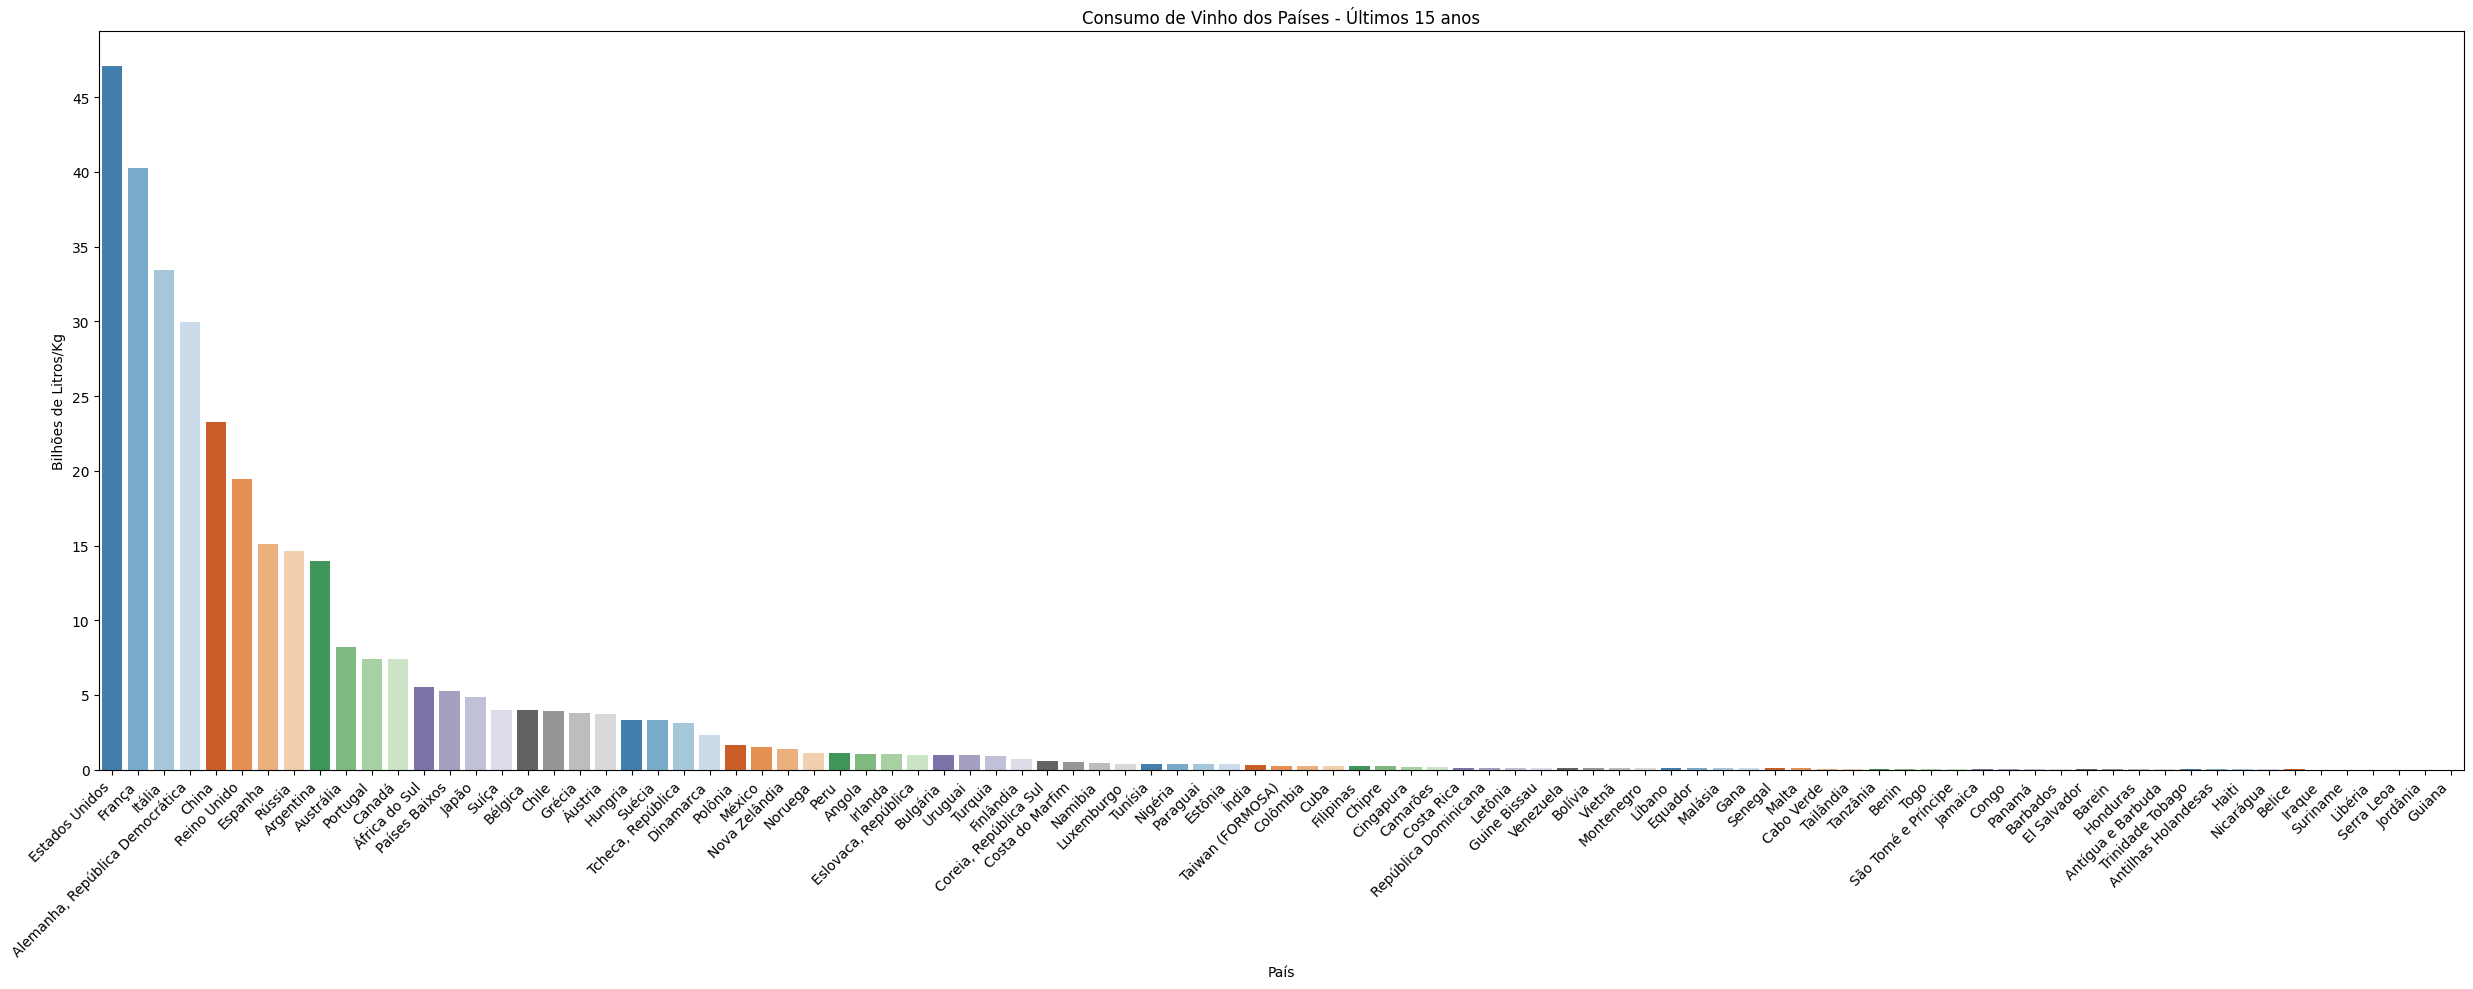

In [ ]:
# Gráfico de barras: Consumo por país
plt.figure(figsize=(25, 10))
sns.barplot(x='País', y='Quantidade', data=dados_consumo_resumo, palette='tab20c')

# Configurações do gráfico
plt.title('Consumo de Vinho dos Países - Últimos 15 anos')
plt.ylabel('Bilhões de Litros/Kg')
plt.xlabel('País')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos no eixo X
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

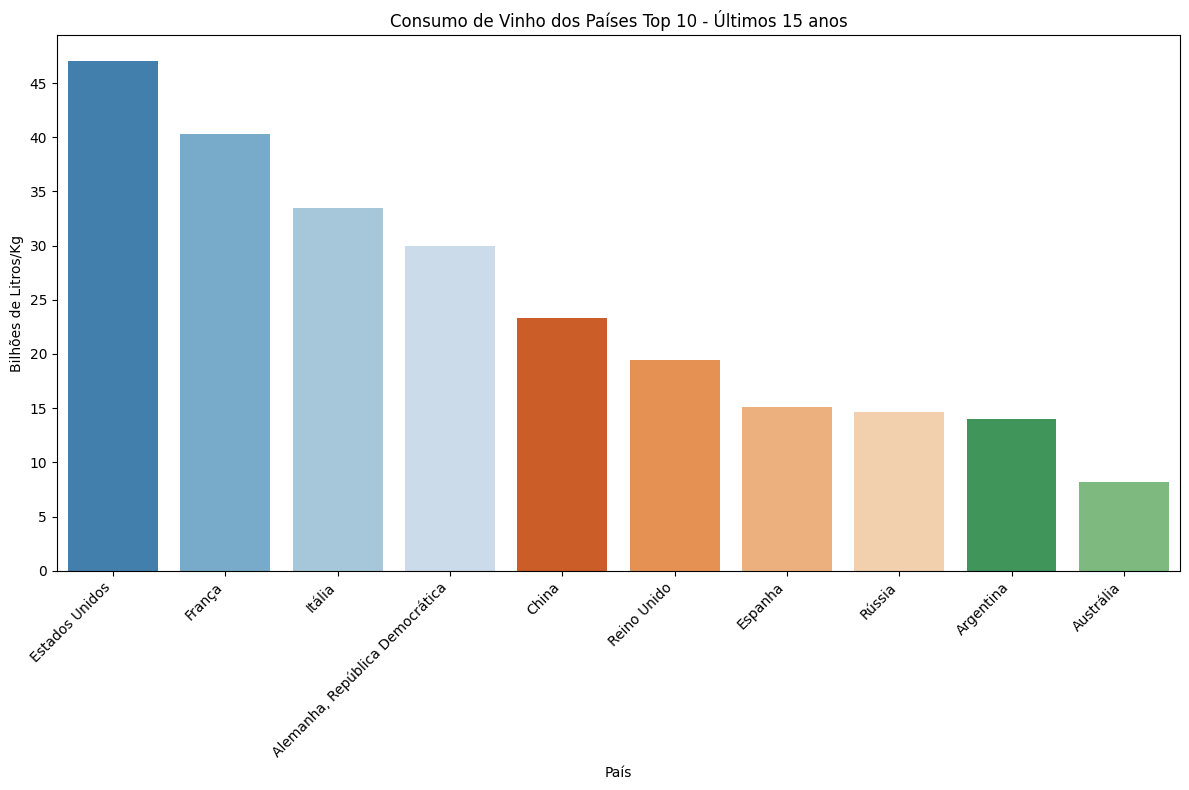

In [ ]:
# Gráfico de barras: Consumo por país
plt.figure(figsize=(12, 8))
sns.barplot(x='País', y='Quantidade', data=dados_consumo_resumo.head(10), palette='tab20c')

# Configurações do gráfico
plt.title('Consumo de Vinho dos Países Top 10 - Últimos 15 anos')
plt.ylabel('Bilhões de Litros/Kg')
plt.xlabel('País')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos no eixo X
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [ ]:
# Juntando os dados de consumo com nosso dataframe de dados agrupados
dados_agrupados_1 = pd.merge(dados_agrupados_1, dados_consumo, on=['País', 'Ano'], how='left')

In [ ]:
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao,%_part_importacao,Taxa_de_Cambio_Média_Anual,Continente,Produto,Variavel,Unidade,Quantidade
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09,NaN,0.054117,Africa,Wine,Consumption,1000 hl,4479.0
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.061102,Africa,Wine,Consumption,1000 hl,4561.0
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.067185,Africa,Wine,Consumption,1000 hl,3876.0
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11,NaN,0.060689,Africa,Wine,Consumption,1000 hl,2983.0
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10,NaN,0.069422,Africa,Wine,Consumption,1000 hl,3733.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,Wine,Consumption,1000 hl,84.0
1359,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,Wine,Consumption,1000 hl,119.0
1360,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,Wine,Consumption,1000 hl,113.0
1361,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08,NaN,NaN,Asia,Wine,Consumption,1000 hl,95.0


In [ ]:
# Ajustando o nome da coluna 'Quantidade' para melhor entendimento
dados_agrupados_1.rename(mapper={'Quantidade':'Consumo_Litros'},axis=1,inplace=True)

In [ ]:
# Convertendo o consumo em litros
# Unidade da fonte de origem 1.000 HL equivale a 100.000 litros de vinho.
dados_agrupados_1['Consumo_Litros']=dados_agrupados_1['Consumo_Litros']*100_000

In [ ]:
# Retirando colunas que não iremos utilizar
dados_agrupados_1.drop(columns=['Produto','Unidade', 'Variavel'],axis='columns', inplace=True)

In [ ]:
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao,%_part_importacao,Taxa_de_Cambio_Média_Anual,Continente,Consumo_Litros
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09,NaN,0.054117,Africa,447900000.0
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.061102,Africa,456100000.0
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.067185,Africa,387600000.0
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11,NaN,0.060689,Africa,298300000.0
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10,NaN,0.069422,Africa,373300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,8400000.0
1359,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,11900000.0
1360,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,11300000.0
1361,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08,NaN,NaN,Asia,9500000.0


##**Temperaturas Média Anual**

###Dados de temperatura média Anual (https://globaldatalab.org)##


In [ ]:
# Como o site não oferece nenhuma API para extração dos dados de consumo de vinho mundial, copiamos os dados e carregamos como string
dados_temperatura = '''Country,Continent,ISO_Code,Level,GDLCODE,Region,"1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021","2022"
"Afghanistan","Asia/Pacific","AFG","National","AFGt","Total",9.466,8.369,8.203,8.754,8.812,8.728,8.676,8.526,9.807,9.722,9.687,10.47,10.21,9.661,10.40,9.096,10.49,9.826,9.915,9.258,10.59,10.24,8.624,9.752,9.400,9.999,11.00,10.73,10.91,10.01,9.569,11.18,10.82
"Albania","Europe","ALB","National","ALBt","Total",12.91,11.64,12.28,12.38,13.45,12.09,12.20,12.39,12.69,13.04,12.86,12.81,12.89,12.96,12.49,11.84,12.10,13.17,13.03,13.09,13.01,12.90,13.31,13.43,13.40,13.49,13.43,13.36,13.97,13.79,13.60,13.39,13.75
"Algeria","Africa","DZA","National","DZAt","Total",18.30,17.00,17.02,17.71,18.56,18.15,17.64,18.45,18.13,18.80,18.43,18.99,18.63,18.69,18.18,18.20,18.80,18.28,18.33,18.51,18.91,18.47,18.68,18.23,19.05,18.69,19.17,19.00,18.36,18.70,19.31,19.77,19.83
"Andorra","Europe","AND","National","ANDt","Total",5.339,4.437,4.509,4.559,5.782,5.152,4.485,5.981,5.185,4.755,5.534,5.092,5.326,5.682,5.105,4.607,6.259,5.731,5.154,5.692,4.326,6.426,5.481,4.759,5.897,6.261,5.903,6.133,5.716,6.004,5.791,5.105,7.176
"Angola","Africa","AGO","National","AGOt","Total",22.45,22.27,22.03,22.27,22.24,22.53,22.39,22.41,23.07,22.27,22.21,22.23,22.39,22.57,22.23,22.56,22.13,22.42,22.35,22.70,22.77,22.30,22.59,22.71,22.77,22.97,23.19,22.99,23.06,23.47,23.07,23.09,22.69
"Antigua and Barbuda","America","ATG","National","ATGt","Total",25.92,25.81,25.92,25.94,25.76,26.24,25.85,26.19,26.57,26.08,25.88,26.15,26.24,26.31,26.12,26.56,26.33,26.32,25.90,26.11,26.77,26.23,26.27,26.14,26.09,26.30,26.42,26.30,26.03,26.32,26.48,26.29,26.19
"Argentina","America","ARG","National","ARGt","Total",15.30,15.12,14.62,15.05,15.72,15.36,15.34,15.76,15.32,15.09,14.71,15.44,15.25,15.71,15.56,15.31,15.93,14.88,15.77,15.93,15.29,15.52,16.03,15.81,15.85,15.94,15.36,15.99,15.78,15.83,16.09,15.97,15.60
"Armenia","Europe","ARM","National","ARMt","Total",6.870,6.755,4.679,5.260,6.460,6.805,7.152,6.412,7.846,7.814,7.193,7.895,6.980,6.629,6.852,7.093,7.486,6.798,7.249,7.034,9.215,6.535,7.607,7.307,8.049,8.001,7.138,7.332,8.975,8.043,7.855,8.436,8.193
"Australia","Asia/Pacific","AUS","National","AUSt","Total",19.24,19.16,18.61,18.99,18.84,18.66,18.87,19.01,19.38,18.97,18.70,18.81,19.27,19.21,19.10,19.60,19.09,19.46,19.00,19.60,18.95,18.64,18.82,19.78,19.66,19.41,19.61,19.51,19.64,19.87,19.43,18.99,19.01
"Austria","Europe","AUT","National","AUTt","Total",6.480,5.453,6.808,6.214,7.748,6.408,5.355,6.534,6.607,6.596,7.414,6.611,7.565,7.108,6.595,6.283,6.960,7.690,7.520,7.218,6.309,7.566,7.358,7.116,8.300,8.177,7.695,7.516,8.406,8.286,7.981,7.119,8.363
"Azerbaijan","Europe","AZE","National","AZEt","Total",11.42,11.29,9.862,9.724,10.60,11.81,11.44,11.13,12.08,11.96,11.67,12.09,11.49,10.95,11.70,12.01,11.96,11.69,11.66,11.81,13.30,11.03,12.29,11.98,12.39,12.28,11.72,12.01,12.83,12.46,12.18,12.73,12.56
"Bahamas, The","America","BHS","National","BHSt","Total",25.45,25.39,24.98,25.20,25.52,25.24,24.75,25.45,25.60,25.07,24.91,25.13,25.52,25.53,25.03,25.14,25.15,25.42,25.32,25.17,24.84,25.34,25.16,25.40,25.64,25.94,25.72,25.63,25.58,26.00,25.98,25.76,25.87
"Bahrain","Asia/Pacific","BHR","National","BHRt","Total",26.05,24.93,24.56,25.49,25.78,25.47,26.21,25.55,26.77,26.99,26.04,26.48,26.51,26.11,26.31,25.81,26.29,26.30,25.81,26.06,26.94,25.77,25.93,25.90,26.36,26.49,26.41,26.45,26.84,26.67,26.67,27.12,26.62
"Bangladesh","Asia/Pacific","BGD","National","BGDt","Total",24.96,25.02,25.06,24.85,25.20,25.36,25.33,24.76,25.33,25.54,25.00,25.20,25.21,25.20,25.31,25.63,25.81,25.27,25.44,25.96,26.02,25.26,25.33,25.30,25.45,25.46,25.93,25.58,25.35,25.77,25.40,25.85,25.80
"Barbados","America","BRB","National","BRBt","Total",26.18,26.01,26.19,26.24,25.99,26.49,26.28,26.40,26.85,26.35,26.12,26.21,26.38,26.43,26.45,26.86,26.57,26.54,26.24,26.49,27.02,26.57,26.51,26.48,26.27,26.43,26.74,26.59,26.27,26.54,26.69,26.53,26.35
"Belarus","Europe","BLR","National","BLRt","Total",7.721,6.775,7.039,5.985,6.732,7.026,5.626,6.350,6.511,7.756,7.915,7.129,7.713,6.644,6.772,6.821,6.878,7.847,8.066,7.147,7.003,7.543,6.859,7.578,7.810,8.636,7.761,7.666,7.938,8.870,9.100,7.297,7.839
"Belgium","Europe","BEL","National","BELt","Total",10.50,9.289,10.07,9.628,10.71,10.47,8.616,10.21,10.06,10.61,10.70,10.26,10.78,10.59,10.13,10.45,10.79,10.86,10.21,10.31,9.056,10.99,10.07,9.555,11.33,10.69,10.43,10.80,11.26,11.00,11.62,10.16,11.59
"Belize","America","BLZ","National","BLZt","Total",25.10,25.34,25.07,25.16,25.40,25.63,24.98,25.65,25.85,24.90,24.79,25.11,25.50,25.65,25.59,25.94,25.44,25.62,25.35,25.92,25.70,25.82,25.68,25.88,25.71,26.22,26.05,25.93,25.70,26.47,26.46,26.29,26.00
"Benin","Africa","BEN","National","BENt","Total",27.01,26.72,26.62,26.94,26.80,26.99,26.99,26.91,27.49,26.81,26.99,27.04,26.96,27.16,27.08,27.32,27.33,27.21,27.12,27.44,27.79,27.44,27.17,27.37,27.31,27.44,27.77,27.62,27.46,27.70,27.66,28.01,27.39
"Bhutan","Asia/Pacific","BTN","National","BTNt","Total",10.33,10.06,9.704,10.18,10.21,10.32,10.35,9.382,10.77,10.90,10.09,10.59,10.34,10.31,10.26,10.50,10.86,10.76,10.58,11.09,11.18,10.52,10.39,10.75,10.75,10.63,11.33,11.25,10.72,10.77,10.79,11.15,11.08
"Bolivia","America","BOL","National","BOLt","Total",17.39,17.61,17.15,17.36,17.95,17.86,17.35,17.89,17.99,17.31,17.43,17.68,18.17,17.96,17.81,17.92,18.11,17.99,17.73,18.11,18.47,18.19,18.21,18.00,18.28,18.60,18.46,18.45,18.01,18.48,18.73,18.16,18.08
"Bosnia and Herzegovina","Europe","BIH","National","BIHt","Total",10.04,8.657,9.810,9.263,10.51,9.343,8.700,9.424,9.739,10.04,11.07,10.07,10.80,10.28,9.950,9.139,10.04,10.95,10.99,10.72,10.11,10.57,10.82,10.80,11.39,10.94,10.72,10.59,11.13,11.35,11.09,10.72,11.61
"Botswana","Africa","BWA","National","BWAt","Total",21.72,20.93,22.34,21.79,21.20,22.21,21.00,21.11,21.88,21.72,20.43,21.14,22.00,22.44,21.34,22.48,20.69,21.55,21.28,20.98,21.71,20.99,21.80,22.03,21.21,22.93,22.75,21.42,22.23,22.98,21.58,21.11,21.34
"Brazil","America","BRA","National","BRAt","Total",24.26,24.08,24.00,24.38,24.32,24.30,24.11,24.33,24.89,24.12,23.98,24.40,24.67,24.55,24.35,24.63,24.44,24.57,24.26,24.49,24.75,24.27,24.71,24.59,24.67,25.15,25.04,24.85,24.65,25.08,24.61,24.48,24.21
"Brunei Darussalam","Asia/Pacific","BRN","National","BRNt","Total",26.11,25.99,25.92,25.87,26.10,26.12,25.95,26.18,26.69,26.05,26.18,26.24,26.38,26.26,26.13,26.26,26.16,26.16,26.01,26.49,26.48,26.27,26.38,26.46,26.24,26.54,26.96,26.62,26.71,26.93,26.81,26.55,26.41
"Bulgaria","Europe","BGR","National","BGRt","Total",11.37,9.985,10.80,10.59,12.06,10.69,10.25,10.17,11.05,11.71,11.87,11.58,11.57,10.85,11.19,10.70,11.06,12.29,11.91,11.82,11.75,10.93,12.00,12.12,11.88,12.07,12.05,11.65,12.05,12.66,12.36,11.67,12.25
"Burkina Faso","Africa","BFA","National","BFAt","Total",28.40,28.05,27.79,28.44,27.84,28.00,28.34,28.12,28.49,28.00,28.14,28.45,28.59,28.47,28.66,28.82,28.60,28.59,28.24,28.90,29.07,28.95,28.54,28.77,28.85,28.76,28.98,28.82,28.87,28.94,28.92,29.30,28.51
"Burundi","Africa","BDI","National","BDIt","Total",20.18,20.00,20.09,20.30,20.03,20.29,20.07,20.34,20.75,19.98,20.40,19.83,20.30,20.55,20.44,20.80,20.35,20.37,20.17,20.55,20.95,20.29,20.36,20.58,20.70,20.93,21.20,20.96,20.61,20.98,21.23,20.94,20.90
"Cabo Verde","Africa","CPV","National","CPVt","Total",23.17,22.54,22.74,22.49,22.32,23.26,23.16,23.37,23.52,22.56,22.87,23.20,23.04,23.16,23.23,23.57,23.39,22.90,23.12,22.86,23.96,23.33,22.97,23.04,22.63,22.74,23.17,23.35,22.31,22.81,23.45,23.08,23.25
"Cambodia","Asia/Pacific","KHM","National","KHMt","Total",27.55,27.41,27.29,26.86,27.13,27.37,27.10,27.42,28.18,26.73,27.19,27.56,28.08,27.84,27.73,27.66,27.69,27.42,27.19,27.30,28.17,27.48,28.09,27.81,27.79,28.32,28.32,27.76,27.88,28.28,27.95,27.49,27.50
"Cameroon","Africa","CMR","National","CMRt","Total",24.11,23.93,23.66,24.00,23.99,24.07,23.99,24.06,24.74,23.85,23.81,23.93,24.12,24.34,24.32,24.55,24.48,24.29,24.22,24.64,24.92,24.37,24.32,24.47,24.44,24.60,24.84,24.78,24.66,24.81,24.95,24.91,24.57
"Canada","America","CAN","National","CANt","Total",-0.359,0.002,-0.648,-0.410,-0.217,-0.179,-0.796,-0.185,1.376,1.247,0.097,1.125,-0.248,0.259,-0.321,0.945,1.728,0.138,0.038,0.016,2.081,0.714,1.278,0.182,-0.085,0.566,1.257,0.773,-0.041,0.022,0.678,1.457,0.600
"Central African Republic","Africa","CAF","National","CAFt","Total",25.90,25.47,24.97,25.21,25.31,25.44,25.35,25.41,26.02,25.15,25.18,25.28,25.54,25.80,25.83,26.02,25.74,25.65,25.46,25.90,25.97,25.47,25.51,25.82,25.88,26.05,26.28,26.24,26.00,26.36,26.45,26.58,26.23
"Chad","Africa","TCD","National","TCDt","Total",28.28,27.64,26.95,27.61,27.29,27.51,27.59,27.40,28.02,27.56,27.27,27.58,27.83,27.87,27.92,28.33,28.23,28.06,27.61,28.57,28.62,27.99,27.94,28.58,28.28,28.40,28.55,28.47,28.48,28.28,28.29,28.66,27.86
"Chile","America","CHL","National","CHLt","Total",9.395,9.326,9.092,9.495,9.859,9.587,9.480,9.909,10.06,9.628,9.191,9.535,9.272,9.873,9.827,9.486,9.948,8.968,9.767,9.654,9.240,9.456,9.815,9.763,9.611,10.09,10.35,9.816,9.798,10.20,10.16,9.977,9.418
"China","Asia/Pacific","CHN","National","CHNt","Total",12.51,12.20,12.00,12.01,12.77,12.34,12.06,12.54,13.27,12.91,12.47,12.74,12.98,12.73,12.85,12.55,13.11,13.24,12.66,12.89,12.60,12.35,12.26,12.91,12.92,13.11,13.17,13.27,13.03,13.27,13.19,13.44,13.25
"Colombia","America","COL","National","COLt","Total",22.28,22.46,22.43,22.28,22.23,22.42,22.00,22.64,22.86,21.90,22.09,22.39,22.70,22.68,22.68,22.90,22.71,22.74,22.52,22.95,23.13,22.74,22.85,23.02,23.16,23.45,23.51,23.22,23.06,23.38,23.43,22.98,22.79
"Comoros","Africa","COM","National","COMt","Total",25.40,25.37,25.28,25.21,25.33,25.39,25.09,25.49,25.80,25.30,25.33,25.45,25.56,25.64,25.44,25.54,25.44,25.73,25.25,25.64,25.89,25.60,25.52,25.62,25.76,25.90,25.71,25.86,25.71,26.09,25.92,25.69,25.46
"Congo, Dem. Rep.","Africa","COD","National","CODt","Total",23.49,23.30,23.20,23.29,23.24,23.44,23.29,23.52,24.08,23.18,23.24,23.32,23.55,23.66,23.69,23.86,23.58,23.62,23.56,23.84,24.16,23.77,23.76,24.04,24.05,24.20,24.56,24.25,24.17,24.39,24.54,24.55,24.27
"Congo, Rep.","Africa","COG","National","COGt","Total",24.27,24.35,24.03,24.23,24.26,24.41,24.10,24.40,25.09,24.30,24.13,24.21,24.57,24.77,24.64,24.82,24.68,24.75,24.63,24.75,25.09,24.74,24.76,24.87,24.85,25.05,25.39,25.02,25.08,25.31,25.33,25.27,25.02
"Costa Rica","America","CRI","National","CRIt","Total",22.36,22.25,22.31,22.10,22.25,22.17,21.81,22.19,22.54,21.46,21.70,21.95,22.42,22.42,22.40,22.51,22.40,22.40,22.17,22.50,22.63,22.29,22.35,22.51,22.60,22.82,22.86,22.60,22.40,22.77,22.77,22.30,22.22
"Cote d'Ivoire","Africa","CIV","National","CIVt","Total",26.08,25.99,25.85,26.02,26.00,25.98,25.80,26.00,26.56,25.74,25.90,26.00,26.19,26.43,26.38,26.46,26.47,26.55,26.40,26.45,26.78,26.37,26.32,26.47,26.45,26.50,26.89,26.70,26.48,26.70,26.79,26.81,26.47
"Croatia","Europe","HRV","National","HRVt","Total",12.06,10.91,12.19,11.40,12.70,11.65,10.65,11.46,11.77,11.97,13.03,12.13,12.63,12.22,11.65,11.05,11.97,12.81,12.70,12.59,11.66,12.36,12.69,12.30,13.10,12.81,12.46,12.56,13.11,13.24,12.87,12.50,13.30
"Cuba","America","CUB","National","CUBt","Total",25.52,25.47,25.05,25.09,25.48,25.42,24.99,25.95,26.10,25.11,25.15,25.17,25.53,25.72,25.40,25.20,25.39,25.49,25.41,25.39,24.95,25.40,25.25,25.58,25.57,25.98,25.72,25.64,25.59,26.07,26.14,25.86,25.82
"Cyprus","Europe","CYP","National","CYPt","Total",18.62,18.35,17.31,18.36,19.22,18.59,18.79,18.34,19.56,19.81,19.19,19.76,19.42,19.33,19.07,18.80,18.71,19.29,19.53,19.45,20.29,18.84,19.34,19.38,19.37,19.28,19.93,19.57,20.51,19.80,19.69,19.96,19.31
"Czechia","Europe","CZE","National","CZEt","Total",8.591,7.330,8.653,7.768,9.095,8.086,6.440,7.783,8.472,8.628,9.368,8.005,8.907,8.682,8.264,8.074,8.586,9.337,9.152,8.674,7.420,8.849,8.699,8.307,9.858,9.785,9.050,8.917,9.991,9.970,9.564,8.431,9.636
"Denmark","Europe","DNK","National","DNKt","Total",9.569,8.353,9.138,7.867,8.854,8.539,7.062,8.683,8.409,9.082,9.408,8.451,9.276,8.752,8.766,8.852,9.500,9.568,9.546,8.939,7.100,9.027,8.450,8.520,10.16,9.337,9.291,9.155,9.738,9.759,10.16,9.024,9.732
"Djibouti","Africa","DJI","National","DJIt","Total",28.84,28.40,28.01,28.26,27.96,28.15,28.13,28.31,28.78,28.53,28.26,28.23,28.46,28.44,28.60,28.60,28.34,28.46,28.06,28.38,28.32,28.07,28.08,28.26,28.17,28.71,28.96,28.96,28.46,28.66,28.66,28.57,28.69
"Dominica","America","DMA","National","DMAt","Total",25.39,25.31,25.44,25.46,25.24,25.69,25.38,25.62,26.08,25.60,25.32,25.54,25.69,25.79,25.69,26.13,25.86,25.83,25.47,25.72,26.33,25.79,25.82,25.67,25.60,25.83,26.03,25.89,25.56,25.85,25.98,25.83,25.70
"Dominican Republic","America","DOM","National","DOMt","Total",23.82,23.77,23.63,23.68,23.81,23.90,23.39,24.31,24.20,23.45,23.66,23.88,24.03,24.01,23.77,24.10,24.11,24.14,23.80,23.99,24.29,23.92,23.98,24.13,24.31,24.62,24.43,24.30,24.23,24.57,24.69,24.28,24.27
"Ecuador","America","ECU","National","ECUt","Total",20.66,20.91,20.94,20.87,20.60,20.50,19.98,21.40,21.15,19.83,20.00,20.14,20.49,20.33,20.67,20.85,21.14,20.59,20.98,21.24,21.06,21.02,21.10,20.90,21.28,21.97,21.66,21.27,21.15,21.36,21.32,21.12,20.84
"Egypt, Arab Rep.","Africa","EGY","National","EGYt","Total",21.48,21.30,20.75,21.58,21.85,21.61,21.90,21.61,22.46,22.45,21.64,22.26,22.39,22.11,22.05,22.00,21.99,22.24,22.62,22.58,23.68,21.95,22.49,22.50,22.84,22.74,23.21,22.64,23.54,22.77,22.76,23.14,22.44
"El Salvador","America","SLV","National","SLVt","Total",25.75,25.76,25.73,25.41,25.85,25.28,25.03,25.98,25.87,24.76,25.18,25.43,25.93,25.68,25.75,25.57,25.65,25.51,25.10,25.99,25.56,25.56,25.86,26.01,26.17,26.80,26.53,26.17,26.30,26.64,26.27,26.46,26.09
"Equatorial Guinea","Africa","GNQ","National","GNQt","Total",23.43,23.38,23.28,23.54,23.57,23.70,23.42,23.60,24.20,23.44,23.43,23.47,23.76,23.91,23.89,23.96,23.88,23.90,23.89,24.01,24.27,24.01,23.98,24.08,24.16,24.21,24.58,24.55,24.43,24.59,24.68,24.54,24.33
"Eritrea","Africa","ERI","National","ERIt","Total",25.14,25.10,24.13,24.56,24.81,24.87,24.75,24.76,25.14,25.07,24.88,24.95,25.32,25.19,25.23,24.99,24.98,24.66,24.91,25.59,25.32,24.82,25.14,25.43,25.07,25.81,25.62,25.74,25.37,25.43,25.24,25.53,25.40
"Estonia","Europe","EST","National","ESTt","Total",6.752,6.261,6.472,5.121,5.273,6.225,4.627,5.840,5.391,6.445,6.987,5.992,6.260,5.709,5.919,5.977,6.503,6.727,7.210,5.924,4.894,6.830,5.269,6.619,6.798,7.368,6.411,6.278,6.982,7.303,8.198,6.421,6.864
"Eswatini","Africa","SWZ","National","SWZt","Total",18.92,19.25,20.36,19.48,18.81,18.81,18.80,18.74,19.52,19.46,18.71,19.25,19.39,19.94,19.36,19.71,19.16,19.39,19.22,19.24,19.85,19.44,19.64,19.23,19.44,20.47,20.35,19.58,19.53,20.09,19.54,19.26,19.62
"Ethiopia","Africa","ETH","National","ETHt","Total",22.36,22.35,22.07,22.08,22.49,22.61,22.18,22.47,22.87,22.41,22.15,22.18,22.76,22.53,22.47,22.79,22.63,22.63,22.47,23.27,22.73,22.60,22.80,22.64,22.77,23.41,23.43,23.22,22.79,23.14,22.96,23.00,23.21
"Fiji","Asia/Pacific","FJI","National","FJIt","Total",24.13,24.02,23.92,23.58,23.59,24.11,24.22,23.79,24.33,24.22,24.40,24.33,24.49,24.09,24.25,24.32,24.23,24.87,24.56,23.90,24.66,24.45,24.26,24.60,24.21,24.00,24.70,24.77,24.62,24.72,24.98,24.94,25.08
"Finland","Europe","FIN","National","FINt","Total",5.199,4.588,4.892,4.022,3.887,4.627,3.570,4.609,3.802,4.767,5.629,4.350,4.608,4.386,4.657,5.123,5.130,5.275,5.668,4.573,3.286,5.565,4.189,5.434,5.799,6.109,5.158,4.947,5.541,5.446,6.850,4.921,5.599
"France","Europe","FRA","National","FRAt","Total",13.00,12.00,12.41,12.12,13.23,12.84,11.88,13.01,12.60,12.93,13.06,12.74,13.14,13.40,12.70,12.70,13.21,12.99,12.62,12.99,12.06,13.60,12.83,12.45,13.68,13.51,13.06,13.32,13.78,13.62,14.02,12.87,14.26
"French Polynesia","Asia/Pacific","PYF","National","PYFt","Total",25.56,25.74,25.64,25.61,25.72,25.70,25.37,25.55,25.89,25.52,25.43,25.55,25.88,25.88,25.74,25.78,25.79,25.77,25.32,25.79,25.62,25.07,25.76,25.49,25.64,25.80,26.21,25.93,25.68,25.88,25.80,25.57,25.17
"Gabon","Africa","GAB","National","GABt","Total",24.11,24.17,23.96,24.27,24.20,24.43,24.03,24.30,25.00,24.22,24.14,24.15,24.64,24.78,24.59,24.68,24.61,24.73,24.60,24.66,25.02,24.80,24.81,24.93,24.91,25.02,25.42,25.22,25.13,25.30,25.38,25.20,25.03
"Gambia, The","Africa","GMB","National","GMBt","Total",27.26,27.16,27.15,27.27,27.15,27.50,27.37,27.53,27.94,26.96,27.31,27.42,27.71,27.24,27.28,27.80,27.35,27.36,27.44,27.17,27.99,27.59,27.59,27.69,27.51,27.45,27.85,28.00,27.32,27.50,28.10,27.96,27.58
"Georgia","Europe","GEO","National","GEOt","Total",7.832,8.052,6.221,6.433,7.556,7.699,8.001,7.309,8.841,8.375,7.733,8.385,8.002,7.410,7.934,8.198,8.325,8.263,8.287,8.530,10.34,7.581,8.877,8.518,9.335,9.331,8.693,8.835,10.08,9.418,9.345,9.301,8.962
"Germany","Europe","DEU","National","DEUt","Total",9.663,8.439,9.432,8.505,9.754,9.057,7.270,9.029,9.169,9.691,10.01,9.118,9.677,9.541,9.181,9.307,9.864,10.15,9.780,9.458,8.055,9.884,9.283,8.926,10.58,10.14,9.775,9.819,10.68,10.55,10.71,9.396,10.70
"Ghana","Africa","GHA","National","GHAt","Total",26.84,26.60,26.56,26.84,26.75,26.83,26.64,26.86,27.50,26.59,26.87,26.94,27.04,27.17,27.09,27.20,27.23,27.23,27.16,27.42,27.69,27.32,27.18,27.35,27.29,27.51,27.81,27.66,27.53,27.82,27.77,27.89,27.32
"Gibraltar","Europe","GIB","National","GIBt","Total",17.95,17.22,17.23,17.09,17.77,17.83,17.34,17.96,17.57,17.33,17.55,17.66,17.61,17.58,17.46,17.20,17.80,17.47,17.56,17.85,17.81,18.03,17.57,17.54,18.00,18.18,18.16,18.19,17.40,17.74,18.15,17.89,18.33
"Greece","Europe","GRC","National","GRCt","Total",15.45,14.44,14.66,14.98,15.94,15.06,14.84,14.77,15.48,15.91,15.45,15.75,15.53,15.42,15.38,15.12,15.10,15.98,15.98,15.89,16.35,15.26,16.11,16.25,16.16,15.86,16.19,15.85,16.49,16.35,16.24,16.22,16.09
"Greenland","America","GRL","National","GRLt","Total",-19.21,-19.09,-20.36,-19.84,-19.33,-18.60,-17.66,-18.47,-17.99,-19.00,-18.38,-18.18,-17.92,-17.30,-18.15,-17.14,-18.17,-18.34,-18.29,-18.87,-15.79,-19.03,-17.31,-18.61,-17.97,-19.49,-16.46,-17.74,-18.27,-16.96,-18.28,-16.83,-17.12
"Grenada","America","GRD","National","GRDt","Total",26.14,25.99,26.16,26.20,26.03,26.45,26.32,26.42,26.82,26.39,26.16,26.26,26.46,26.52,26.52,26.95,26.65,26.63,26.37,26.59,27.01,26.63,26.61,26.58,26.43,26.55,26.84,26.68,26.43,26.71,26.84,26.65,26.48
"Guatemala","America","GTM","National","GTMt","Total",21.36,21.63,21.53,21.56,21.66,21.79,21.36,21.99,22.33,21.20,21.37,21.43,21.91,22.04,21.69,22.04,21.77,21.91,21.58,22.24,22.23,22.24,22.10,22.37,22.26,22.68,22.68,22.44,22.32,22.92,22.85,22.69,22.45
"Guinea","Africa","GIN","National","GINt","Total",25.78,25.70,25.43,25.63,25.40,25.69,25.85,25.75,26.21,25.52,25.60,25.79,26.06,25.98,26.04,26.06,25.95,25.91,25.74,25.87,26.14,25.86,25.61,25.87,25.80,25.89,26.16,26.29,26.09,26.37,26.57,26.60,26.13
"Guinea-Bissau","Africa","GNB","National","GNBt","Total",27.31,27.17,27.06,27.19,26.83,27.51,27.37,27.43,27.88,27.09,27.22,27.35,27.48,27.32,27.35,27.70,27.36,27.37,27.33,27.07,27.67,27.31,27.20,27.21,27.06,27.15,27.45,27.54,27.05,27.57,27.87,27.83,27.47
"Guyana","America","GUY","National","GUYt","Total",25.26,25.11,25.22,25.08,25.08,25.56,25.31,25.58,25.92,25.22,25.00,25.26,25.44,25.62,25.57,25.86,25.46,25.30,25.18,25.62,25.72,25.56,25.51,25.44,25.48,25.68,25.98,25.85,25.50,25.83,25.90,25.55,25.44
"Haiti","America","HTI","National","HTIt","Total",25.21,25.15,24.91,24.81,24.87,24.90,24.48,25.46,25.41,24.56,24.74,24.99,25.20,25.20,24.83,25.10,25.24,25.31,24.95,25.09,25.25,25.05,25.11,25.37,25.56,25.87,25.55,25.39,25.45,25.71,25.86,25.49,25.41
"Honduras","America","HND","National","HNDt","Total",23.32,23.54,23.40,23.20,23.45,23.44,22.85,23.52,23.83,22.66,22.73,22.93,23.44,23.46,23.38,23.59,23.46,23.39,23.19,23.58,23.42,23.48,23.42,23.76,23.71,24.18,24.10,23.80,23.68,24.32,24.24,24.14,23.84
"Hungary","Europe","HUN","National","HUNt","Total",11.20,9.861,11.35,10.48,11.95,10.75,9.571,10.17,10.63,10.86,12.01,10.76,11.74,10.82,10.58,10.20,10.97,12.12,11.86,11.75,10.59,11.20,11.82,11.50,12.38,12.09,11.50,11.50,12.42,12.56,11.93,11.36,12.34
"Iceland","Europe","ISL","National","ISLt","Total",1.039,1.921,1.000,1.005,0.892,0.509,1.753,1.679,0.992,1.192,1.505,1.749,2.115,2.781,2.533,1.723,2.301,2.091,1.833,2.154,2.267,1.919,2.190,1.808,3.004,1.488,2.890,2.719,2.202,2.124,1.634,1.946,1.777
"India","Asia/Pacific","IND","National","INDt","Total",22.15,22.23,22.12,22.29,22.31,22.41,22.31,21.90,22.60,22.60,22.29,22.42,22.66,22.47,22.52,22.53,22.81,22.64,22.44,23.02,23.00,22.44,22.50,22.47,22.64,22.79,23.23,23.08,22.79,22.86,22.68,22.84,22.95
"Indonesia","Asia/Pacific","IDN","National","IDNt","Total",25.00,24.86,24.84,24.99,24.96,25.10,25.08,25.22,25.68,24.99,25.03,25.11,25.33,25.31,25.33,25.39,25.31,25.30,25.14,25.52,25.64,25.30,25.37,25.49,25.53,25.64,25.99,25.64,25.65,25.79,25.85,25.66,25.58
"Iran, Islamic Rep.","Asia/Pacific","IRN","National","IRNt","Total",15.42,15.26,13.81,14.87,15.55,15.79,15.51,15.46,16.29,16.45,16.12,16.82,16.31,16.05,16.27,16.12,16.43,15.95,16.18,16.20,17.57,16.01,16.13,16.49,16.39,16.97,16.88,16.84,17.31,16.51,16.24,17.64,17.27
"Iraq","Asia/Pacific","IRQ","National","IRQt","Total",22.80,22.60,21.09,22.28,23.24,22.81,23.65,22.32,23.89,24.13,23.46,23.93,23.39,23.38,23.34,23.43,23.59,23.55,23.66,23.42,24.95,22.72,23.66,23.00,23.69,23.82,23.72,23.93,24.27,23.63,24.03,24.86,24.28
"Ireland","Europe","IRL","National","IRLt","Total",10.12,9.614,9.560,9.393,9.704,10.29,9.298,10.41,10.14,10.10,9.750,9.642,10.10,10.14,10.05,10.20,10.28,10.46,9.726,9.693,8.707,9.992,9.680,9.707,10.23,9.609,9.903,10.22,10.05,10.09,10.04,10.25,10.52
"Isle of Man","Europe","IMN","National","IMNt","Total",10.55,9.851,10.15,9.660,9.979,10.47,9.601,10.65,10.63,10.60,10.32,10.01,10.63,10.66,10.61,10.62,10.67,10.95,10.24,10.31,9.425,10.52,10.02,9.770,10.89,10.20,10.58,10.73,10.27,10.64,10.63,10.52,11.15
"Israel","Asia/Pacific","ISR","National","ISRt","Total",19.25,19.20,18.23,19.26,19.81,19.38,19.90,19.32,20.40,20.30,19.66,20.30,20.22,20.04,19.86,19.74,19.63,20.01,20.31,20.40,21.77,19.80,20.50,20.31,20.41,20.34,20.84,20.52,21.36,20.62,20.86,21.15,20.45
"Italy","Europe","ITA","National","ITAt","Total",11.99,11.14,11.89,11.79,12.74,11.68,11.50,12.34,12.23,12.22,12.64,12.42,12.49,12.64,12.12,11.56,12.30,12.70,12.57,12.57,11.88,12.73,12.76,12.39,13.04,13.09,12.87,12.81,13.16,13.06,13.04,12.73,13.68
"Jamaica","America","JAM","National","JAMt","Total",25.54,25.46,25.39,25.23,25.44,25.41,24.85,25.42,25.88,25.09,25.10,25.41,25.60,25.69,25.55,25.55,25.79,25.66,25.32,25.69,25.57,25.43,25.56,25.80,25.91,26.17,26.09,26.08,26.08,26.43,26.48,26.21,26.07
"Japan","Asia/Pacific","JPN","National","JPNt","Total",13.55,12.97,12.63,12.20,13.31,12.35,12.08,12.75,13.53,13.09,12.93,12.66,12.97,12.72,13.60,12.72,13.00,13.39,13.08,13.17,13.37,12.87,12.68,13.11,12.80,13.51,13.74,12.94,13.61,13.72,13.78,13.75,13.67
"Jersey","Europe","JEY","National","JEYt","Total",12.62,11.18,11.67,11.54,12.20,12.37,11.26,12.04,12.03,12.44,12.09,12.02,12.51,12.30,12.21,12.41,12.26,12.56,12.10,11.99,11.11,12.55,11.95,11.58,12.91,12.43,12.31,12.65,12.50,12.63,12.91,12.19,13.26
"Jordan","Asia/Pacific","JOR","National","JORt","Total",18.60,18.52,17.37,18.59,19.06,18.73,19.34,18.47,19.76,19.59,19.01,19.66,19.25,19.20,19.15,18.97,18.91,19.31,19.50,19.52,21.23,18.93,19.85,19.44,19.68,19.68,20.11,19.95,20.51,19.88,20.28,20.53,19.97
"Kazakhstan","Asia/Pacific","KAZ","National","KAZt","Total",6.640,6.505,5.749,4.653,5.614,7.236,5.079,7.156,6.101,6.791,6.596,6.651,7.396,6.016,7.433,7.105,7.099,7.438,7.263,6.513,6.618,5.934,6.145,7.773,5.845,7.552,7.387,7.237,5.975,7.418,7.530,7.299,7.556
"Kenya","Africa","KEN","National","KENt","Total",22.08,22.32,22.25,22.21,22.49,22.55,22.51,22.61,22.46,22.39,22.59,22.42,22.65,22.79,22.77,23.08,22.83,22.78,22.74,23.20,22.94,22.97,22.83,22.70,22.96,23.24,23.25,23.39,22.73,23.41,22.97,23.19,23.11
"Kiribati","Asia/Pacific","KIR","National","KIRt","Total",27.01,27.13,26.93,26.89,27.02,26.84,26.52,26.95,26.54,25.92,26.15,26.69,27.15,27.18,27.14,27.04,26.95,26.58,26.12,27.00,26.57,26.29,26.71,26.90,27.17,27.41,27.21,26.94,27.18,27.38,26.99,26.57,26.37
"Korea, Rep.","Asia/Pacific","KOR","National","KORt","Total",13.14,12.28,12.54,11.95,13.34,12.17,12.12,12.71,13.56,12.92,12.55,12.80,12.71,12.62,13.36,12.41,13.00,13.32,13.04,13.04,12.68,12.39,12.33,12.90,13.13,13.43,13.67,13.13,13.03,13.52,13.28,13.68,13.25
"Kosovo","Europe","XKO","National","XKOt","Total",10.34,9.032,9.926,9.860,10.95,9.507,9.639,9.628,10.03,10.39,10.75,10.21,10.59,10.31,10.04,9.417,9.740,11.06,11.00,10.77,10.98,10.53,11.32,11.24,11.36,11.16,10.93,10.86,11.37,11.48,11.01,10.44,11.04
"Kuwait","Asia/Pacific","KWT","National","KWTt","Total",25.91,25.40,24.15,25.44,25.85,25.39,26.15,25.20,26.52,26.62,25.99,26.52,26.26,26.25,26.11,25.99,26.35,26.18,26.10,26.11,27.43,25.78,26.34,25.99,26.56,26.83,26.77,26.91,27.29,26.84,26.94,27.67,27.13
"Kyrgyz Republic","Asia/Pacific","KGZ","National","KGZt","Total",2.239,1.605,1.557,1.086,1.406,1.576,1.068,2.568,2.450,2.027,1.858,2.220,2.567,1.749,2.503,1.997,2.680,2.658,2.250,1.934,2.500,2.071,1.422,2.599,1.599,2.596,3.020,2.169,1.984,2.636,1.985,2.429,3.033
"Lao PDR","Asia/Pacific","LAO","National","LAOt","Total",22.77,23.03,22.46,22.45,22.74,22.67,22.47,22.79,23.63,22.63,22.65,22.97,23.03,23.09,22.68,23.07,23.19,23.02,22.40,23.08,23.59,22.43,23.52,23.10,23.20,23.62,23.61,23.42,23.26,24.11,23.77,23.40,23.33
"Latvia","Europe","LVA","National","LVAt","Total",7.464,6.744,6.970,5.758,6.031,6.633,5.061,6.313,6.061,7.174,7.569,6.575,7.012,6.351,6.352,6.314,7.020,7.273,7.705,6.495,5.624,7.201,6.046,6.900,7.296,7.749,7.046,6.796,7.545,8.093,8.679,6.900,7.334
"Lebanon","Asia/Pacific","LBN","National","LBNt","Total",15.71,15.60,14.25,15.46,16.20,15.71,16.23,15.50,16.75,16.88,16.19,17.01,16.53,16.36,16.14,15.84,15.88,16.28,16.52,16.44,18.04,15.92,16.58,16.55,16.83,16.55,17.15,16.92,17.69,16.94,17.36,17.54,16.83
"Lesotho","Africa","LSO","National","LSOt","Total",10.75,11.04,11.62,11.26,10.43,11.10,10.21,10.53,11.49,11.76,10.80,10.98,11.11,11.75,11.49,11.85,10.81,11.46,11.62,11.34,12.10,10.81,11.37,11.82,11.77,12.78,12.46,11.96,11.90,13.16,11.83,11.46,11.73
"Liberia","Africa","LBR","National","LBRt","Total",25.05,24.87,24.72,24.90,24.84,25.11,24.86,24.95,25.44,24.83,24.76,24.84,25.00,25.13,25.13,25.19,25.18,25.21,25.10,25.11,25.31,25.02,24.96,25.21,25.06,25.27,25.68,25.61,25.45,25.80,25.84,25.72,25.59
"Libya","Africa","LBY","National","LBYt","Total",21.85,21.41,20.96,21.69,21.61,21.81,22.03,21.80,21.96,22.34,21.49,22.25,22.09,22.03,21.95,22.16,22.11,22.34,22.42,22.35,23.74,21.67,22.18,22.60,22.69,22.00,23.00,21.56,23.34,22.35,22.40,23.12,22.45
"Liechtenstein","Europe","LIE","National","LIEt","Total",5.452,4.613,5.474,5.200,6.862,5.351,4.699,6.098,5.381,5.488,6.174,5.699,6.407,6.289,5.770,5.349,6.126,6.424,6.333,6.540,5.459,7.227,6.320,5.813,7.639,7.159,6.758,6.403,7.468,7.114,7.222,5.887,7.386
"Lithuania","Europe","LTU","National","LTUt","Total",8.020,7.087,7.488,6.316,6.861,7.014,5.443,6.830,6.710,7.719,8.116,7.111,7.752,6.912,6.792,6.862,7.372,7.772,8.194,7.067,6.256,7.610,6.756,7.444,7.912,8.302,7.636,7.523,8.111,8.815,9.150,7.269,7.878
"Luxembourg","Europe","LUX","National","LUXt","Total",9.403,8.356,9.168,8.625,9.844,9.382,7.671,9.146,8.930,9.485,9.782,9.262,9.787,9.732,9.003,9.393,9.796,9.850,9.160,9.371,8.225,10.01,9.146,8.588,10.39,9.863,9.347,9.703,10.46,10.08,10.70,9.125,10.73
"Madagascar","Africa","MDG","National","MDGt","Total",21.69,21.62,21.40,21.43,21.56,21.77,21.59,21.70,22.01,21.64,21.68,21.91,21.92,21.94,21.91,21.94,22.16,22.00,21.74,22.10,22.35,22.17,22.01,22.00,22.17,22.20,22.07,22.37,22.10,22.58,22.29,22.29,21.89
"Malawi","Africa","MWI","National","MWIt","Total",22.40,22.08,22.81,22.33,22.33,22.69,22.27,22.17,22.57,21.87,21.90,22.32,22.32,22.12,21.88,22.74,22.20,22.20,21.95,22.18,22.59,22.48,22.37,22.42,22.53,22.87,23.01,22.66,22.62,22.72,22.82,22.58,22.27
"Malaysia","Asia/Pacific","MYS","National","MYSt","Total",26.07,25.87,25.84,25.77,25.87,25.98,25.84,26.06,26.78,25.83,25.99,26.11,26.50,26.34,26.34,26.63,26.21,26.12,25.96,26.33,26.60,26.16,26.22,26.42,26.43,26.62,27.13,26.56,26.56,26.92,26.82,26.52,26.48
"Mali","Africa","MLI","National","MLIt","Total",28.57,28.38,27.97,28.57,27.81,28.10,28.55,28.24,28.79,27.80,28.23,28.56,28.95,28.85,29.01,29.02,28.45,28.64,28.24,28.82,29.42,28.94,28.34,28.78,28.71,28.67,29.13,29.06,29.01,28.86,29.08,29.61,28.72
"Mauritania","Africa","MRT","National","MRTt","Total",28.66,28.11,27.98,28.03,27.90,28.14,28.47,28.52,28.93,27.91,28.43,28.97,28.66,28.62,28.53,28.84,28.47,28.39,28.51,28.59,29.60,28.79,28.21,28.77,28.73,28.93,29.20,29.12,28.27,28.44,29.38,29.51,28.79
"Mauritius","Africa","MUS","National","MUSt","Total",24.04,24.19,23.75,23.78,24.08,24.00,23.76,23.99,24.27,23.85,23.78,24.13,24.31,24.54,24.31,24.33,24.36,24.29,24.21,24.59,24.62,24.44,24.33,24.54,24.77,24.83,24.57,24.74,24.65,24.96,24.48,24.50,24.13
"Mexico","America","MEX","National","MEXt","Total",20.43,20.36,20.06,20.43,20.89,20.92,20.60,20.42,21.04,20.49,20.65,20.54,20.72,20.79,20.36,20.90,20.82,20.64,20.57,21.07,20.34,21.07,20.96,20.78,20.81,20.99,21.06,21.12,20.89,21.33,21.43,21.06,20.91
"Micronesia, Fed. Sts.","Asia/Pacific","FSM","National","FSMt","Total",27.01,26.83,26.78,26.70,26.95,27.11,27.07,26.91,27.17,26.83,26.91,27.04,27.03,27.13,27.12,27.14,27.09,27.15,26.85,27.15,27.14,26.99,27.07,27.29,27.31,27.19,27.57,27.50,27.39,27.38,27.48,27.30,27.16
"Moldova","Europe","MDA","National","MDAt","Total",11.05,9.219,9.776,9.079,10.89,9.674,8.767,8.985,9.871,10.76,11.03,10.07,10.58,9.619,10.16,10.17,9.887,11.76,11.12,11.09,10.55,10.27,11.04,11.08,10.80,11.79,11.17,11.02,10.97,11.90,12.22,10.19,11.38
"Monaco","Europe","MCO","National","MCOt","Total",14.65,13.93,14.40,14.07,14.88,14.27,13.81,14.81,14.40,14.49,14.71,14.64,14.63,14.96,14.42,14.10,14.85,14.68,14.45,14.91,13.81,15.05,14.79,14.45,15.33,15.48,15.22,15.22,15.61,15.53,15.46,15.18,16.38
"Mongolia","Asia/Pacific","MNG","National","MNGt","Total",0.621,0.024,0.304,-0.211,0.640,0.866,-0.200,1.267,1.376,0.918,0.241,0.748,1.172,0.045,1.081,0.167,1.002,2.284,1.268,0.605,-0.197,0.137,-0.599,0.741,1.170,1.534,0.634,1.655,0.973,1.357,1.211,1.484,0.791
"Montenegro","Europe","MNE","National","MNEt","Total",11.01,9.744,10.47,10.61,11.62,10.29,10.32,10.53,10.80,11.32,11.39,11.14,11.42,11.19,10.85,10.14,10.53,11.64,11.55,11.54,11.37,11.53,11.79,11.81,12.01,12.01,11.75,11.57,12.33,12.22,12.07,11.61,12.19
"Morocco","Africa","MAR","National","MARt","Total",18.00,16.96,16.99,16.74,17.97,18.18,17.52,18.14,18.24,17.80,18.13,18.71,18.21,18.31,17.92,18.13,18.27,17.90,17.78,18.41,18.82,18.25,18.19,18.08,18.39,18.48,18.73,19.28,17.60,18.47,19.19,18.76,19.47
"Mozambique","Africa","MOZ","National","MOZt","Total",23.63,23.57,24.28,23.72,23.41,23.81,23.43,23.45,23.91,23.32,23.21,23.72,23.81,23.76,23.63,24.28,23.84,23.85,23.69,23.75,24.21,23.84,23.83,23.64,23.71,24.28,24.48,23.85,24.05,24.36,24.28,23.97,23.99
"Myanmar","Asia/Pacific","MMR","National","MMRt","Total",24.24,24.49,23.86,24.23,24.47,24.67,24.44,24.25,25.25,24.69,24.26,24.51,24.59,24.61,24.47,24.99,24.57,24.40,24.42,24.86,25.27,24.36,24.79,24.77,24.91,24.89,25.09,24.93,24.68,25.15,25.19,25.24,25.04
"Namibia","Africa","NAM","National","NAMt","Total",21.94,21.33,22.18,21.90,21.72,22.30,21.71,21.55,22.74,22.00,21.55,21.48,22.01,22.33,21.96,22.72,20.99,22.37,21.72,21.78,22.07,20.86,21.63,22.62,21.96,23.08,23.30,22.37,22.85,23.89,22.54,21.83,22.14
"Nepal","Asia/Pacific","NPL","National","NPLt","Total",12.91,12.79,12.72,13.11,13.20,13.04,13.06,12.06,13.39,13.62,12.79,13.16,12.95,12.92,13.18,13.19,13.65,13.33,13.23,13.75,13.85,13.00,12.85,13.20,13.02,13.18,14.07,13.74,13.39,13.13,12.99,13.59,13.72
"Netherlands","Europe","NLD","National","NLDt","Total",10.74,9.443,10.43,9.536,10.54,10.32,8.425,10.11,10.23,10.80,10.81,10.30,10.73,10.42,10.36,10.57,11.05,11.13,10.52,10.44,8.985,10.79,10.16,9.687,11.57,10.76,10.66,10.86,11.25,11.17,11.57,10.36,11.53
"New Zealand","Asia/Pacific","NZL","National","NZLt","Total",11.66,10.81,10.19,10.50,10.84,11.17,10.99,10.76,12.04,11.79,11.36,11.45,11.21,11.20,10.71,11.74,10.96,11.40,11.46,10.90,11.65,11.52,11.06,11.93,11.42,11.32,12.07,11.84,12.01,12.01,11.90,12.09,12.39
"Nicaragua","America","NIC","National","NICt","Total",25.53,25.64,25.66,25.34,25.57,25.51,25.11,25.48,25.86,24.80,25.12,25.39,25.78,25.82,25.71,25.84,25.74,25.66,25.44,25.75,25.67,25.49,25.55,25.81,25.97,26.27,26.24,25.83,25.80,26.22,26.09,25.92,25.64
"Niger","Africa","NER","National","NERt","Total",28.08,27.74,27.12,27.89,27.36,27.92,28.09,28.06,28.11,27.72,27.63,27.87,28.12,28.24,28.39,28.57,28.27,28.14,27.68,28.96,29.10,28.65,28.45,28.75,28.60,28.14,28.90,28.30,28.55,28.56,28.54,28.85,28.04
"Nigeria","Africa","NGA","National","NGAt","Total",26.65,26.38,26.05,26.50,26.28,26.48,26.52,26.52,27.18,26.57,26.46,26.51,26.57,26.78,26.85,27.16,27.14,26.75,26.62,27.17,27.48,26.97,26.76,26.94,26.85,27.01,27.22,27.19,26.99,27.07,27.15,27.34,26.89
"North Macedonia","Europe","MKD","National","MKDt","Total",10.99,9.597,10.53,10.73,11.90,10.21,10.36,10.28,10.84,11.10,11.27,11.02,11.11,11.01,10.88,10.30,10.57,11.86,11.85,11.38,11.60,11.08,11.82,11.96,11.97,11.77,11.77,11.66,12.18,12.34,11.86,11.52,11.79
"Norway","Europe","NOR","National","NORt","Total",4.306,3.331,3.614,2.682,2.780,3.030,2.190,3.650,3.041,3.570,4.279,2.857,3.721,3.769,3.862,4.108,4.451,3.905,4.085,3.523,1.429,4.265,2.978,3.443,4.948,4.341,4.046,3.755,4.090,3.924,5.057,3.565,4.280
"Oman","Asia/Pacific","OMN","National","OMNt","Total",28.01,27.54,26.82,27.62,27.91,27.74,27.35,27.80,28.41,28.05,27.73,27.76,27.72,27.95,27.81,27.84,27.81,28.10,27.41,28.21,28.29,27.94,28.04,27.60,27.75,28.37,28.05,28.20,28.28,28.23,27.93,28.22,28.09
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",15.74,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",7.605,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,14.89,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,6.894,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,14.79,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,6.960,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,15.50,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,6.624,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,15.10,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,7.568,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,14.98,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,6.696,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,15.03,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,6.501,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,14.63,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,7.011,,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,15.86,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,7.965,,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,16.05,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,7.424,,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,15.93,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,6.763,,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,16.11,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,6.938,,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,16.36,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,7.116,,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,15.70,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,7.345,,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,16.41,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,7.710,,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,15.35,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,6.575,,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,16.57,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,7.498,,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,16.21,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,7.859,,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,15.96,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,7.731,,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,16.05,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,7.274,,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,16.50,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,6.860,,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,16.07,,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,6.895,,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,15.46,,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,6.567,,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,15.98,,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,6.970,,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,15.59,,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,7.789,,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,15.82,,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,7.930,,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,16.87,,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,7.760,,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,16.68,,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,7.492,,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,16.43,,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,7.404,,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,15.88,,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,8.279,,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,15.95,,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,8.024,,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,16.54,
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,8.147,
"Pakistan","Asia/Pacific","PAK","National","PAKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,16.89
"Pakistan","Asia/Pacific","PRK","National","PRKt","Total",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,7.430
"Panama","America","PAN","National","PANt","Total",24.60,24.58,24.65,24.58,24.55,24.54,24.32,24.98,25.16,24.09,24.25,24.53,24.95,24.87,25.07,25.12,25.00,24.99,24.69,25.16,25.26,24.86,25.05,25.18,25.34,25.72,25.51,25.28,25.06,25.41,25.32,24.99,24.83
"Papua New Guinea","Asia/Pacific","PNG","National","PNGt","Total",22.17,22.09,21.99,21.95,21.96,22.27,22.34,22.00,22.71,22.31,22.33,22.34,22.34,22.33,22.20,22.38,22.33,22.41,22.24,22.29,22.72,22.28,22.36,22.51,22.44,22.41,22.86,22.63,22.63,22.49,22.86,22.82,23.00
"Paraguay","America","PRY","National","PRYt","Total",21.99,22.64,21.73,22.17,22.98,22.53,21.95,23.00,22.12,22.33,22.29,22.90,23.10,22.67,22.36,22.66,23.19,22.55,22.46,22.56,22.18,22.48,23.28,22.31,23.28,23.38,22.20,23.28,22.60,23.31,23.38,22.76,22.54
"Peru","America","PER","National","PERt","Total",15.40,15.58,15.78,15.55,15.53,15.88,15.34,16.29,16.62,15.34,15.45,15.46,15.81,15.84,15.71,15.89,15.78,15.60,15.63,15.93,16.11,15.60,15.85,15.74,15.97,16.40,16.45,16.03,15.66,16.07,16.34,15.91,15.78
"Philippines","Asia/Pacific","PHL","National","PHLt","Total",25.86,25.77,25.73,25.74,25.75,25.64,25.51,25.54,26.37,25.55,25.66,25.85,25.97,25.89,25.95,26.06,26.17,26.17,25.91,26.02,26.39,25.89,26.11,26.21,26.05,26.26,26.62,26.25,26.36,26.46,26.56,26.36,26.34
"Poland","Europe","POL","National","POLt","Total",9.105,7.779,8.667,7.803,8.916,8.232,6.671,7.946,8.361,9.009,9.612,8.285,9.201,8.363,8.378,8.353,8.750,9.407,9.472,8.624,7.567,8.949,8.570,8.550,9.731,9.864,9.272,9.006,9.905,10.33,10.03,8.664,9.577
"Portugal","Europe","PRT","National","PRTt","Total",16.16,15.91,15.74,15.19,15.91,16.89,15.88,16.62,16.34,15.91,15.97,16.12,16.06,16.30,16.19,16.06,16.42,15.86,15.88,16.39,16.17,16.42,15.94,16.00,16.13,16.40,16.36,16.81,16.03,16.34,16.69,16.38,16.97
"Qatar","Asia/Pacific","QAT","National","QATt","Total",26.82,26.08,25.67,26.57,26.95,26.50,27.16,26.58,27.96,28.00,27.36,27.52,27.53,27.55,27.51,27.22,27.71,27.80,27.54,27.72,28.23,27.46,27.61,26.92,27.35,28.11,27.54,27.99,28.36,28.09,28.02,28.46,28.25
"Romania","Europe","ROU","National","ROUt","Total",10.27,8.845,9.706,9.034,10.89,9.498,8.953,8.931,9.602,10.33,10.75,10.16,10.50,9.608,9.827,9.436,9.821,11.20,10.80,10.81,10.23,9.910,10.69,10.70,10.79,11.19,10.67,10.60,11.04,11.58,11.38,10.34,11.19
"Russian Federation","Europe","RUS","National","RUSt","Total",1.816,1.668,0.810,0.701,0.810,2.716,0.971,0.997,0.762,1.500,1.698,1.553,1.581,1.675,1.732,2.422,1.299,2.791,2.591,1.569,1.915,2.055,2.120,2.357,1.932,2.823,2.596,2.575,2.205,2.814,3.860,2.137,2.845
"Rwanda","Africa","RWA","National","RWAt","Total",19.09,18.82,18.88,19.08,18.82,19.03,18.79,19.14,19.41,18.71,19.04,18.68,19.11,19.32,19.39,19.57,19.21,19.05,18.91,19.30,19.75,18.99,19.15,19.47,19.46,19.79,20.22,19.84,19.52,19.88,20.13,19.90,19.73
"Samoa","Asia/Pacific","WSM","National","WSMt","Total",25.41,25.63,25.45,25.26,25.38,25.42,25.27,25.20,25.31,25.22,25.18,25.33,25.67,25.53,25.68,25.65,25.42,25.56,25.12,25.39,25.67,25.16,25.40,25.58,25.53,25.49,25.92,25.74,25.63,25.94,25.78,25.48,25.31
"San Marino","Europe","SMR","National","SMRt","Total",14.46,13.54,14.39,14.29,15.01,14.06,13.84,14.76,14.80,14.73,15.32,14.92,14.80,14.98,14.42,13.67,14.50,15.10,14.89,14.96,14.10,14.98,14.83,14.52,15.30,15.18,15.00,15.12,15.19,15.24,15.18,14.91,15.66
"Sao Tome and Principe","Africa","STP","National","STPt","Total",25.61,25.72,25.35,25.68,25.58,25.94,25.64,25.60,26.45,25.77,25.62,25.44,25.76,26.01,25.71,25.68,25.80,25.93,25.74,25.84,25.84,25.61,25.72,25.61,25.57,25.54,26.11,25.88,25.92,26.24,26.19,26.27,25.92
"Saudi Arabia","Asia/Pacific","SAU","National","SAUt","Total",25.11,24.98,23.77,24.78,25.15,25.03,25.54,24.90,26.01,25.99,25.59,25.76,25.63,25.91,25.68,25.71,25.80,25.87,25.57,26.05,26.79,25.66,26.08,25.67,26.09,26.53,26.35,26.64,26.65,26.52,26.32,26.90,26.58
"Senegal","Africa","SEN","National","SENt","Total",27.64,27.24,27.24,27.40,27.12,27.47,27.66,27.84,28.12,26.96,27.33,27.73,27.65,27.34,27.43,27.78,27.48,27.56,27.57,27.20,28.14,27.64,27.56,27.64,27.58,27.55,27.91,27.95,27.29,27.57,28.23,28.08,27.64
"Serbia","Europe","SRB","National","SRBt","Total",11.55,10.06,11.43,10.71,12.10,10.88,10.29,10.51,11.13,11.31,12.50,11.37,12.06,11.27,11.06,10.35,11.09,12.25,12.26,11.98,11.53,11.31,12.08,12.10,12.35,12.28,11.86,11.94,12.45,12.75,12.11,11.77,12.44
"Sierra Leone","Africa","SLE","National","SLEt","Total",25.65,25.54,25.26,25.48,25.41,25.73,25.63,25.71,26.15,25.60,25.50,25.60,25.77,25.85,25.77,25.78,25.91,25.86,25.67,25.86,25.93,25.69,25.57,25.83,25.68,25.83,26.17,26.30,26.07,26.41,26.47,26.43,26.26
"Singapore","Asia/Pacific","SGP","National","SGPt","Total",26.92,26.76,26.72,26.70,26.73,26.80,26.71,26.89,27.48,26.76,26.79,26.90,27.04,27.04,27.01,27.22,26.97,26.85,26.73,27.09,27.34,26.88,27.00,27.16,27.16,27.18,27.67,27.31,27.19,27.51,27.39,27.22,27.25
"Slovak Republic","Europe","SVK","National","SVKt","Total",8.893,7.762,8.959,8.240,9.547,8.681,7.621,8.233,8.839,8.957,9.861,8.691,9.450,9.003,8.598,8.431,8.954,9.933,9.854,9.509,8.545,9.283,9.563,9.359,10.52,10.17,9.601,9.447,10.56,10.54,10.02,9.186,10.25
"Slovenia","Europe","SVN","National","SVNt","Total",9.898,8.849,10.19,9.632,10.93,9.765,8.593,9.667,9.891,9.739,10.78,10.16,10.67,10.22,9.519,9.178,10.02,10.81,10.56,10.54,9.561,10.57,10.62,10.35,11.39,11.00,10.65,10.67,11.23,11.36,10.91,10.31,11.43
"Solomon Islands","Asia/Pacific","SLB","National","SLBt","Total",26.08,25.99,25.73,25.65,25.79,26.10,26.05,25.73,26.10,25.89,25.93,26.02,26.01,26.04,25.93,26.18,26.02,26.27,26.00,26.27,26.45,26.31,26.26,26.36,26.37,26.31,26.63,26.52,26.46,26.50,26.67,26.54,26.66
"Somalia","Africa","SOM","National","SOMt","Total",26.64,26.42,26.39,26.28,26.08,26.43,26.26,26.15,26.79,26.31,26.25,26.45,26.50,26.62,26.43,26.51,26.51,26.83,26.31,26.84,26.85,26.54,26.56,26.42,26.72,26.80,26.96,26.91,26.46,26.99,27.11,26.80,26.91
"South Africa","Africa","ZAF","National","ZAFt","Total",17.35,17.39,18.00,17.81,17.14,17.36,16.73,17.05,17.73,18.04,16.95,17.42,17.63,18.05,17.77,18.08,17.25,17.73,17.70,17.56,18.06,17.26,17.68,17.78,17.80,18.81,18.71,18.07,18.28,18.95,17.96,17.70,17.95
"South Sudan","Africa","SSD","National","SSDt","Total",27.71,27.00,26.82,27.15,27.06,27.19,26.80,27.13,27.78,27.21,27.31,27.33,27.78,27.84,27.91,28.22,27.69,27.67,27.64,28.35,28.11,27.62,27.65,28.13,27.93,28.47,28.87,28.79,28.47,28.34,28.12,28.65,28.33
"Spain","Europe","ESP","National","ESPt","Total",14.37,13.56,13.56,13.29,14.48,14.80,13.96,14.89,14.34,14.17,14.32,14.40,14.44,14.78,14.18,13.99,14.87,14.01,13.97,14.56,13.89,14.90,14.37,14.11,14.95,14.92,14.78,15.08,14.48,14.73,14.93,14.45,15.56
"Sri Lanka","Asia/Pacific","LKA","National","LKAt","Total",26.61,26.58,26.34,26.41,26.21,26.50,26.34,26.61,27.14,26.16,26.14,26.49,26.57,26.60,26.57,26.80,26.56,26.48,26.41,26.76,26.72,26.49,26.72,26.56,26.61,26.67,27.22,26.75,26.38,26.91,27.00,26.62,26.46
"St. Kitts and Nevis","America","KNA","National","KNAt","Total",25.90,25.82,25.90,25.91,25.75,26.20,25.82,26.13,26.56,26.06,25.88,26.12,26.22,26.30,26.09,26.52,26.31,26.32,25.89,26.09,26.73,26.18,26.25,26.13,26.10,26.31,26.45,26.31,26.04,26.32,26.50,26.28,26.19
"St. Lucia","America","LCA","National","LCAt","Total",26.27,26.11,26.18,26.31,26.12,26.53,26.28,26.47,26.88,26.51,26.20,26.41,26.54,26.60,26.50,26.85,26.65,26.65,26.40,26.69,27.12,26.59,26.73,26.65,26.55,26.74,26.86,26.75,26.45,26.75,26.86,26.76,26.50
"St. Vincent and the Grenadines","America","VCT","National","VCTt","Total",26.12,25.96,26.12,26.19,25.98,26.39,26.22,26.32,26.79,26.34,26.07,26.18,26.37,26.43,26.44,26.84,26.56,26.54,26.27,26.48,26.96,26.53,26.53,26.45,26.32,26.48,26.72,26.62,26.31,26.60,26.73,26.55,26.37
"Sudan","Africa","SDN","National","SDNt","Total",28.39,27.93,27.03,27.86,27.49,27.72,27.53,27.52,28.04,28.12,27.78,28.04,28.31,28.27,28.27,28.45,28.09,27.90,28.27,28.84,28.98,28.06,28.17,28.55,28.36,28.93,29.02,29.06,28.71,28.60,28.37,29.00,28.42
"Suriname","America","SUR","National","SURt","Total",26.01,25.94,26.21,25.97,25.88,26.28,26.02,26.23,26.66,25.92,25.70,25.92,26.07,26.38,26.39,26.54,26.17,26.06,26.01,26.39,26.55,26.28,26.36,26.12,26.33,26.42,26.66,26.52,26.18,26.62,26.62,26.23,26.14
"Svalbard and Jan Mayen","Europe","SJM","National","SJMt","Total",-7.126,-9.032,-8.685,-9.935,-9.457,-9.842,-8.236,-9.508,-9.705,-7.452,-7.595,-8.153,-8.434,-9.549,-7.574,-6.601,-5.534,-6.501,-7.845,-7.253,-7.896,-7.273,-5.376,-7.557,-6.526,-6.126,-3.493,-6.301,-5.225,-7.508,-7.683,-6.482,-6.160
"Sweden","Europe","SWE","National","SWEt","Total",6.441,5.356,5.802,4.839,5.106,5.067,4.185,5.592,4.871,5.642,6.385,5.109,5.746,5.463,5.398,5.717,6.202,6.024,6.228,5.389,3.544,6.227,5.023,5.550,6.739,6.402,5.955,5.762,6.307,6.207,7.335,5.693,6.425
"Switzerland","Europe","CHE","National","CHEt","Total",6.157,5.336,6.094,5.747,7.147,5.917,5.223,6.385,6.036,6.012,6.666,6.197,6.739,6.719,6.037,5.819,6.644,6.808,6.491,6.571,5.524,7.222,6.443,5.988,7.224,7.324,6.836,6.873,7.768,7.240,7.554,6.314,8.009
"Syrian Arab Republic","Asia/Pacific","SYR","National","SYRt","Total",17.54,17.40,16.03,17.09,18.19,17.62,18.10,17.18,18.76,18.76,18.18,18.83,18.24,18.16,18.02,17.87,17.92,18.25,18.42,18.32,19.96,17.74,18.72,18.65,19.04,18.87,19.34,19.10,19.66,19.00,19.42,19.65,19.09
"Tajikistan","Asia/Pacific","TJK","National","TJKt","Total",5.313,4.377,4.397,4.107,4.538,4.306,3.728,4.880,5.173,4.697,4.626,5.372,5.278,4.606,5.405,4.709,5.838,5.564,5.220,4.836,5.535,5.300,4.256,5.792,4.845,5.794,6.451,5.973,5.945,5.963,5.284,6.063,6.721
"Tanzania","Africa","TZA","National","TZAt","Total",23.19,23.29,23.16,23.38,23.39,23.44,23.21,23.45,23.61,23.21,23.36,23.24,23.31,23.81,23.54,23.95,23.57,23.65,23.37,23.87,23.93,23.69,23.72,23.75,23.75,24.01,24.02,24.11,23.65,24.13,23.83,23.80,23.77
"Thailand","Asia/Pacific","THA","National","THAt","Total",26.89,26.85,26.56,26.49,26.66,26.70,26.41,26.94,27.57,26.32,26.52,26.81,27.07,26.94,26.90,27.17,27.05,26.92,26.48,26.79,27.42,26.36,27.19,26.90,26.95,27.32,27.48,27.01,26.97,27.57,27.49,26.96,26.89
"Timor-Leste","Asia/Pacific","TLS","National","TLSt","Total",24.46,24.15,24.40,24.39,24.17,24.21,24.36,24.04,24.93,24.08,24.16,24.30,24.45,24.56,24.40,24.76,24.13,24.47,24.45,24.60,24.91,24.25,24.30,24.68,24.51,24.48,25.37,24.87,24.88,24.67,25.10,24.97,24.84
"Togo","Africa","TGO","National","TGOt","Total",26.86,26.55,26.44,26.76,26.66,26.82,26.78,26.84,27.37,26.60,26.83,26.91,26.86,26.98,26.86,27.06,27.12,27.05,27.00,27.28,27.60,27.27,27.01,27.18,27.17,27.31,27.60,27.49,27.32,27.64,27.52,27.84,27.12
"Tonga","Asia/Pacific","TON","National","TONt","Total",24.55,24.50,24.34,24.06,24.08,24.58,24.80,24.36,24.68,24.76,24.98,24.76,24.88,24.56,24.82,24.91,24.78,25.04,24.91,24.31,25.13,25.19,24.89,25.28,24.70,24.30,25.08,25.10,25.00,25.00,25.18,25.08,25.52
"Trinidad and Tobago","America","TTO","National","TTOt","Total",26.05,25.85,25.89,26.07,25.87,26.28,26.08,26.09,26.58,26.10,25.90,26.08,26.19,26.35,26.34,26.72,26.43,26.38,26.26,26.48,26.97,26.53,26.44,26.53,26.41,26.56,26.79,26.52,26.25,26.59,26.66,26.34,26.25
"Tunisia","Africa","TUN","National","TUNt","Total",19.24,18.14,18.33,18.85,19.80,19.18,18.90,19.46,19.17,20.04,19.59,20.01,19.66,19.84,19.35,19.21,19.75,19.62,19.66,19.48,19.88,19.40,20.01,19.68,20.16,19.70,20.16,19.51,19.79,19.64,20.03,20.50,20.72
"Turkiye","Asia/Pacific","TUR","National","TURt","Total",11.04,10.78,9.527,10.39,11.85,11.10,11.42,10.48,12.01,12.26,11.31,12.49,11.48,11.32,11.36,11.52,11.56,11.88,11.78,11.84,13.37,10.86,11.94,11.86,12.72,12.19,12.35,12.02,13.37,12.74,12.91,12.68,12.31
"Turkmenistan","Asia/Pacific","TKM","National","TKMt","Total",16.02,15.58,14.92,14.73,15.51,16.49,15.30,16.30,16.21,16.50,16.54,16.71,16.43,15.77,16.82,16.80,16.84,16.49,16.15,16.57,17.22,15.97,16.18,17.08,15.93,16.79,17.06,16.62,16.94,17.09,16.13,17.48,17.35
"Turks & Caicos Islands","America","TCA","National","TCAt","Total",25.98,25.90,25.72,25.95,26.06,25.95,25.57,26.18,26.25,25.75,25.70,26.00,26.22,26.26,25.69,25.92,26.05,26.21,25.85,25.83,25.90,25.89,26.03,26.03,26.29,26.46,26.36,26.11,26.12,26.55,26.56,26.28,26.35
"Uganda","Africa","UGA","National","UGAt","Total",22.19,22.13,22.27,22.42,22.33,22.57,22.24,22.68,22.84,22.14,22.37,22.16,22.65,22.75,22.83,23.08,22.64,22.59,22.43,23.03,22.78,22.58,22.69,22.68,23.01,23.24,23.69,23.40,22.94,23.16,22.89,23.23,23.20
"Ukraine","Europe","UKR","National","UKRt","Total",9.396,8.289,8.359,7.482,8.853,8.780,7.684,7.712,8.602,9.674,9.434,9.014,9.472,8.242,8.905,9.057,8.608,10.24,9.726,9.635,9.674,8.979,9.495,9.808,9.611,10.28,9.692,9.921,9.880,10.69,10.81,9.221,9.934
"United Arab Emirates","Asia/Pacific","ARE","National","AREt","Total",27.32,26.72,26.22,27.13,27.41,27.03,27.58,27.03,28.54,28.35,27.86,27.89,27.96,28.20,28.13,28.13,28.24,28.29,27.86,28.28,28.91,28.41,28.58,27.76,27.99,28.89,28.21,28.92,28.93,28.67,28.56,29.07,28.85
"United Kingdom","Europe","GBR","National","GBRt","Total",10.07,8.990,9.331,8.999,9.658,9.949,8.824,10.11,9.877,10.11,9.802,9.503,10.13,10.07,10.05,9.998,10.33,10.17,9.633,9.743,8.605,10.30,9.331,9.297,10.53,9.892,9.949,10.23,10.16,10.07,10.34,9.944,10.75
"United States","America","USA","National","USAt","Total",12.03,11.86,11.12,10.83,11.47,11.40,10.72,10.93,12.24,11.91,11.36,11.79,11.76,11.34,11.54,11.90,12.32,12.03,11.34,11.23,11.84,11.92,12.96,11.30,11.15,12.30,12.77,12.54,12.07,11.84,12.58,12.58,12.05
"Uruguay","America","URY","National","URYt","Total",17.01,17.17,16.76,16.86,17.34,16.79,17.06,17.53,16.70,16.83,17.04,17.80,17.27,16.80,17.37,17.43,17.56,16.88,17.55,17.11,17.19,17.05,17.81,17.06,17.60,17.67,17.04,18.24,17.78,17.51,17.40,17.50,17.01
"Uzbekistan","Asia/Pacific","UZB","National","UZBt","Total",12.58,12.03,11.88,11.15,11.93,12.70,11.55,12.94,12.58,12.98,12.99,13.22,13.00,12.38,13.61,13.15,13.20,13.25,12.73,12.96,13.57,12.69,12.36,13.65,12.21,13.49,13.99,13.17,13.08,13.77,12.76,13.84,13.91
"Vanuatu","Asia/Pacific","VUT","National","VUTt","Total",25.31,24.95,24.97,24.58,24.63,25.36,25.41,24.98,25.68,25.35,25.34,25.43,25.41,25.23,25.18,25.30,25.17,25.68,25.43,25.17,25.67,25.44,25.29,25.46,25.36,25.25,25.79,25.58,25.38,25.44,25.66,25.68,26.09
"Vatican City","Europe","VAT","National","VATt","Total",15.09,14.39,15.12,14.91,15.83,14.86,14.89,15.64,15.43,15.51,15.82,15.73,15.59,16.07,15.43,14.82,15.42,15.82,15.75,15.95,15.59,15.97,16.05,15.69,16.36,16.39,16.30,16.14,16.55,16.47,16.26,16.19,17.20
"Venezuela, RB","America","VEN","National","VENt","Total",24.60,24.55,24.68,24.74,24.71,24.90,24.55,24.75,25.32,24.43,24.34,24.68,24.92,25.17,25.12,25.52,25.36,25.35,25.13,25.59,25.77,25.24,25.31,25.63,25.74,26.11,25.86,25.19,25.27,25.36,25.65,24.86,24.94
"Viet Nam","Asia/Pacific","VNM","National","VNMt","Total",24.61,24.65,24.28,24.27,24.48,24.35,24.14,24.56,25.32,24.35,24.39,24.61,24.95,24.97,24.58,24.61,24.81,24.65,24.16,24.71,25.19,24.08,24.86,24.80,24.82,25.37,25.35,25.04,25.10,25.58,25.25,24.93,24.82
"West Bank and Gaza","Asia/Pacific","PSE","National","PSEt","Total",19.49,19.45,18.45,19.45,20.08,19.62,20.11,19.66,20.68,20.68,20.05,20.65,20.60,20.35,20.24,20.04,19.92,20.33,20.64,20.77,22.07,20.18,20.77,20.62,20.68,20.62,21.12,20.80,21.61,20.83,21.12,21.46,20.75
"Yemen, Rep.","Asia/Pacific","YEM","National","YEMt","Total",23.93,23.79,23.12,23.39,23.56,23.57,23.46,23.80,24.06,23.78,23.84,23.81,23.87,23.93,24.07,24.11,24.13,24.07,23.77,24.35,23.93,23.90,24.05,24.00,23.98,24.33,24.31,24.39,24.03,24.36,23.95,24.02,24.12
"Zambia","Africa","ZMB","National","ZMBt","Total",22.03,21.78,22.44,21.83,22.02,22.61,22.22,22.01,22.56,21.80,21.77,21.84,22.19,22.04,21.71,22.67,21.82,21.94,21.66,21.64,22.16,21.85,22.01,22.30,22.39,22.43,22.60,22.04,22.40,22.71,22.29,22.24,22.04
"Zimbabwe","Africa","ZWE","National","ZWEt","Total",20.92,20.91,21.84,20.92,20.71,21.47,20.47,20.44,21.12,20.38,20.11,20.61,21.18,20.97,20.62,21.66,20.74,20.81,20.76,20.49,21.30,20.96,21.22,21.02,20.94,21.61,21.78,20.73,21.37,21.86,21.28,21.09,21.05
'''

### Leitura de Dados

In [ ]:
# Transformando a string em um fluxo de string com StringIO
df_temperatura=pd.read_csv(StringIO(dados_temperatura))

In [ ]:
df_temperatura

,Country,Continent,ISO_Code,Level,GDLCODE,Region,1990,1991,1992,1993,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,Asia/Pacific,AFG,National,AFGt,Total,9.466,8.369,8.203,8.754,...,9.752,9.400,9.999,11.000,10.730,10.910,10.010,9.569,11.180,10.820
1,Albania,Europe,ALB,National,ALBt,Total,12.910,11.640,12.280,12.380,...,13.430,13.400,13.490,13.430,13.360,13.970,13.790,13.600,13.390,13.750
2,Algeria,Africa,DZA,National,DZAt,Total,18.300,17.000,17.020,17.710,...,18.230,19.050,18.690,19.170,19.000,18.360,18.700,19.310,19.770,19.830
3,Andorra,Europe,AND,National,ANDt,Total,5.339,4.437,4.509,4.559,...,4.759,5.897,6.261,5.903,6.133,5.716,6.004,5.791,5.105,7.176
4,Angola,Africa,AGO,National,AGOt,Total,22.450,22.270,22.030,22.270,...,22.710,22.770,22.970,23.190,22.990,23.060,23.470,23.070,23.090,22.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Viet Nam,Asia/Pacific,VNM,National,VNMt,Total,24.610,24.650,24.280,24.270,...,24.800,24.820,25.370,25.350,25.040,25.100,25.580,25.250,24.930,24.820
256,West Bank and Gaza,Asia/Pacific,PSE,National,PSEt,Total,19.490,19.450,18.450,19.450,...,20.620,20.680,20.620,21.120,20.800,21.610,20.830,21.120,21.460,20.750
257,"Yemen, Rep.",Asia/Pacific,YEM,National,YEMt,Total,23.930,23.790,23.120,23.390,...,24.000,23.980,24.330,24.310,24.390,24.030,24.360,23.950,24.020,24.120
258,Zambia,Africa,ZMB,National,ZMBt,Total,22.030,21.780,22.440,21.830,...,22.300,22.390,22.430,22.600,22.040,22.400,22.710,22.290,22.240,22.040


###Código dos Países

In [ ]:
# Dicionário para fazer de-para dos codigos dos países e nomes
cod_paises = {
'AFG':'Afeganistão',
'ALB':'Albânia',
'DZA':'Argélia',
'AND':'Andorra',
'AGO':'Angola',
'ATG':'Antígua e Barbuda',
'ARG':'Argentina',
'ARM':'Armênia',
'AUS':'Austrália',
'AUT':'Áustria',
'AZE':'Azerbaijão',
'BHS':'Bahamas',
'BHR':'Barein',
'BGD':'Bangladesh',
'BRB':'Barbados',
'BLR':'Bielorrússia',
'BEL':'Bélgica',
'BLZ':'Belice',
'BEN':'Benin',
'BTN':'Butão',
'BOL':'Bolívia',
'BIH':'Bósnia e Herzegovina',
'BWA':'Botswana',
'BRA':'Brasil',
'BRN':'Brunei',
'BGR':'Bulgária',
'BFA':'Burkina Faso',
'BDI':'Burundi',
'CPV':'Cabo Verde',
'KHM':'Camboja',
'CMR':'Camarões',
'CAN':'Canadá',
'CAF':'República Centro-Africana',
'TCD':'Chade',
'CHL':'Chile',
'CHN':'China',
'COL':'Colômbia',
'COM':'Comores',
'COD':'República Democrática do Congo',
'COG':'Congo',
'CRI':'Costa Rica',
'CIV':'Costa do Marfim',
'HRV':'Croácia',
'CUB':'Cuba',
'CYP':'Chipre',
'CZE':'Tcheca República',
'DNK':'Dinamarca',
'DJI':'Djibuti',
'DMA':'Dominica',
'DOM':'República Dominicana',
'ECU':'Equador',
'EGY':'Egito',
'SLV':'El Salvador',
'GNQ':'Guiné Equatorial',
'ERI':'Eritreia',
'EST':'Estônia',
'SWZ':'eSwatini',
'ETH':'Etiópia',
'FJI':'Fiji',
'FIN':'Finlândia',
'FRA':'França',
'PYF':'Polinésia Francesa',
'GAB':'Gabão',
'GMB':'Gâmbia',
'GEO':'Geórgia',
'DEU':'Alemanha República Democrática',
'GHA':'Gana',
'GIB':'Gibraltar',
'GRC':'Grécia',
'GRL':'Gronelândia',
'GRD':'Granada',
'GTM':'Guatemala',
'GIN':'Guiné',
'GNB':'Guiné-Bissau',
'GUY':'Guiana',
'HTI':'Haiti',
'HND':'Honduras',
'HUN':'Hungria',
'ISL':'Islândia',
'IND':'Índia',
'IDN':'Indonésia',
'IRN':'Irã',
'IRQ':'Iraque',
'IRL':'Irlanda',
'IMN':'Ilha de Man',
'ISR':'Israel',
'ITA':'Itália',
'JAM':'Jamaica',
'JPN':'Japão',
'JEY':'Jersey',
'JOR':'Jordânia',
'KAZ':'Cazaquistão',
'KEN':'Quênia',
'KIR':'Kiribati',
'KOR':'Coreia do Sul',
'XKO':'Kosovo',
'KWT':'Kuwait',
'KGZ':'Quirguistão',
'LAO':'Laos',
'LVA':'Letônia',
'LBN':'Líbano',
'LSO':'Lesoto',
'LBR':'Libéria',
'LBY':'Líbia',
'LIE':'Liechtenstein',
'LTU':'Lituânia',
'LUX':'Luxemburgo',
'MDG':'Madagascar',
'MWI':'Malawi',
'MYS':'Malásia',
'MLI':'Mali',
'MRT':'Mauritânia',
'MUS':'Maurício',
'MEX':'México',
'FSM':'Micronésia',
'MDA':'Moldávia',
'MCO':'Mônaco',
'MNG':'Mongólia',
'MNE':'Montenegro',
'MAR':'Marrocos',
'MOZ':'Moçambique',
'MMR':'Myanmar',
'NAM':'Namíbia',
'NPL':'Nepal',
'NLD':'Países Baixos',
'NZL':'Nova Zelândia',
'NIC':'Nicarágua',
'NER':'Níger',
'NGA':'Nigéria',
'MKD':'Macedônia',
'NOR':'Noruega',
'OMN':'Omã',
'PAK':'Paquistão',
'PRK':'Coreia do Norte',
'PAN':'Panamá',
'PNG':'Papua-Nova Guiné',
'PRY':'Paraguai',
'PER':'Peru',
'PHL':'Filipinas',
'POL':'Polônia',
'PRT':'Portugal',
'QAT':'Catar',
'ROU':'Romênia',
'RUS':'Rússia',
'RWA':'Ruanda',
'WSM':'Samoa',
'SMR':'San Marino',
'STP':'São Tomé e Príncipe',
'SAU':'Arábia Saudita',
'SEN':'Senegal',
'SRB':'Sérvia',
'SLE':'Serra Leoa',
'SGP':'Cingapura',
'SVK':'Eslováquia',
'SVN':'Eslovênia',
'SLB':'Ilhas Salomão',
'SOM':'Somália',
'ZAF':'África do Sul',
'SSD':'Sudão do Sul',
'ESP':'Espanha',
'LKA':'Sri Lanka',
'KNA':'São Cristóvão e Nevis',
'LCA':'Santa Lúcia',
'VCT':'São Vicente e Granadinas',
'SDN':'Sudão',
'SUR':'Suriname',
'SJM':'Svalbard e Jan Mayen',
'SWE':'Suécia',
'CHE':'Suíça',
'SYR':'Síria',
'TJK':'Tajiquistão',
'TZA':'Tanzânia',
'THA':'Tailândia',
'TLS':'Timor-Leste',
'TGO':'Togo',
'TON':'Tonga',
'TTO':'Trinidad e Tobago',
'TUN':'Tunísia',
'TUR':'Turquia',
'TKM':'Turcomenistão',
'TCA':'Ilhas Turcas e Caicos',
'UGA':'Uganda',
'UKR':'Ucrânia',
'ARE':'Emirados Árabes Unidos',
'GBR':'Reino Unido',
'USA':'Estados Unidos',
'URY':'Uruguai',
'UZB':'Uzbequistão',
'VUT':'Vanuatu',
'VAT':'Vaticano',
'VEN':'Venezuela',
'VNM':'Vietnã',
'PSE':'Palestina',
'YEM':'Iémen',
'ZMB':'Zâmbia',
'ZWE':'Zimbábue'

}

###Tratamento de Dados

In [ ]:
# Criando a coluna 'País' a partir do de-para
df_temperatura['País']=df_temperatura['ISO_Code'].map(cod_paises)

In [ ]:
# Separando os anos disponiveis no dataset
anos_disponiveis=df_temperatura.columns[6:-1]

In [ ]:
# Ajustando formato da tabela
dados_temperatura=df_temperatura.melt(id_vars='País',value_vars=anos_disponiveis,var_name='Ano',value_name='Temperatura')

In [ ]:
# Convertendo a coluna ano para inteiro
dados_temperatura['Ano']=dados_temperatura['Ano'].apply(converter_int)

In [ ]:
# Juntando os dados de temperatura com nosso dataframe de dados agrupados
dados_agrupados_1= pd.merge(dados_agrupados_1, dados_temperatura, on=['País', 'Ano'], how='left')

In [ ]:
dados_agrupados_1

,País,Ano,Pib,Quantidade_Litros_Exp,Valor_USD_Exp,Quantidade_Litros_Imp,Valor_USD_Imp,%_part_exportacao,%_part_importacao,Taxa_de_Cambio_Média_Anual,Continente,Consumo_Litros,Temperatura
0,África do Sul,2023,3.806993e+11,117.0,698.0,NaN,NaN,1.833468e-09,NaN,0.054117,Africa,447900000.0,NaN
1,África do Sul,2022,4.069200e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.061102,Africa,456100000.0,17.95
2,África do Sul,2021,4.208869e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,0.067185,Africa,387600000.0,17.70
3,África do Sul,2020,3.379747e+11,4.0,21.0,NaN,NaN,6.213484e-11,NaN,0.060689,Africa,298300000.0,17.96
4,África do Sul,2019,3.893300e+11,26.0,95.0,NaN,NaN,2.440089e-10,NaN,0.069422,Africa,373300000.0,18.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Vietnã,2013,2.137088e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,8400000.0,24.80
1359,Vietnã,2012,1.955907e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,11900000.0,24.86
1360,Vietnã,2011,1.725950e+11,0.0,0.0,NaN,NaN,0.000000e+00,NaN,NaN,Asia,11300000.0,24.08
1361,Vietnã,2010,1.472012e+11,8820.0,9977.0,NaN,NaN,6.777799e-08,NaN,NaN,Asia,9500000.0,25.19


## **Dados Demográficos**

###Fonte e Tratamento de Dados

As fontes dos dados demográficos e de consumo de vinho utilizados incluem:
1.	População e Renda Per Capita:
o	Dados sobre população e renda per capita foram obtidos de bases de dados públicas confiáveis como:
	Banco Mundial (World Bank): https://data.worldbank.org/
	CIA World Factbook: https://www.cia.gov/the-world-factbook/

2.	Consumo de Vinho Per Capita:
o	Informações sobre consumo de vinho por país vieram de relatórios e artigos especializados:
	WineFun: https://winefun.com.br/
	Estadão (Paladar): https://www.estadao.com.br/paladar/
	Polígrafo: https://poligrafo.sapo.pt/


In [ ]:
# Dados extraídos de fontes confiáveis
data = {
    "País": ["Portugal", "França", "Itália", "Luxemburgo", "Eslovênia", "Estados Unidos", "China", "Brasil"],
    "População (milhões)": [10.3, 67.0, 60.4, 0.6, 2.1, 331.0, 1400.0, 213.0],
    "Renda per capita (US$)": [24000, 43000, 35000, 115000, 28000, 65000, 10500, 7000],
    "Consumo de vinho per capita (L/ano)": [61.7, 45.8, 42.1, 47.6, 33.4, 12.1, 1.5, 2.0]
}

# Criar um DataFrame com os dados
df = pd.DataFrame(data)

# Configuração do estilo do gráfico
sns.set_theme(style="whitegrid")

###Consumo de Vinho per Capita

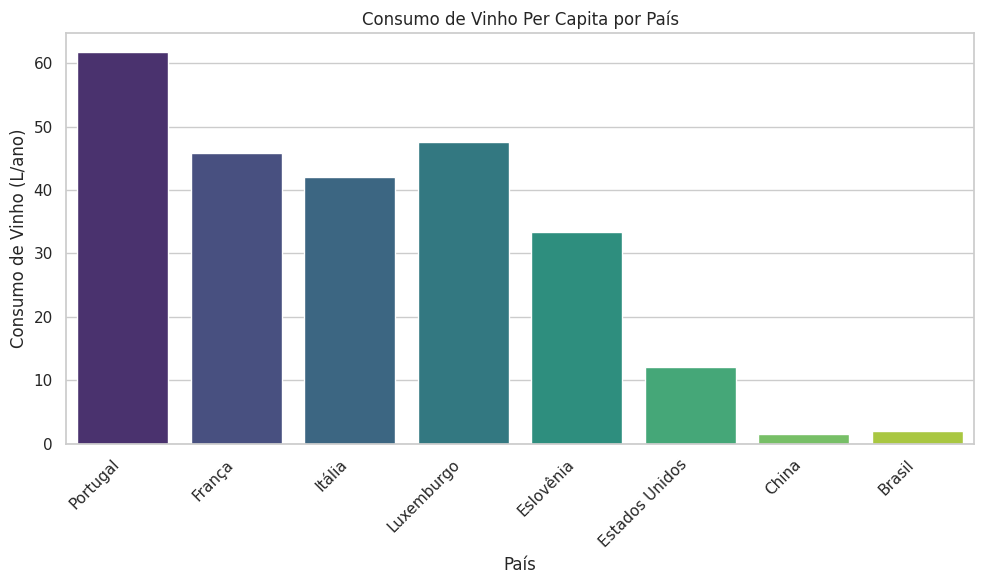

In [ ]:
# Gráfico Consumo de vinho por país (barras)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="País", y="Consumo de vinho per capita (L/ano)", palette="viridis")
plt.title("Consumo de Vinho Per Capita por País")
plt.xlabel("País")
plt.ylabel("Consumo de Vinho (L/ano)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Consumo de Vinho vs Renda per Capita

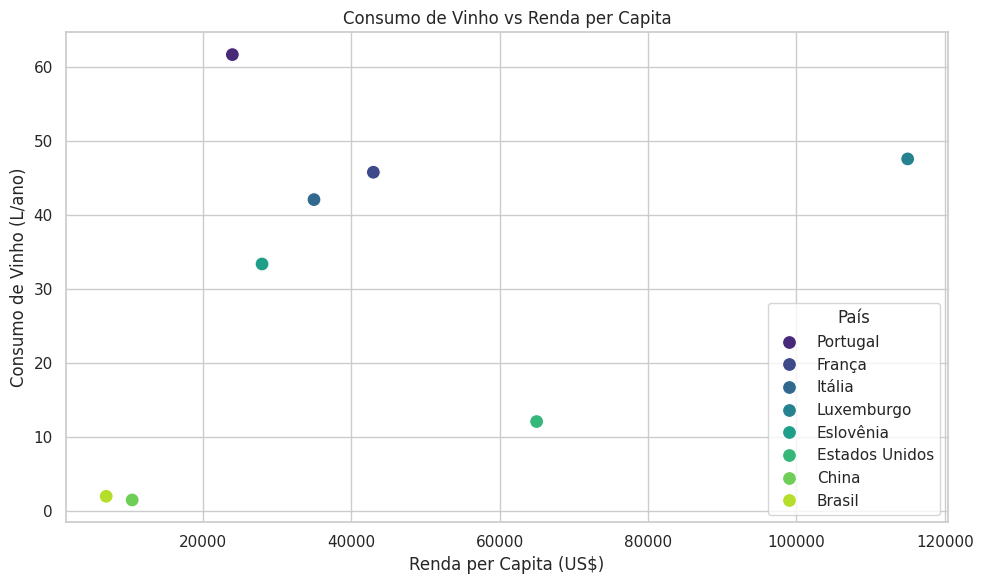

In [ ]:
# Gráfico Relação entre Consumo de Vinho e Renda per Capita (dispersão)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Renda per capita (US$)", y="Consumo de vinho per capita (L/ano)", hue="País", palette="viridis", s=100)
plt.title("Consumo de Vinho vs Renda per Capita")
plt.xlabel("Renda per Capita (US$)")
plt.ylabel("Consumo de Vinho (L/ano)")
plt.tight_layout()
plt.show()

##**Correlação de Variáveis (ao longo dos anos)**


In [ ]:
# Separando as variáveis que temos ao longo dos anos para fazer a correlação
variaveis_para_correlacao = ['Pib','Quantidade_Litros_Exp','Valor_USD_Exp','Quantidade_Litros_Imp','Valor_USD_Imp','Taxa_de_Cambio_Média_Anual','Consumo_Litros', 'Temperatura']

In [ ]:
# Calculando a correlação
corr=dados_agrupados_1[variaveis_para_correlacao].corr()

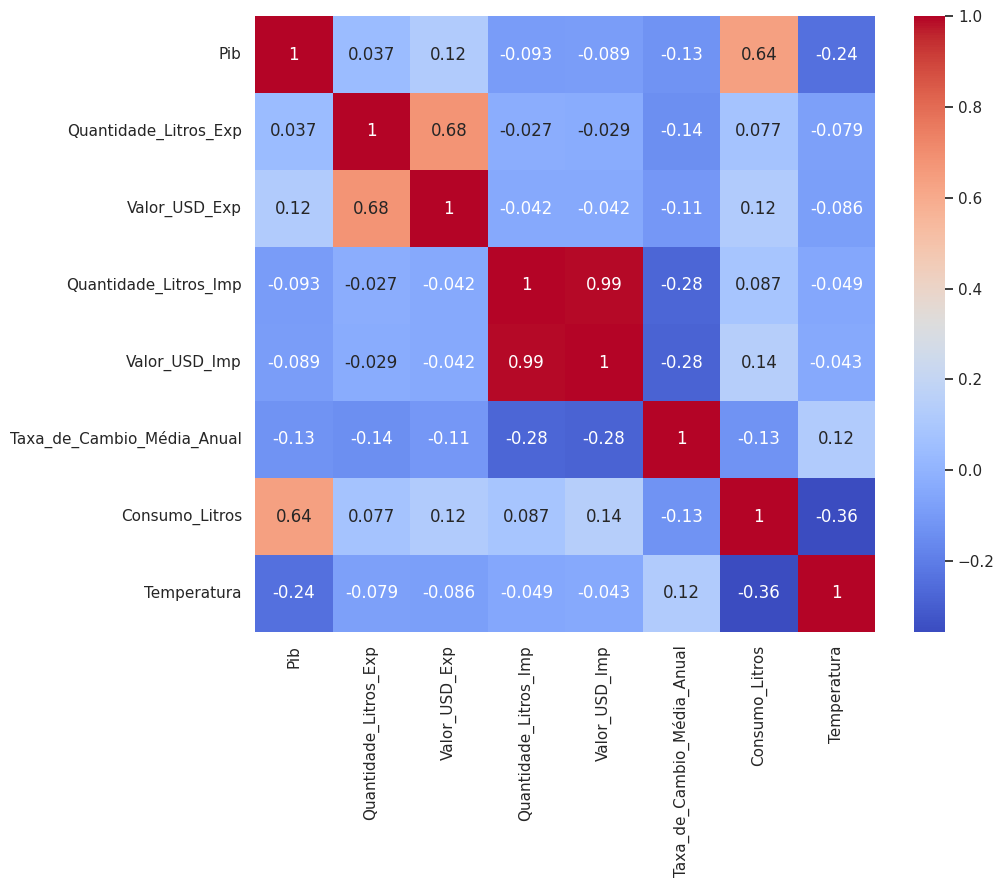

In [ ]:
# Criando o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

 - O consumo de vinho tem correlação inversa com a temperatura (-0,36) e correlação positiva com o PIB do país (0,64).
 - A taxa de cambio tem correlação inversa com a importação (litros)(-0,14) e a exportação (-028), porém a da importação é 2 vezes mais negativa que a exportação.